# VAE 모델 성능 분석 및 최적화 보고서

## 1. 정량적 성능 평가를 위한 AUC 지표 도입

### 1.1. 기존 평가 방식의 한계
* **측정 방법**: 모델 성능을 MSE, 95% 임계치, KL Divergence, ELBO 값 등 간접 지표와 잠재 공간 분포의 시각화를 통한 정성적 평가에 의존함.
* **판단의 모호성**:
    * MSE와 ELBO 값만으로는 실제 이상치 탐지 성능을 객관적으로 판단하기 어려움.
    * KL Divergence 값이 낮을 때, 이것이 학습이 잘 된 것인지 혹은 잠재 공간이 붕괴된(Posterior Collapse) 것인지 명확하게 구분하기 힘듦.
    * 잠재 공간 시각화는 차원 축소로 인한 정보 손실이 필연적이며, 전체 데이터 구조를 파악하는 데 제한적임.
* **주관적 평가**: 결국 모델의 성능 평가는 개발자의 경험과 도메인 지식에 의존하는 주관적 판단의 영역에 머무는 한계가 있었음.

### 1.2. 해결 방법: AUC 도입을 통한 객관적 평가 기준 확립
* **이진 분류 문제로의 변환**: 정상 테스트 데이터의 피처 순서를 무작위로 섞어 인위적인 이상치 데이터를 생성하고, 이를 원본 데이터와 혼합함.
* **정량적 측정**: VAE 모델이 출력하는 ELBO 점수를 이상치 점수로 활용하여, 정상과 이상 데이터를 얼마나 잘 구별하는지를 ROC 곡선과 AUC 값으로 정량화함.
* **기대 효과**: 객관적이고 재현 가능한 성능 지표를 확보하여, 하이퍼파라미터 조합별 우열을 명확하게 가릴 수 있는 신뢰성 있는 기준을 마련함.

## 2. 다층적 제약(Multi-layered Constraint) 완화를 통한 성능 최적화

### 2.1. 문제 제기: 과도한 제약으로 인한 성능 저하 가설
* **계기**: Posterior Collapse 방지와 학습 안정성 확보를 위해 적용했던 다양한 제약들이 누적되면서, 오히려 모델의 학습 능력을 과도하게 억제하는 현상을 발견함.
* **다층적 제약의 내용**:
    * **모델 구조적 제약**: `LeakyReLU`, `BatchNorm1d`, `Dropout`을 통한 모델 안정성 확보. `CosineAnnealingLR` 스케줄러와 그래디언트 클리핑을 통한 학습 과정 안정화.
    * **하이퍼파라미터 제약**: 높은 `Beta` 값을 통한 강한 KL Regularization, `Free bits` 메커니즘을 통한 KL Divergence 하한선 강제.
* **누적 제약의 문제점**: 각각의 제약은 의도가 있었으나, 모든 제약이 동시에 적용되면서 모델이 데이터의 복잡한 패턴을 학습할 용량과 자유도를 심각하게 제한함. 안정성 확보에만 치중한 나머지 성능 최적화의 기회를 잃고 있었음.

### 2.2. 실험 설계 및 결과
* **실험 설계**: Grid Search 기법을 사용하여 제약의 강도를 결정하는 `Beta`와 `Free bits`의 최적 조합을 체계적으로 탐색함.
    * `Beta` 후보값: [0.1, 0.3, 0.5, 0.7, 1.0]
    * `Free bits` 후보값: [0.0, 0.1, 0.2, 0.3, 0.5]
* **성능 평가**: 3-Fold 교차 검증을 통해 총 25개 조합의 성능을 객관적으로 평가.
* **실험 결과**: KL Regularization 제약이 가장 약한 조합인 **`Beta=0.1`, `Free bits=0.0`에서 최적의 성능을 달성**했으며, 테스트 재구성 오차 **0.044519**를 기록하며 기존 모델 대비 현저한 성능 향상을 확인함.

### 2.3. 성능 향상 요인 분석
* **제약 균형의 재조정**: 안정성을 위한 구조적 제약은 유지하되, 불필요해진 하이퍼파라미터 레벨의 제약을 대폭 완화하여 안정성과 학습 능력 간의 최적 균형점을 찾음.
* **낮은 Beta 값의 효과 (`Beta=0.1`)**: KL Regularization의 과도한 제약을 완화함으로써, 모델이 Reconstruction Loss에 더 집중하고 잠재 공간에서 데이터의 고차원적, 비선형적 특징을 학습할 수 있는 충분한 여유 공간을 확보함.
* **Free bits 제거의 의미 (`Free bits=0.0`)**: 인위적인 정보량 강제를 제거함으로써, 각 잠재 차원이 데이터의 특성에 맞게 자연스럽게 정보를 분배하도록 허용함. 이는 오히려 더 효과적인 표현(Representation) 학습으로 이어짐.

### 3. 최종 결론
1.  **과도한 다층적 제약**이 모델의 학습 능력을 심각하게 억제하여 성능 저하를 야기했음을 확인함.
2.  체계적인 하이퍼파라미터 탐색을 통해 **Reconstruction과 Regularization 간의 적절한 균형점**을 찾는 것이 성능 최적화에 결정적이었음.
3.  모델의 안정성과 학습 능력은 **트레이드오프(Trade-off) 관계**에 있으며, 이를 고려한 최적화 전략이 중요함.
4.  상황에 맞지 않는 모든 제약이 항상 좋은 결과를 가져오는 것은 아니며, **선택적인 제약 적용**이 필요함. VAE 기반 이상치 탐지에서는 때로는 하이퍼파라미터 최적화가 구조적 개선보다 더 큰 성능 향상을 가져올 수 있음.

compute_pca_weights

===== Starting Hyperparameter Search for 'beta' and 'free_bits' =====
Total combinations to evaluate: 25

--- Evaluating beta = 0.1, free_bits = 0.0 ---
  - Fold 1/3
    Fold 1 Best Val Loss: 1.4972
  - Fold 2/3
    Fold 2 Best Val Loss: 1.4498
  - Fold 3/3
    Fold 3 Best Val Loss: 1.4444
--- Avg Val Loss for beta=0.1, free_bits=0.0: 1.4638 ---

--- Evaluating beta = 0.1, free_bits = 0.1 ---
  - Fold 1/3
    Fold 1 Best Val Loss: 1.5073
  - Fold 2/3
    Fold 2 Best Val Loss: 1.4866
  - Fold 3/3
    Fold 3 Best Val Loss: 1.4780
--- Avg Val Loss for beta=0.1, free_bits=0.1: 1.4906 ---

--- Evaluating beta = 0.1, free_bits = 0.2 ---
  - Fold 1/3
    Fold 1 Best Val Loss: 1.4763
  - Fold 2/3
    Fold 2 Best Val Loss: 1.4938
  - Fold 3/3
    Fold 3 Best Val Loss: 1.4737
--- Avg Val Loss for beta=0.1, free_bits=0.2: 1.4813 ---

--- Evaluating beta = 0.1, free_bits = 0.3 ---
  - Fold 1/3
    Fold 1 Best Val Loss: 1.4980
  - Fold 2/3
    Fold 2 Best Val Loss: 1.4459
  - F

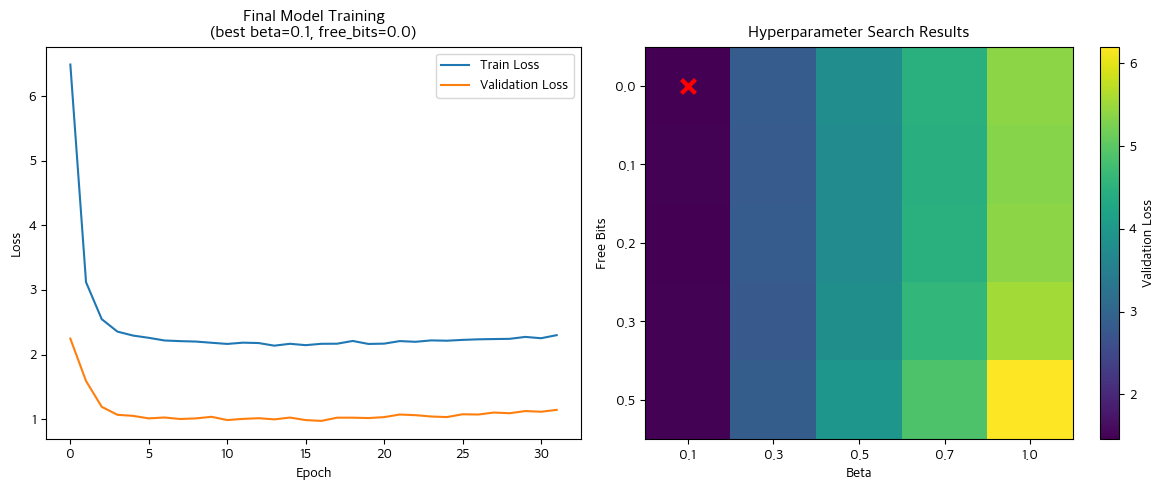

>>> Test Reconstruction Error (mean): 0.044519
Some Test Samples (ELBO Score):
Test #0 -> ELBO Score: 0.8223
Test #1 -> ELBO Score: 0.7413
Test #2 -> ELBO Score: 0.7289
Test #3 -> ELBO Score: 0.8236
Test #4 -> ELBO Score: 0.9080
Improved VAE model and optimal hyperparams saved
Optimal beta: 0.1, Optimal free_bits: 0.0
Inference results saved to ./result_with_error_improved.csv
Threshold = 1.7649, # of anomalies in Test: 18 / 343


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_49120/1453424101.py:527: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_49120/1453424101.py:528: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.savefig("latent_space_and_distributions.png", dpi=300)
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


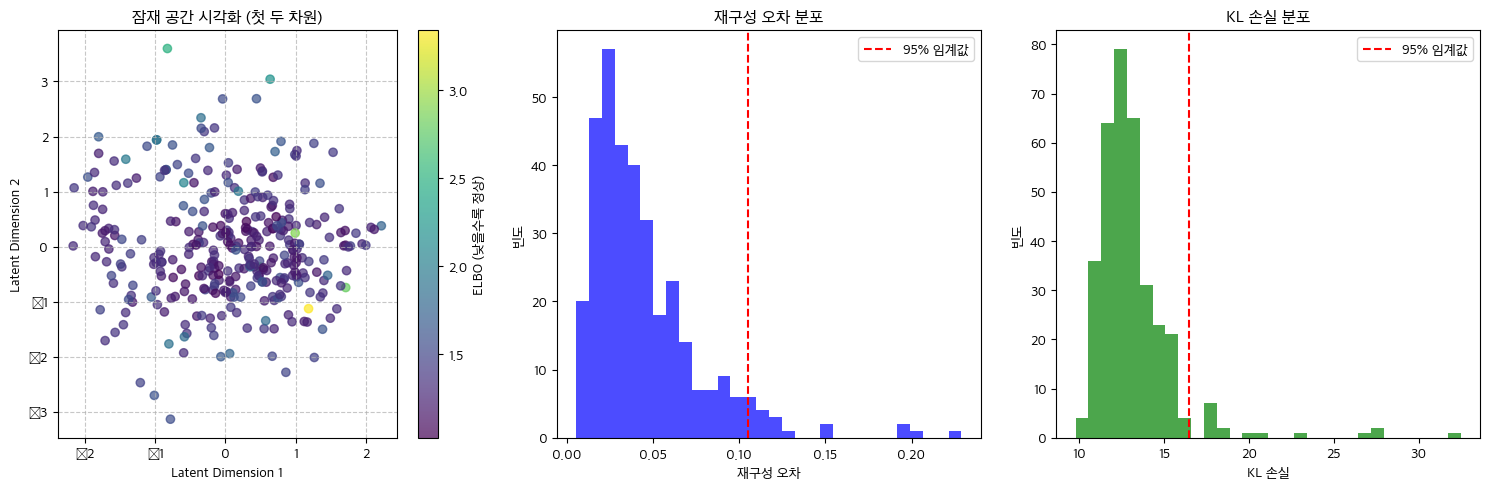

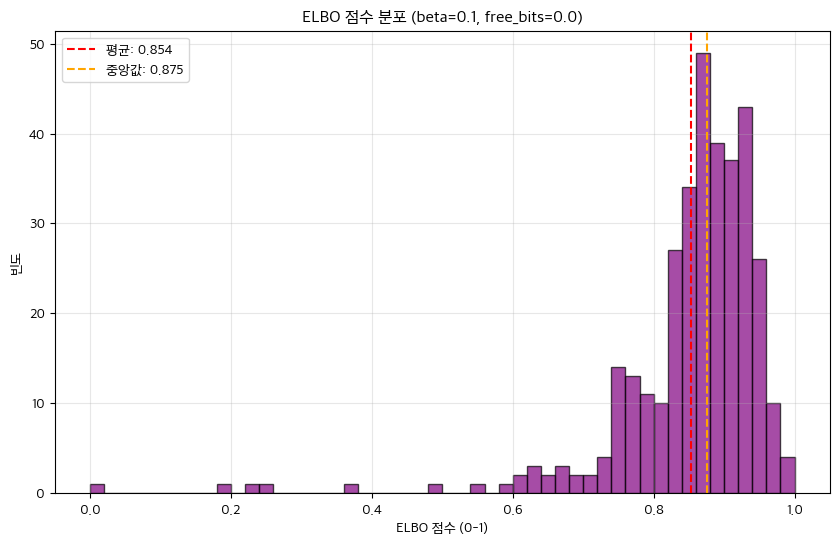


===== 최종 모델 성능 요약 =====
최적화된 하이퍼파라미터:
  - Beta: 0.1
  - Free Bits: 0.0
테스트 성능:
  - 재구성 오차: 0.044519
  - 이상치 감지 임계값 (95 퍼센타일): 1.764940
  - 감지된 이상치 수: 18 / 전체 테스트 샘플 수: 343
ELBO 점수 통계:
  - 평균: 0.8535
  - 표준편차: 0.1111
  - 최솟값: 0.0000
  - 최댓값: 1.0000

하이퍼파라미터 탐색 결과가 'hyperparameter_search_results.csv'에 저장되었습니다.
최적 조합: beta=0.1, free_bits=0.0, validation_loss=1.463805


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import joblib
from itertools import product

try:
    font_name = fm.FontProperties(fname="/System/Library/Fonts/AppleSDGothicNeo.ttc", size=12).get_name()
    plt.rc('font', family=font_name)
except FileNotFoundError:
    print("한글 폰트를 찾을 수 없습니다. 영문으로 표시됩니다.")

file_path = "../data/final_fish_data.csv"
df = pd.read_csv(file_path)

imputer = SimpleImputer(strategy="mean")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]

df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)

df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)

df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour

df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 
                                            2 if 6 <= x <= 8 else 
                                            3 if 9 <= x <= 11 else 4)

df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)

df['time_period'] = df['hour'].apply(
    lambda x: 0 if 0 <= x < 6 else 
              1 if 6 <= x < 12 else 
              2 if 12 <= x < 18 else 
              3
)

df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_cols = [
    "tmp_x_sea_temp",
    "ws_x_wh_sig",
    "weather_REH",
    "wvprd_max",
    "wvdr",
    "wd",
    'time_period_sin',
    'time_period_cos',
    'season_sin',
    'season_cos'
]

df_features = df[feature_cols].copy()

X_raw = df_features.values.astype(np.float32)
X_filled = imputer.fit_transform(X_raw)

X_trainval, X_test = train_test_split(
    X_filled,
    test_size=0.05,
    random_state=42,
    shuffle=True
)

scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

def compute_pca_weights(X):
    pca = PCA(n_components=min(X.shape[1], 5))
    pca.fit(X)
    feature_importance = np.abs(pca.components_)
    weights = np.sum(feature_importance, axis=0)
    weights = weights * (len(weights) / np.sum(weights))
    print("compute_pca_weights")
    return torch.tensor(weights, dtype=torch.float32)

class CyclicKLAnnealing:
    def __init__(self, n_cycles=4, ratio=0.5):
        self.n_cycles = n_cycles
        self.ratio = ratio
        
    def get_beta(self, epoch, max_epochs, max_beta=1.0, min_beta=0.0):
        cycle_length = max_epochs // self.n_cycles
        cycle_position = epoch % cycle_length
        annealing_length = int(cycle_length * self.ratio)
        
        if cycle_position < annealing_length:
            return min_beta + (max_beta - min_beta) * (cycle_position / annealing_length)
        else:
            return max_beta

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, latent_dim=8, dropout_rate=0.2):
        super(ImprovedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.fc_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    
    def decode(self, z):
        return self.output_layer(self.decoder(z))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def weighted_mse_loss(recon_x, x, weight_vector=None):
    if weight_vector is None:
        return F.mse_loss(recon_x, x, reduction='sum')
    else:
        weight_vector = weight_vector.to(recon_x.device)
        return torch.sum(((recon_x - x) ** 2) * weight_vector.unsqueeze(0))

def improved_vae_loss(recon_x, x, mu, logvar, beta=1.0, weight_vector=None, free_bits=0.0):
    recon_loss = weighted_mse_loss(recon_x, x, weight_vector)
    kl_loss_per_dimension = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if free_bits > 0:
        kl_loss_per_dimension = torch.max(kl_loss_per_dimension, torch.tensor(free_bits).to(kl_loss_per_dimension.device))
    kl_loss = torch.sum(kl_loss_per_dimension)
    return recon_loss + beta * kl_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

input_dim = X_trainval_scaled.shape[1]
hidden_dim = 64
latent_dim = 8
num_epochs = 300
batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-5
early_stop_patience = 15

feature_weights = compute_pca_weights(X_trainval_scaled)
X_trainval_np = X_trainval_scaled

print("\n===== Starting Hyperparameter Search for 'beta' and 'free_bits' =====")

beta_search_space = [0.1, 0.3, 0.5, 0.7, 1.0]
free_bits_search_space = [0.0, 0.1, 0.2, 0.3, 0.5]

hyperparam_combinations = list(product(beta_search_space, free_bits_search_space))
hyperparam_results = {}

print(f"Total combinations to evaluate: {len(hyperparam_combinations)}")

for beta_candidate, free_bits_candidate in hyperparam_combinations:
    print(f"\n--- Evaluating beta = {beta_candidate:.1f}, free_bits = {free_bits_candidate:.1f} ---")
    
    fold_best_val_losses = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_np)):
        print(f"  - Fold {fold_idx+1}/{n_splits}")
        X_tr, X_val = X_trainval_np[train_idx], X_trainval_np[val_idx]
        X_tr_tensor, X_val_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device), torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = ImprovedVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0.0
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=beta_candidate, 
                                      weight_vector=feature_weights, free_bits=free_bits_candidate)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_train_loss += loss.item()
            scheduler.step()
            
            model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=beta_candidate, 
                                          weight_vector=feature_weights, free_bits=free_bits_candidate)
                    total_val_loss += loss.item()
            val_loss_avg = total_val_loss / len(val_dataset)
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= early_stop_patience:
                break
        
        print(f"    Fold {fold_idx+1} Best Val Loss: {best_val_loss:.4f}")
        fold_best_val_losses.append(best_val_loss)

    avg_val_loss_for_combination = np.mean(fold_best_val_losses)
    hyperparam_results[(beta_candidate, free_bits_candidate)] = avg_val_loss_for_combination
    print(f"--- Avg Val Loss for beta={beta_candidate:.1f}, free_bits={free_bits_candidate:.1f}: {avg_val_loss_for_combination:.4f} ---")

best_combination = min(hyperparam_results, key=hyperparam_results.get)
best_beta, best_free_bits = best_combination
print(f"\n===== Hyperparameter Search Finished =====")
print(f"Optimal beta = {best_beta:.1f}, Optimal free_bits = {best_free_bits:.1f}")
print(f"Best validation loss: {hyperparam_results[best_combination]:.4f}")
print("\nAll results:")
for (beta, free_bits), loss in sorted(hyperparam_results.items(), key=lambda x: x[1]):
    print(f"beta={beta:.1f}, free_bits={free_bits:.1f}: {loss:.4f}")

X_final_train, X_final_val = train_test_split(X_trainval_np, test_size=0.1, random_state=42, shuffle=True)
X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)

trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)

trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_num_epochs = 500
final_model = ImprovedVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.AdamW(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=final_num_epochs, eta_min=1e-5)
kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)

train_loss_history_final = []
val_loss_history_final = []
best_val_loss_final = float('inf')
epochs_no_improve_final = 0
best_model_state_dict_final = None

print(f"\n===== Final Model Training with best beta = {best_beta:.1f}, free_bits = {best_free_bits:.1f} =====")
for epoch in range(final_num_epochs):
    current_beta = kl_scheduler.get_beta(epoch, final_num_epochs, best_beta, best_beta * 0.1)
    
    final_model.train()
    total_loss = 0.0
    for batch_x, _ in trainval_loader:
        optimizer.zero_grad()
        recon_x, mu, logvar = final_model(batch_x)
        loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                               weight_vector=feature_weights, free_bits=best_free_bits)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    train_loss_avg = total_loss / len(trainval_dataset)
    train_loss_history_final.append(train_loss_avg)
    
    final_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            recon_x, mu, logvar = final_model(batch_x)
            loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                                  weight_vector=feature_weights, free_bits=best_free_bits)
            total_val_loss += loss.item()
    val_loss_avg = total_val_loss / len(val_dataset)
    val_loss_history_final.append(val_loss_avg)
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{final_num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
    
    if val_loss_avg < best_val_loss_final:
        best_val_loss_final = val_loss_avg
        best_model_state_dict_final = final_model.state_dict()
        epochs_no_improve_final = 0
    else:
        epochs_no_improve_final += 1
    
    if epochs_no_improve_final >= early_stop_patience:
        print(f"Final model: Early stopping at epoch {epoch+1}")
        break

if best_model_state_dict_final is not None:
    final_model.load_state_dict(best_model_state_dict_final)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_final, label='Train Loss')
plt.plot(val_loss_history_final, label='Validation Loss')
plt.title(f'Final Model Training\n(best beta={best_beta:.1f}, free_bits={best_free_bits:.1f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
beta_values = sorted(set([combo[0] for combo in hyperparam_results.keys()]))
free_bits_values = sorted(set([combo[1] for combo in hyperparam_results.keys()]))

heatmap_data = np.zeros((len(free_bits_values), len(beta_values)))
for i, fb in enumerate(free_bits_values):
    for j, b in enumerate(beta_values):
        if (b, fb) in hyperparam_results:
            heatmap_data[i, j] = hyperparam_results[(b, fb)]

im = plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(im, label='Validation Loss')
plt.xticks(range(len(beta_values)), [f'{b:.1f}' for b in beta_values])
plt.yticks(range(len(free_bits_values)), [f'{fb:.1f}' for fb in free_bits_values])
plt.xlabel('Beta')
plt.ylabel('Free Bits')
plt.title('Hyperparameter Search Results')

best_beta_idx = beta_values.index(best_beta)
best_free_bits_idx = free_bits_values.index(best_free_bits)
plt.scatter(best_beta_idx, best_free_bits_idx, c='red', s=100, marker='x', linewidths=3)

plt.tight_layout()
plt.savefig("final_model_loss_and_hyperparam_search.png", dpi=300)
plt.show()

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
final_model.eval()
with torch.no_grad():
    recon_test, mu_test, logvar_test = final_model(X_test_tensor)
    recon_test = recon_test.cpu().numpy()
    mu_test = mu_test.cpu().numpy()
    logvar_test = logvar_test.cpu().numpy()

test_mse_each = np.mean((X_test_scaled - recon_test)**2, axis=1)
test_recon_error = np.mean(test_mse_each)
print(f">>> Test Reconstruction Error (mean): {test_recon_error:.6f}")

recon_errors = test_mse_each
kl_losses = -0.5 * np.sum(1 + logvar_test - mu_test**2 - np.exp(logvar_test), axis=1)

elbo_rows = recon_errors + best_beta * kl_losses

min_elbo = elbo_rows.min()
max_elbo = elbo_rows.max()
elbo_scores = 1 - (elbo_rows - min_elbo) / (max_elbo - min_elbo)
elbo_scores = np.clip(elbo_scores, 0, 1)

print("Some Test Samples (ELBO Score):")
for i in range(5):
    print(f"Test #{i} -> ELBO Score: {elbo_scores[i]:.4f}")

joblib.dump(imputer, "./models/imputer_improved.pkl")
joblib.dump(scaler, "./models/scaler_improved.pkl")
torch.save(final_model.state_dict(), "./models/final_improved.pth")

optimal_params = {
    'best_beta': best_beta,
    'best_free_bits': best_free_bits,
    'min_elbo': min_elbo,
    'max_elbo': max_elbo
}
joblib.dump(optimal_params, "./models/optimal_hyperparams.pkl")
print(f"Improved VAE model and optimal hyperparams saved")
print(f"Optimal beta: {best_beta:.1f}, Optimal free_bits: {best_free_bits:.1f}")

def inference_and_save(model, scaler, imputer, csv_path_in, csv_path_out, feature_cols,
                       beta=1.0, min_elbo=None, max_elbo=None, weight_vector=None, free_bits=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df_in = pd.read_csv(csv_path_in)
    df_in_filled = df_in.copy()

    df_in_filled["tmp_x_sea_temp"] = df_in_filled["weather_TMP"] * df_in_filled["matched_sea_temp"]
    df_in_filled["ws_x_wh_sig"] = df_in_filled["ws"] * df_in_filled["wh_sig"]
    df_in_filled['mul_tte_code'] = df_in_filled['mul_tte_code'].replace(-1, 0)
    df_in_filled['mul_tte_code_sin'] = np.sin(2 * np.pi * df_in_filled['mul_tte_code'] / 14)
    df_in_filled['mul_tte_code_cos'] = np.cos(2 * np.pi * df_in_filled['mul_tte_code'] / 14)
    df_in_filled['fishing_datetime'] = pd.to_datetime(df_in_filled['fishing_datetime_utc'])
    df_in_filled['month'] = df_in_filled['fishing_datetime'].dt.month
    df_in_filled['hour'] = df_in_filled['fishing_datetime'].dt.hour
    df_in_filled['season'] = df_in_filled['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
    df_in_filled['season_sin'] = np.sin(2 * np.pi * df_in_filled['season'] / 4)
    df_in_filled['season_cos'] = np.cos(2 * np.pi * df_in_filled['season'] / 4)
    df_in_filled['time_period'] = df_in_filled['hour'].apply(lambda x: 0 if 0 <= x < 6 else 1 if 6 <= x < 12 else 2 if 12 <= x < 18 else 3)
    df_in_filled['time_period_sin'] = np.sin(2 * np.pi * df_in_filled['time_period'] / 4)
    df_in_filled['time_period_cos'] = np.cos(2 * np.pi * df_in_filled['time_period'] / 4)

    X_in_raw = df_in_filled[feature_cols].values.astype(np.float32)
    X_in_filled = imputer.transform(X_in_raw)
    X_in_scaled = scaler.transform(X_in_filled)
    X_in_tensor = torch.tensor(X_in_scaled, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        recon_x, mu, logvar = model(X_in_tensor)
    recon_x, mu, logvar = recon_x.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()
    
    errors = np.mean((X_in_scaled - recon_x)**2, axis=1)
    kl_list = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1)
    elbo_list = errors + beta * kl_list
    
    score_list = None
    if (min_elbo is not None) and (max_elbo is not None):
        score_list = np.clip(1 - (elbo_list - min_elbo) / (max_elbo - min_elbo), 0, 1)
    
    df_in_filled["reconstruction_error"] = errors
    df_in_filled["kl_loss"] = kl_list
    df_in_filled["elbo"] = elbo_list
    if score_list is not None:
        df_in_filled["elbo_score_0to1"] = score_list
    
    df_in_filled.to_csv(csv_path_out, index=False)
    print(f"Inference results saved to {csv_path_out}")

inference_and_save(
    final_model, scaler, imputer, file_path, "./result_with_error_improved.csv",
    feature_cols, best_beta, min_elbo, max_elbo, feature_weights, best_free_bits
)

threshold = np.percentile(elbo_rows, 95)
abnormal_flags = elbo_rows > threshold
print(f"Threshold = {threshold:.4f}, # of anomalies in Test: {sum(abnormal_flags)} / {len(abnormal_flags)}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(mu_test[:, 0], mu_test[:, 1], c=elbo_rows, cmap='viridis', alpha=0.7)
plt.colorbar(label='ELBO (낮을수록 정상)')
plt.title('잠재 공간 시각화 (첫 두 차원)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.hist(recon_errors, bins=30, alpha=0.7, color='blue')
plt.axvline(x=np.percentile(recon_errors, 95), color='red', linestyle='--', label='95% 임계값')
plt.title('재구성 오차 분포')
plt.xlabel('재구성 오차')
plt.ylabel('빈도')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(kl_losses, bins=30, alpha=0.7, color='green')
plt.axvline(x=np.percentile(kl_losses, 95), color='red', linestyle='--', label='95% 임계값')
plt.title('KL 손실 분포')
plt.xlabel('KL 손실')
plt.ylabel('빈도')
plt.legend()

plt.tight_layout()
plt.savefig("latent_space_and_distributions.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(elbo_scores, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=np.mean(elbo_scores), color='red', linestyle='--', label=f'평균: {np.mean(elbo_scores):.3f}')
plt.axvline(x=np.median(elbo_scores), color='orange', linestyle='--', label=f'중앙값: {np.median(elbo_scores):.3f}')
plt.title(f'ELBO 점수 분포 (beta={best_beta:.1f}, free_bits={best_free_bits:.1f})')
plt.xlabel('ELBO 점수 (0-1)')
plt.ylabel('빈도')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("elbo_score_distribution.png", dpi=300)
plt.show()

print("\n===== 최종 모델 성능 요약 =====")
print(f"최적화된 하이퍼파라미터:")
print(f"  - Beta: {best_beta:.1f}")
print(f"  - Free Bits: {best_free_bits:.1f}")
print(f"테스트 성능:")
print(f"  - 재구성 오차: {test_recon_error:.6f}")
print(f"  - 이상치 감지 임계값 (95 퍼센타일): {threshold:.6f}")
print(f"  - 감지된 이상치 수: {sum(abnormal_flags)} / 전체 테스트 샘플 수: {len(abnormal_flags)}")
print(f"ELBO 점수 통계:")
print(f"  - 평균: {np.mean(elbo_scores):.4f}")
print(f"  - 표준편차: {np.std(elbo_scores):.4f}")
print(f"  - 최솟값: {np.min(elbo_scores):.4f}")
print(f"  - 최댓값: {np.max(elbo_scores):.4f}")

hyperparam_df = pd.DataFrame([
    {'beta': combo[0], 'free_bits': combo[1], 'validation_loss': loss}
    for combo, loss in hyperparam_results.items()
])
hyperparam_df = hyperparam_df.sort_values('validation_loss')
hyperparam_df.to_csv("hyperparameter_search_results.csv", index=False)
print(f"\n하이퍼파라미터 탐색 결과가 'hyperparameter_search_results.csv'에 저장되었습니다.")
print(f"최적 조합: beta={best_beta:.1f}, free_bits={best_free_bits:.1f}, validation_loss={hyperparam_results[best_combination]:.6f}")

# CosinAnnealing 및 그래디언트 클리핑 제거

한글 폰트 'Apple SD Gothic Neo'를 찾았습니다.
PCA 가중치 계산 완료.
===== K-Fold Training with Early Stopping (Improved VAE) =====

===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 6.2763, Val Loss: 5.5954, Beta: 0.2306
Epoch [20/500] Train Loss: 6.4658, Val Loss: 5.6809, Beta: 0.3758
Final model: Early stopping at epoch 23 (No improvement for 15 epochs)


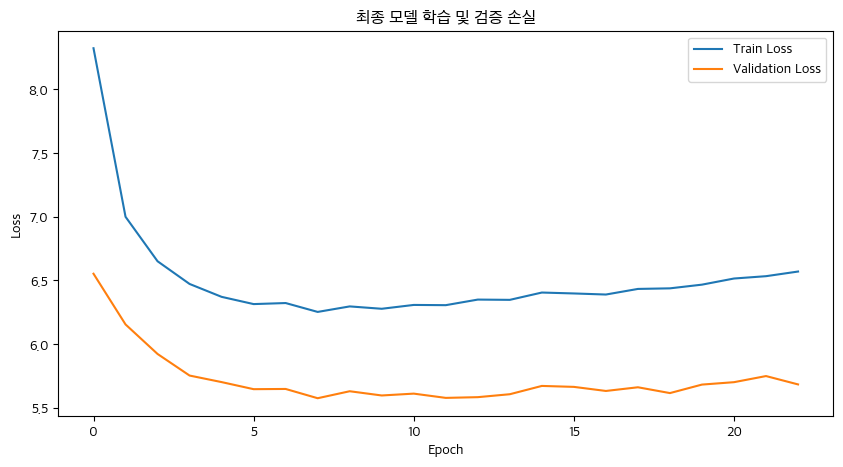


===== 테스트 데이터 평가 =====
>>> Test Reconstruction Error (mean): 0.469384

>>> 최종 모델 변별력 (AUC Score): 0.682828


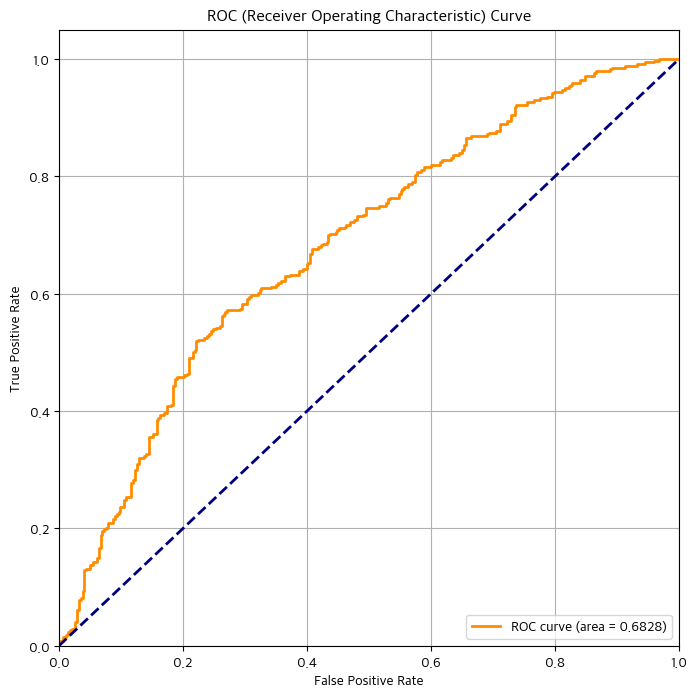

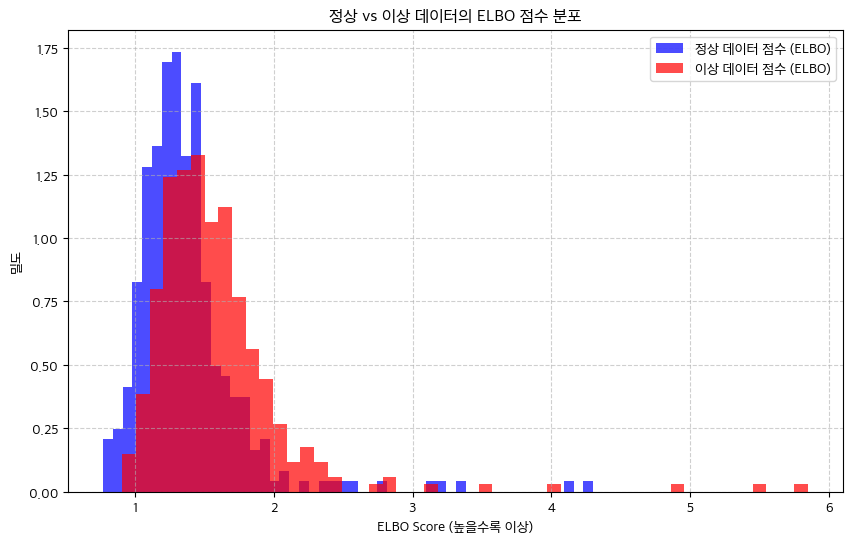

/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_49120/3934515917.py:307: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.savefig("latent_space_visualization.png")
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


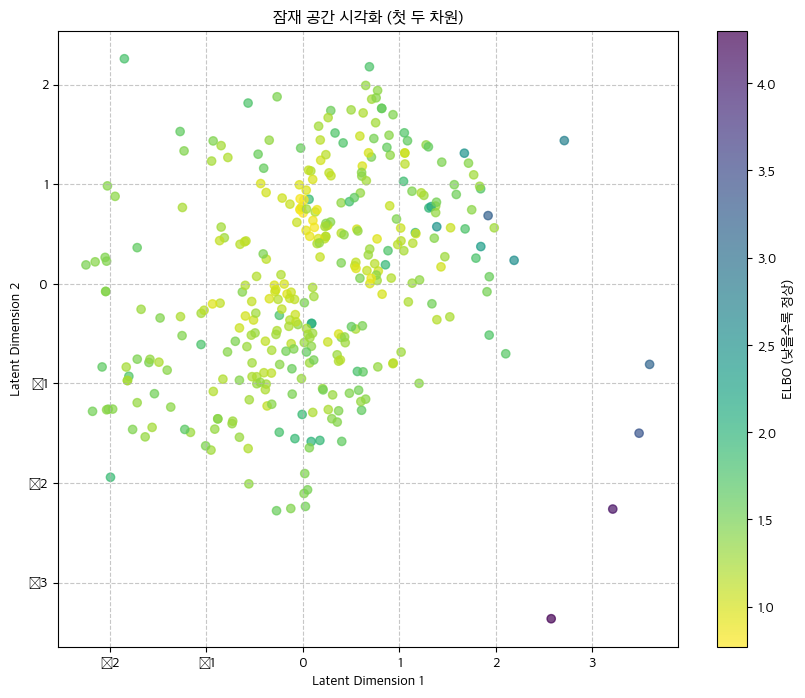

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

try:
    font_name = fm.FontProperties(fname="/System/Library/Fonts/AppleSDGothicNeo.ttc", size=12).get_name()
    plt.rc('font', family=font_name)
    print(f"한글 폰트 '{font_name}'를 찾았습니다.")
except FileNotFoundError:
    print("한글 폰트를 찾을 수 없습니다. 영문으로 표시됩니다.")

file_path = "../data/final_fish_data.csv"
df = pd.read_csv(file_path)

imputer = SimpleImputer(strategy="mean")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]
df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)
df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)
df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour
df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
df['time_period'] = df['hour'].apply(lambda x: 0 if 0 <= x < 6 else 1 if 6 <= x < 12 else 2 if 12 <= x < 18 else 3)
df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_cols = [
    "tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd",
    'time_period_sin', 'time_period_cos', 'season_sin', 'season_cos'
]
df_features = df[feature_cols].copy()
X_raw = df_features.values.astype(np.float32)
X_filled = imputer.fit_transform(X_raw)

X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

def compute_pca_weights(X):
    pca = PCA(n_components=min(X.shape[1], 5))
    pca.fit(X)
    feature_importance = np.abs(pca.components_)
    weights = np.sum(feature_importance, axis=0)
    weights = weights * (len(weights) / np.sum(weights))
    print("PCA 가중치 계산 완료.")
    return torch.tensor(weights, dtype=torch.float32)

class CyclicKLAnnealing:
    def __init__(self, n_cycles=4, ratio=0.5):
        self.n_cycles, self.ratio = n_cycles, ratio
    def get_beta(self, epoch, max_epochs, max_beta=1.0, min_beta=0.0):
        cycle_length = max_epochs // self.n_cycles
        cycle_position = epoch % cycle_length
        annealing_length = int(cycle_length * self.ratio)
        return min_beta + (max_beta - min_beta) * (cycle_position / annealing_length) if cycle_position < annealing_length else max_beta

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, latent_dim=8, dropout_rate=0.2):
        super(ImprovedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.fc_mu, self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim), nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    def decode(self, z): return self.output_layer(self.decoder(z))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def weighted_mse_loss(recon_x, x, weight_vector=None):
    if weight_vector is None:
        return F.mse_loss(recon_x, x, reduction='sum')
    else:
        weight_vector = weight_vector.to(recon_x.device)
        return torch.sum(((recon_x - x) ** 2) * weight_vector.unsqueeze(0))

def improved_vae_loss(recon_x, x, mu, logvar, beta=1.0, weight_vector=None, free_bits=0.0):
    recon_loss = weighted_mse_loss(recon_x, x, weight_vector)
    kl_loss_per_dimension = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if free_bits > 0:
        kl_loss_per_dimension = torch.max(kl_loss_per_dimension, torch.tensor(free_bits, device=kl_loss_per_dimension.device))
    kl_loss = torch.sum(kl_loss_per_dimension)
    return recon_loss + beta * kl_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

input_dim = X_trainval_scaled.shape[1]
hidden_dim, latent_dim = 128, 2
num_epochs, batch_size = 500, 128
learning_rate, weight_decay = 1e-3, 1e-5
beta_max, beta_min = 1.0, 0.1
free_bits = 0.1
feature_weights = compute_pca_weights(X_trainval_scaled)

fold_recon_errors = []
fold_train_losses = []
fold_val_losses = []
X_trainval_np = X_trainval_scaled

early_stop_patience = 15
print("===== K-Fold Training with Early Stopping (Improved VAE) =====")

X_final_train, X_final_val = train_test_split(X_trainval_np, test_size=0.1, random_state=42, shuffle=True)
X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)
trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_model = ImprovedVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.AdamW(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)

train_loss_history_final, val_loss_history_final = [], []
best_val_loss_final, epochs_no_improve_final = float('inf'), 0
best_model_state_dict_final = None

print("\n===== Final Model Training with Early Stopping (Improved VAE) =====")
for epoch in range(num_epochs):
    current_beta = kl_scheduler.get_beta(epoch, num_epochs, beta_max, beta_min)
    final_model.train()
    total_loss = 0.0
    for batch_x, _ in trainval_loader:
        optimizer.zero_grad()
        recon_x, mu, logvar = final_model(batch_x)
        loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_loss_avg = total_loss / len(trainval_dataset)
    train_loss_history_final.append(train_loss_avg)
    
    final_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            recon_x, mu, logvar = final_model(batch_x)
            loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
            total_val_loss += loss.item()
    val_loss_avg = total_val_loss / len(val_dataset)
    val_loss_history_final.append(val_loss_avg)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
    
    if val_loss_avg < best_val_loss_final:
        best_val_loss_final, epochs_no_improve_final = val_loss_avg, 0
        best_model_state_dict_final = final_model.state_dict()
    else:
        epochs_no_improve_final += 1
    
    if epochs_no_improve_final >= early_stop_patience:
        print(f"Final model: Early stopping at epoch {epoch+1} (No improvement for {early_stop_patience} epochs)")
        break

if best_model_state_dict_final is not None:
    final_model.load_state_dict(best_model_state_dict_final)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_final, label='Train Loss')
plt.plot(val_loss_history_final, label='Validation Loss')
plt.title('최종 모델 학습 및 검증 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("final_model_loss_improved_vae.png")
plt.show()

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
final_model.eval()

def get_elbo_scores(model, data_tensor, beta, weight_vector=None):
    with torch.no_grad():
        recon_x, mu, logvar = model(data_tensor)
        recon_x, mu, logvar = recon_x.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()
    
    data_np = data_tensor.cpu().numpy()
    
    recon_errors_mse = np.mean((data_np - recon_x)**2, axis=1)
    
    kl_losses = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1)
    
    elbo_scores = recon_errors_mse + beta * kl_losses
    return elbo_scores, recon_errors_mse

final_beta = 0.3
elbo_normal, mse_normal = get_elbo_scores(final_model, X_test_tensor, final_beta, feature_weights)

print("\n===== 테스트 데이터 평가 =====")
print(f">>> Test Reconstruction Error (mean): {np.mean(mse_normal):.6f}")

X_test_anomaly = X_test_scaled.copy()
for i in range(X_test_anomaly.shape[0]):
    np.random.shuffle(X_test_anomaly[i, :])
X_test_anomaly_tensor = torch.tensor(X_test_anomaly, dtype=torch.float32).to(device)

elbo_anomaly, _ = get_elbo_scores(final_model, X_test_anomaly_tensor, final_beta, feature_weights)

y_true = np.concatenate([np.zeros(len(elbo_normal)), np.ones(len(elbo_anomaly))])
all_scores = np.concatenate([elbo_normal, elbo_anomaly])

auc_score = roc_auc_score(y_true, all_scores)
fpr, tpr, thresholds = roc_curve(y_true, all_scores)

print(f"\n>>> 최종 모델 변별력 (AUC Score): {auc_score:.6f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(elbo_normal, bins=50, alpha=0.7, label='정상 데이터 점수 (ELBO)', color='blue', density=True)
plt.hist(elbo_anomaly, bins=50, alpha=0.7, label='이상 데이터 점수 (ELBO)', color='red', density=True)
plt.title('정상 vs 이상 데이터의 ELBO 점수 분포')
plt.xlabel('ELBO Score (높을수록 이상)')
plt.ylabel('밀도')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("score_distribution.png")
plt.show()

with torch.no_grad():
    _, latent_mu, _ = final_model(X_test_tensor)
    latent_mu = latent_mu.cpu().numpy()

plt.figure(figsize=(10, 8))
plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=elbo_normal, cmap='viridis_r', alpha=0.7)
plt.colorbar(label='ELBO (낮을수록 정상)')
plt.title('잠재 공간 시각화 (첫 두 차원)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("latent_space_visualization.png")
plt.show()


In [5]:
import joblib
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from typing import List, Tuple, Dict, Optional
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import product
import time

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def heatmap(df: pd.DataFrame, title: str = 'Correlation Heatmap'):
    plt.figure(figsize=(12, 10))
    corr = df.corr()
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def find_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.9) -> set:
    corr_matrix = df.corr().abs()
    highly_correlated_pairs = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                highly_correlated_pairs.add((colname, corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    return highly_correlated_pairs

def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=np.number).dropna()
    
    numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_df.dropna(inplace=True)

    constant_cols = [col for col in numeric_df.columns if numeric_df[col].nunique() <= 1]
    if constant_cols:
        numeric_df = numeric_df.drop(columns=constant_cols)

    if numeric_df.shape[1] < 2:
        return pd.DataFrame(columns=['Feature', 'VIF', 'priority_score'])

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    
    vif_values = []
    for i in range(numeric_df.shape[1]):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
        except Exception:
            vif = np.inf
        vif_values.append(vif)
        
    vif_data["VIF"] = vif_values

    vif_data['priority_score'] = vif_data['VIF'].apply(
        lambda x: 0 if np.isinf(x) else
                  1 if x >= 50 else
                  2 if x >= 20 else
                  3 if x >= 10 else
                  4 if x >= 5 else 5
    )

    vif_result = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    return vif_result

def analyze_data_correlation(df: pd.DataFrame, title_prefix: str = "Data"):
    print(f"\n{'='*60}")
    print(f"{title_prefix} Correlation Analysis")
    print(f"{'='*60}")
    
    df_numeric = df.select_dtypes(include=np.number)
    
    print(f"Number of numeric variables: {len(df_numeric.columns)}")
    print(f"Numeric variables: {list(df_numeric.columns)}")
    
    heatmap(df_numeric, title=f'{title_prefix} Correlation Heatmap')
    
    highly_correlated_features = find_highly_correlated_features(df_numeric, threshold=0.7)
    print(f"\nHighly correlated feature pairs (threshold=0.7):")
    if highly_correlated_features:
        for pair in sorted(highly_correlated_features, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  No highly correlated pairs found.")
    
    moderate_corr_features = find_highly_correlated_features(df_numeric, threshold=0.3)
    print(f"\nModerate correlation feature pairs (threshold=0.3):")
    if moderate_corr_features:
        moderate_only = moderate_corr_features - highly_correlated_features
        for pair in sorted(moderate_only, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  No moderate correlation pairs found.")
    
    print(f"\nVIF (Variance Inflation Factor) Analysis:")
    vif_result = calculate_vif(df_numeric)
    if not vif_result.empty:
        print(vif_result.to_string(index=False))
        
        high_vif = vif_result[vif_result['VIF'] >= 10]
        if not high_vif.empty:
            print(f"\nHigh VIF values (≥10) variables:")
            for _, row in high_vif.iterrows():
                print(f"  {row['Feature']}: {row['VIF']:.2f}")
        else:
            print(f"\nAll variables have VIF < 10.")
    else:
        print("  Insufficient data for VIF calculation.")
    
    return {
        'numeric_df': df_numeric,
        'high_corr': highly_correlated_features,
        'moderate_corr': moderate_corr_features,
        'vif_result': vif_result
    }

def compute_pca_weights(X: np.ndarray, variance_threshold: float = 0.95, feature_names: List[str] = None) -> torch.Tensor:
    pca_full = PCA()
    pca_full.fit(X)
    
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumsum_variance >= variance_threshold) + 1
    n_components = min(n_components, X.shape[1])
    
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    variance_ratios = pca.explained_variance_ratio_
    components_abs = np.abs(pca.components_)
    
    weighted_importance = np.zeros(X.shape[1])
    for i, (component, variance_ratio) in enumerate(zip(components_abs, variance_ratios)):
        weighted_importance += component * variance_ratio

    weights = weighted_importance * (len(weighted_importance) / np.sum(weighted_importance))
    
    if feature_names is not None:
        _visualize_pca_results(pca, pca_full, weights, feature_names, variance_threshold, n_components)
    
    return torch.tensor(weights, dtype=torch.float32)

def _visualize_pca_results(pca, pca_full, weights, feature_names, variance_threshold, n_components):
    
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(len(weights))]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    axes[0, 0].plot(range(1, len(cumsum_var)+1), cumsum_var, 'bo-', linewidth=2, markersize=6)
    axes[0, 0].axhline(y=variance_threshold, color='r', linestyle='--', alpha=0.7, 
                      label=f'{variance_threshold*100}% threshold')
    axes[0, 0].axvline(x=n_components, color='g', linestyle='--', alpha=0.7, 
                      label=f'Selected: {n_components} components')
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('Cumulative Variance Explained')
    axes[0, 0].set_title('PCA Cumulative Variance Explained')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    sorted_idx = np.argsort(weights)[::-1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(weights)))
    bars = axes[0, 1].barh(range(len(weights)), weights[sorted_idx], color=colors)
    axes[0, 1].set_yticks(range(len(weights)))
    axes[0, 1].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[0, 1].set_xlabel('PCA Weight')
    axes[0, 1].set_title('Feature Weights (Variance-Weighted)')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    variance_ratios = pca.explained_variance_ratio_
    axes[1, 0].bar(range(1, len(variance_ratios)+1), variance_ratios, 
                   color='lightcoral', alpha=0.8, edgecolor='black')
    axes[1, 0].set_xlabel('Principal Component')
    axes[1, 0].set_ylabel('Variance Explained')
    axes[1, 0].set_title('Individual PC Variance Contribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    for i, val in enumerate(variance_ratios):
        axes[1, 0].text(i+1, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    if len(pca.components_) >= 2:
        pc1_loadings = pca.components_[0]
        pc2_loadings = pca.components_[1]
        
        scatter = axes[1, 1].scatter(pc1_loadings, pc2_loadings, 
                                   c=weights, cmap='viridis', s=100, alpha=0.7, edgecolors='black')
        
        for i, name in enumerate(feature_names):
            axes[1, 1].annotate(name, (pc1_loadings[i], pc2_loadings[i]), 
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[1, 1].set_xlabel(f'PC1 Loading ({variance_ratios[0]:.1%} var)')
        axes[1, 1].set_ylabel(f'PC2 Loading ({variance_ratios[1]:.1%} var)')
        axes[1, 1].set_title('Feature Loadings in PC1-PC2 Space')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 1].axvline(x=0, color='k', linestyle='-', alpha=0.3)
        
        plt.colorbar(scatter, ax=axes[1, 1], label='PCA Weight')
    else:
        axes[1, 1].text(0.5, 0.5, 'Need 2+ components\nfor loading plot', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('PC1-PC2 Loading Plot')
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 50)
    print("PCA WEIGHTS ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Components used: {n_components}")
    print(f"Total variance explained: {np.sum(variance_ratios):.1%}")
    print(f"Variance threshold: {variance_threshold*100}%")
    
    print(f"\nTop 5 Important Features:")
    sorted_idx = np.argsort(weights)[::-1]
    for i in range(min(5, len(weights))):
        idx = sorted_idx[i]
        print(f"  {i+1}. {feature_names[idx]:20s}: {weights[idx]:.4f}")
    
    print(f"\nComponent Contributions:")
    for i, ratio in enumerate(variance_ratios):
        print(f"  PC{i+1}: {ratio:.1%}")
    
    return None

class CyclicKLAnnealing:
    def __init__(self, n_cycles=4, ratio=0.5):
        self.n_cycles, self.ratio = n_cycles, ratio
    def get_beta(self, epoch, max_epochs, max_beta=1.0, min_beta=0.0):
        cycle_length = max_epochs // self.n_cycles
        cycle_position = epoch % cycle_length
        annealing_length = int(cycle_length * self.ratio)
        return min_beta + (max_beta - min_beta) * (cycle_position / annealing_length) if cycle_position < annealing_length else max_beta

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, latent_dim=8, dropout_rate=0.2):
        super(ImprovedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.fc_mu, self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim), nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    def decode(self, z): return self.output_layer(self.decoder(z))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def weighted_mse_loss(recon_x, x, weight_vector=None):
    if weight_vector is None:
        return F.mse_loss(recon_x, x, reduction='sum')
    else:
        weight_vector = weight_vector.to(recon_x.device)
        return torch.sum(((recon_x - x) ** 2) * weight_vector.unsqueeze(0))

def improved_vae_loss(recon_x, x, mu, logvar, beta=1.0, weight_vector=None, free_bits=0.0):
    recon_loss = weighted_mse_loss(recon_x, x, weight_vector)
    kl_loss_per_dimension = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if free_bits > 0:
        kl_loss_per_dimension = torch.max(kl_loss_per_dimension, torch.tensor(free_bits, device=kl_loss_per_dimension.device))
    kl_loss = torch.sum(kl_loss_per_dimension)
    return recon_loss + beta * kl_loss

def get_elbo_scores(model, data_tensor, beta, weight_vector=None):
    with torch.no_grad():
        recon_x, mu, logvar = model(data_tensor)
        recon_x, mu, logvar = recon_x.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()
    
    data_np = data_tensor.cpu().numpy()
    
    recon_errors_mse = np.mean((data_np - recon_x)**2, axis=1)
    kl_losses = -0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1)
    elbo_scores = recon_errors_mse + beta * kl_losses
    return elbo_scores, recon_errors_mse

def run_improved_vae_analysis(df: pd.DataFrame, user_feature_cols: List[str] = None, 
                             experiment_name: str = "Improved_VAE_Analysis") -> Dict:
    
    print("Starting correlation analysis...")
    correlation_analysis = analyze_data_correlation(df, "Dataset")
    
    if user_feature_cols is None:
        df_processed = df.copy()
        df_processed["tmp_x_sea_temp"] = df_processed["weather_TMP"] * df_processed["matched_sea_temp"]
        df_processed["ws_x_wh_sig"] = df_processed["ws"] * df_processed["wh_sig"]
        df_processed['mul_tte_code'] = df_processed['mul_tte_code'].replace(-1, 0)
        df_processed['mul_tte_code_sin'] = np.sin(2 * np.pi * df_processed['mul_tte_code'] / 14)
        df_processed['mul_tte_code_cos'] = np.cos(2 * np.pi * df_processed['mul_tte_code'] / 14)
        df_processed['fishing_datetime'] = pd.to_datetime(df_processed['fishing_datetime_utc'])
        df_processed['month'] = df_processed['fishing_datetime'].dt.month
        df_processed['hour'] = df_processed['fishing_datetime'].dt.hour
        df_processed['season'] = df_processed['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
        df_processed['season_sin'] = np.sin(2 * np.pi * df_processed['season'] / 4)
        df_processed['season_cos'] = np.cos(2 * np.pi * df_processed['season'] / 4)
        df_processed['time_period'] = df_processed['hour'].apply(lambda x: 0 if 0 <= x < 6 else 1 if 6 <= x < 12 else 2 if 12 <= x < 18 else 3)
        df_processed['time_period_sin'] = np.sin(2 * np.pi * df_processed['time_period'] / 4)
        df_processed['time_period_cos'] = np.cos(2 * np.pi * df_processed['time_period'] / 4)
        
        feature_cols = [
            "tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd",
            'time_period_sin', 'time_period_cos', 'season_sin', 'season_cos'
        ]
    else:
        df_processed = df.copy()
        feature_cols = user_feature_cols
    
    missing_features = [col for col in feature_cols if col not in df_processed.columns]
    if missing_features:
        raise ValueError(f"Missing selected feature columns in CSV: {missing_features}")
    
    print(f"\n{'='*60}")
    print(f"Improved VAE Analysis: {experiment_name}")
    print(f"Features used: {feature_cols}")
    print(f"{'='*60}")
    
    df_features = df_processed[feature_cols].copy()
    imputer = SimpleImputer(strategy="mean")
    X_raw = df_features.values.astype(np.float32)
    X_filled = imputer.fit_transform(X_raw)
    
    X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
    scaler = StandardScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data shape - Train: {X_trainval_scaled.shape}, Test: {X_test_scaled.shape}")
    
    device = get_device()
    input_dim = X_trainval_scaled.shape[1]
    print(f"Device used: {device}")
    
    feature_weights = compute_pca_weights(X_trainval_scaled, feature_names=feature_cols)
    print("PCA weight calculation completed.")
    
    hidden_dim, latent_dim = 128, 2
    num_epochs, batch_size = 500, 128
    learning_rate, weight_decay = 1e-3, 1e-5
    beta_max, beta_min = 1.0, 0.1
    free_bits = 0.1
    early_stop_patience = 15
    
    # K-Fold Cross Validation
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X_trainval_np = X_trainval_scaled
    
    fold_recon_errors = []
    fold_train_losses = []
    fold_val_losses = []
    
    print("===== K-Fold Training with Early Stopping (Improved VAE) =====")
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_np)):
        print(f"\n--- Fold {fold_idx+1} / {n_splits} ---")
        
        X_tr, X_val = X_trainval_np[train_idx], X_trainval_np[val_idx]
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = ImprovedVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
        
        train_loss_history = []
        val_loss_history = []
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state_dict = None
        
        for epoch in range(num_epochs):
            current_beta = kl_scheduler.get_beta(epoch, num_epochs, beta_max, beta_min)
            
            model.train()
            batch_train_losses = []
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())
            train_loss_avg = np.mean(batch_train_losses)
            
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
                    batch_val_losses.append(loss.item())
            val_loss_avg = np.mean(batch_val_losses)
            
            train_loss_history.append(train_loss_avg)
            val_loss_history.append(val_loss_avg)
            
            if (epoch+1) % 20 == 0:
                print(f"  Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state_dict = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= early_stop_patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
        
        fold_train_losses.append(train_loss_history)
        fold_val_losses.append(val_loss_history)
        
        if best_model_state_dict is not None:
            model.load_state_dict(best_model_state_dict)
        
        model.eval()
        with torch.no_grad():
            recon_val, _, _ = model(X_val_tensor)
            recon_val_np = recon_val.cpu().numpy()
            X_val_np = X_val_tensor.cpu().numpy()
        
        mse_each = np.mean((X_val_np - recon_val_np)**2, axis=1)
        fold_mse = np.mean(mse_each)
        print(f"  Fold {fold_idx+1} validation reconstruction error: {fold_mse:.6f}")
        fold_recon_errors.append(fold_mse)
    
    cv_mean_error = np.mean(fold_recon_errors)
    print(f"\nK-Fold average validation reconstruction error: {cv_mean_error:.6f}")
    
    # Plot K-Fold training curves
    plt.figure(figsize=(12, 5))
    for i in range(n_splits):
        plt.plot(range(len(fold_train_losses[i])), fold_train_losses[i], label=f"Fold{i+1}_Train", alpha=0.7)
        plt.plot(range(len(fold_val_losses[i])), fold_val_losses[i], '--', label=f"Fold{i+1}_Val", alpha=0.7)
    plt.title(f"{experiment_name} - K-Fold Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Final Model Training
    X_final_train, X_final_val = train_test_split(X_trainval_np, test_size=0.1, random_state=42, shuffle=True)
    X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
    X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
    trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)
    trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    final_model = ImprovedVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.AdamW(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
    
    train_loss_history_final, val_loss_history_final = [], []
    best_val_loss_final, epochs_no_improve_final = float('inf'), 0
    best_model_state_dict_final = None
    
    print("\n===== Final Model Training with Early Stopping (Improved VAE) =====")
    for epoch in range(num_epochs):
        current_beta = kl_scheduler.get_beta(epoch, num_epochs, beta_max, beta_min)
        final_model.train()
        total_loss = 0.0
        for batch_x, _ in trainval_loader:
            optimizer.zero_grad()
            recon_x, mu, logvar = final_model(batch_x)
            loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(trainval_dataset)
        train_loss_history_final.append(train_loss_avg)
        
        final_model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_x, _ in val_loader:
                recon_x, mu, logvar = final_model(batch_x)
                loss = improved_vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=free_bits)
                total_val_loss += loss.item()
        val_loss_avg = total_val_loss / len(val_dataset)
        val_loss_history_final.append(val_loss_avg)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
        
        if val_loss_avg < best_val_loss_final:
            best_val_loss_final, epochs_no_improve_final = val_loss_avg, 0
            best_model_state_dict_final = final_model.state_dict()
        else:
            epochs_no_improve_final += 1
        
        if epochs_no_improve_final >= early_stop_patience:
            print(f"Final model: Early stopping at epoch {epoch+1} (No improvement for {early_stop_patience} epochs)")
            break
    
    if best_model_state_dict_final is not None:
        final_model.load_state_dict(best_model_state_dict_final)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history_final, label='Train Loss')
    plt.plot(val_loss_history_final, label='Validation Loss')
    plt.title('Final Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Test Data Evaluation
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    final_model.eval()
    
    final_beta = 0.3
    elbo_normal, mse_normal = get_elbo_scores(final_model, X_test_tensor, final_beta, feature_weights)
    
    print("\n===== Test Data Evaluation =====")
    print(f">>> Test Reconstruction Error (mean): {np.mean(mse_normal):.6f}")
    
    # ===== 여기서 ELBO 점수 출력 추가 =====
    print(f"\n===== ELBO Score Analysis (Normal Data) =====")
    print(f"Normal data ELBO scores:")
    print(f"  - Mean: {np.mean(elbo_normal):.6f}")
    print(f"  - Std: {np.std(elbo_normal):.6f}")
    print(f"  - Min: {np.min(elbo_normal):.6f}")
    print(f"  - Max: {np.max(elbo_normal):.6f}")
    print(f"  - Median: {np.median(elbo_normal):.6f}")
    print(f"  - 25th percentile: {np.percentile(elbo_normal, 25):.6f}")
    print(f"  - 75th percentile: {np.percentile(elbo_normal, 75):.6f}")
    print(f"  - 95th percentile: {np.percentile(elbo_normal, 95):.6f}")
    
    # Create anomaly data by permutation
    X_test_anomaly = X_test_scaled.copy()
    for i in range(X_test_anomaly.shape[0]):
        np.random.shuffle(X_test_anomaly[i, :])
    X_test_anomaly_tensor = torch.tensor(X_test_anomaly, dtype=torch.float32).to(device)
    
    elbo_anomaly, _ = get_elbo_scores(final_model, X_test_anomaly_tensor, final_beta, feature_weights)
    
    # ===== ELBO 점수 비교 출력 추가 =====
    print(f"\n===== ELBO Score Analysis (Anomaly Data) =====")
    print(f"Anomaly data ELBO scores:")
    print(f"  - Mean: {np.mean(elbo_anomaly):.6f}")
    print(f"  - Std: {np.std(elbo_anomaly):.6f}")
    print(f"  - Min: {np.min(elbo_anomaly):.6f}")
    print(f"  - Max: {np.max(elbo_anomaly):.6f}")
    print(f"  - Median: {np.median(elbo_anomaly):.6f}")
    
    print(f"\n===== ELBO Score Comparison =====")
    print(f"Normal vs Anomaly ELBO difference:")
    print(f"  - Mean difference: {np.mean(elbo_anomaly) - np.mean(elbo_normal):.6f}")
    print(f"  - Ratio (Anomaly/Normal): {np.mean(elbo_anomaly) / np.mean(elbo_normal):.3f}")
    
    # AUC calculation
    y_true = np.concatenate([np.zeros(len(elbo_normal)), np.ones(len(elbo_anomaly))])
    all_scores = np.concatenate([elbo_normal, elbo_anomaly])
    
    auc_score = roc_auc_score(y_true, all_scores)
    fpr, tpr, thresholds = roc_curve(y_true, all_scores)
    
    print(f"\n>>> Final Model Discriminative Power (AUC Score): {auc_score:.6f}")
    
    # ROC Curve visualization
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Receiver Operating Characteristic) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # Score distribution visualization
    plt.figure(figsize=(10, 6))
    plt.hist(elbo_normal, bins=50, alpha=0.7, label='Normal Data Scores (ELBO)', color='blue', density=True)
    plt.hist(elbo_anomaly, bins=50, alpha=0.7, label='Anomaly Data Scores (ELBO)', color='red', density=True)
    plt.title('Normal vs Anomaly Data ELBO Score Distribution')
    plt.xlabel('ELBO Score (higher is more anomalous)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    # Latent space visualization
    with torch.no_grad():
        _, latent_mu, _ = final_model(X_test_tensor)
        latent_mu = latent_mu.cpu().numpy()
    
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=elbo_normal, cmap='viridis_r', alpha=0.7)
    plt.colorbar(label='ELBO (lower is normal)')
    plt.title('Latent Space Visualization (First Two Dimensions)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    threshold_95 = np.percentile(elbo_normal, 95)
    anomaly_count = np.sum(elbo_normal > threshold_95)
    
    # ===== ELBO 임계값 정보 출력 추가 =====
    print(f"\n===== ELBO Threshold Analysis =====")
    print(f"ELBO threshold (95th percentile): {threshold_95:.6f}")
    print(f"Number of samples above threshold: {anomaly_count}")
    print(f"Threshold-based anomaly detection rate: {anomaly_count/len(elbo_normal)*100:.2f}%")
    
    # Save models and results
    os.makedirs("./models", exist_ok=True)
    model_path = f"./models/{experiment_name}_improved_vae_model.pth"
    imputer_path = f"./models/{experiment_name}_imputer.pkl"
    scaler_path = f"./models/{experiment_name}_scaler.pkl"
    
    torch.save(final_model.to('cpu').state_dict(), model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"\nModel and preprocessing objects saved:")
    print(f"  - Model: {model_path}")
    print(f"  - Imputer: {imputer_path}")
    print(f"  - Scaler: {scaler_path}")
    
    # Apply to full dataset
    df_processed_copy = df_processed.copy()
    X_all_raw = df_processed_copy[feature_cols].values.astype(np.float32)
    X_all_filled = imputer.transform(X_all_raw)
    X_all_scaled = scaler.transform(X_all_filled)
    X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)
    
    final_model.to(device)
    final_model.eval()
    with torch.no_grad():
        recon_all, mu_all, logvar_all = final_model(X_all_tensor)
    
    recon_all_np = recon_all.cpu().numpy()
    mu_all_np = mu_all.cpu().numpy()
    logvar_all_np = logvar_all.cpu().numpy()
    
    errors_all = np.mean((X_all_scaled - recon_all_np)**2, axis=1)
    kl_all = -0.5 * np.sum(1 + logvar_all_np - mu_all_np**2 - np.exp(logvar_all_np), axis=1)
    elbo_all = errors_all + final_beta * kl_all
    
    # ===== 전체 데이터셋 ELBO 점수 출력 추가 =====
    print(f"\n===== Full Dataset ELBO Score Analysis =====")
    print(f"Full dataset ELBO scores:")
    print(f"  - Mean: {np.mean(elbo_all):.6f}")
    print(f"  - Std: {np.std(elbo_all):.6f}")
    print(f"  - Min: {np.min(elbo_all):.6f}")
    print(f"  - Max: {np.max(elbo_all):.6f}")
    print(f"  - Median: {np.median(elbo_all):.6f}")
    print(f"  - 95th percentile: {np.percentile(elbo_all, 95):.6f}")
    print(f"  - 99th percentile: {np.percentile(elbo_all, 99):.6f}")
    
    # Normalize scores
    min_elbo = elbo_all.min()
    max_elbo = elbo_all.max()
    if max_elbo == min_elbo:
        score_all = np.ones_like(elbo_all)
    else:
        score_all = 1 - (elbo_all - min_elbo) / (max_elbo - min_elbo)
        score_all = np.clip(score_all, 0, 1)
    
    df_processed_copy["reconstruction_error_mse"] = errors_all
    df_processed_copy["kl_loss"] = kl_all
    df_processed_copy["elbo"] = elbo_all
    df_processed_copy["elbo_score_0to1"] = score_all
    
    result_path = f"./result_{experiment_name}.csv"
    df_processed_copy.to_csv(result_path, index=False, encoding='utf-8-sig')
    print(f"  - Result file: {result_path}")
    
    print(f"\n===== Final Performance Summary =====")
    print(f"K-Fold CV average reconstruction error: {cv_mean_error:.6f}")
    print(f"Test data average reconstruction error (MSE): {np.mean(mse_normal):.6f}")
    print(f"Test data average ELBO score: {np.mean(elbo_normal):.6f}")
    print(f"Final model AUC Score: {auc_score:.6f}")
    print(f"Anomaly detection threshold (95 percentile): {threshold_95:.6f}")
    print(f"Detected anomalies: {anomaly_count} / Total test samples: {len(elbo_normal)}")
    print(f"Anomaly detection rate: {anomaly_count/len(elbo_normal)*100:.2f}%")
    
    return {
        'experiment_name': experiment_name,
        'feature_cols': feature_cols,
        'correlation_analysis': correlation_analysis,
        'cv_mean_error': cv_mean_error,
        'test_reconstruction_error': np.mean(mse_normal),
        'test_elbo_score': np.mean(elbo_normal),
        'auc_score': auc_score,
        'threshold_95': threshold_95,
        'anomaly_count': anomaly_count,
        'anomaly_rate': anomaly_count/len(elbo_normal)*100,
        'model': final_model,
        'imputer': imputer,
        'scaler': scaler,
        'elbo_scores': elbo_normal,
        'elbo_scores_anomaly': elbo_anomaly,
        'elbo_scores_full': elbo_all,
        'result_df': df_processed_copy
        }

def compare_improved_vae_combinations(df: pd.DataFrame, feature_combinations: List[List[str]], 
                                   experiment_names: List[str] = None) -> pd.DataFrame:
   
   if experiment_names is None:
       experiment_names = [f"Experiment_{i+1}" for i in range(len(feature_combinations))]
   
   results = []
   all_experiment_results = []
   
   for i, (features, exp_name) in enumerate(zip(feature_combinations, experiment_names)):
       print(f"\n{i+1}/{len(feature_combinations)} experiment in progress...")
       
       try:
           result = run_improved_vae_analysis(
               df=df,
               user_feature_cols=features,
               experiment_name=exp_name
           )
           
           results.append({
               'Experiment': exp_name,
               'Feature Combination': str(features),
               'Feature Count': len(features),
               'CV Recon Error': result['cv_mean_error'],
               'Test Recon Error': result['test_reconstruction_error'],
               'AUC Score': result['auc_score'],
               'Threshold (95%)': result['threshold_95'],
               'Anomaly Count': result['anomaly_count'],
               'Anomaly Rate(%)': result['anomaly_rate']
           })
           
           all_experiment_results.append(result)
           
       except Exception as e:
           print(f"Error in experiment {exp_name}: {str(e)}")
           continue
   
   if not results:
       print("No successful experiments.")
       return None
   
   comparison_df = pd.DataFrame(results)
   
   print("\n" + "="*120)
   print("Improved VAE Experiment Results Comparison")
   print("="*120)
   print(comparison_df.to_string(index=False))
   
   best_auc_idx = comparison_df['AUC Score'].idxmax()
   best_experiment = comparison_df.iloc[best_auc_idx]
   
   print(f"\nBest experiment (highest AUC): {best_experiment['Experiment']}")
   print(f"  - AUC Score: {best_experiment['AUC Score']:.6f}")
   print(f"  - CV Reconstruction Error: {best_experiment['CV Recon Error']:.6f}")
   print(f"  - Test Reconstruction Error: {best_experiment['Test Recon Error']:.6f}")
   print(f"  - Feature combination: {best_experiment['Feature Combination']}")
   print(f"  - Anomaly detection rate: {best_experiment['Anomaly Rate(%)']:.2f}%")
   
   return comparison_df




1/7 experiment in progress...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


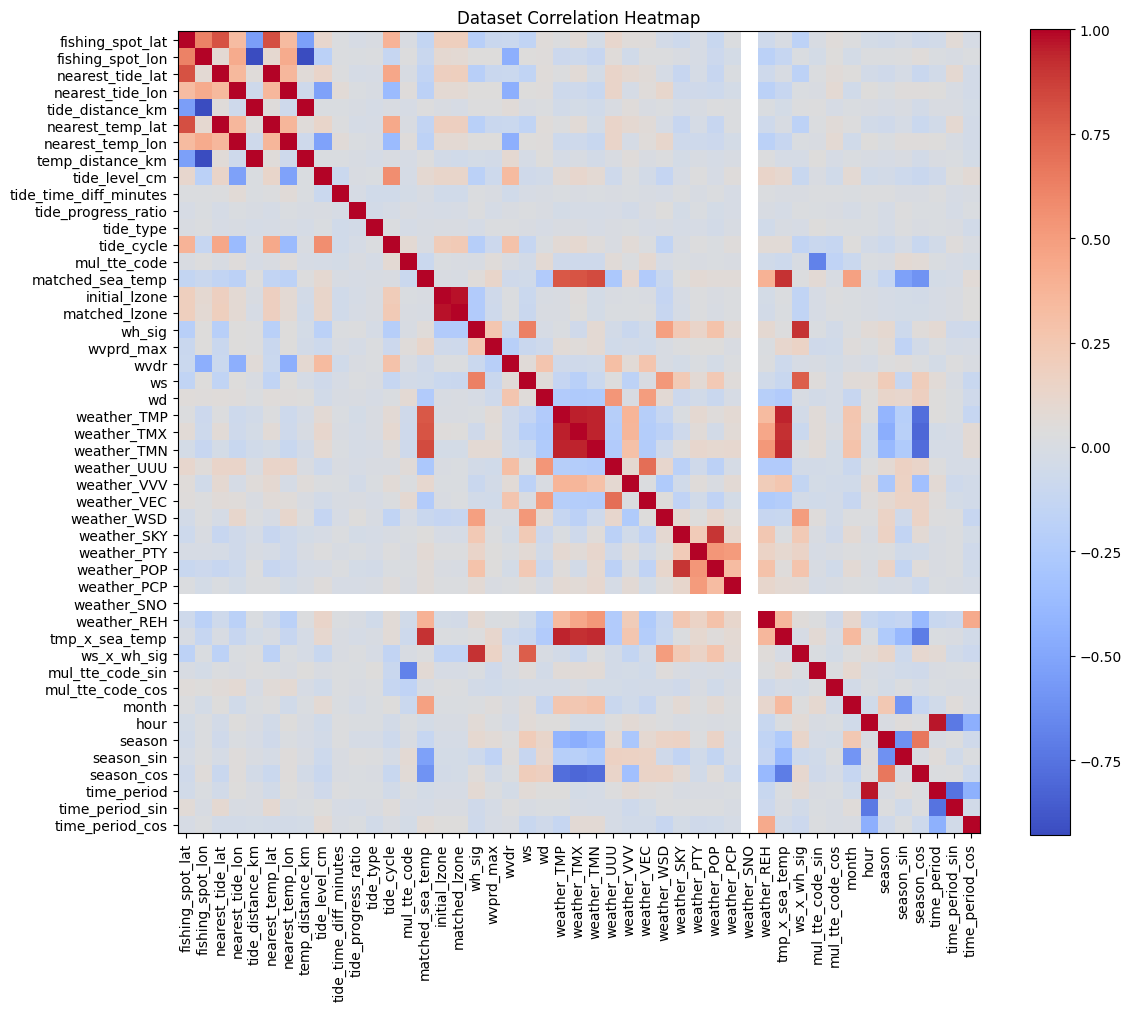


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

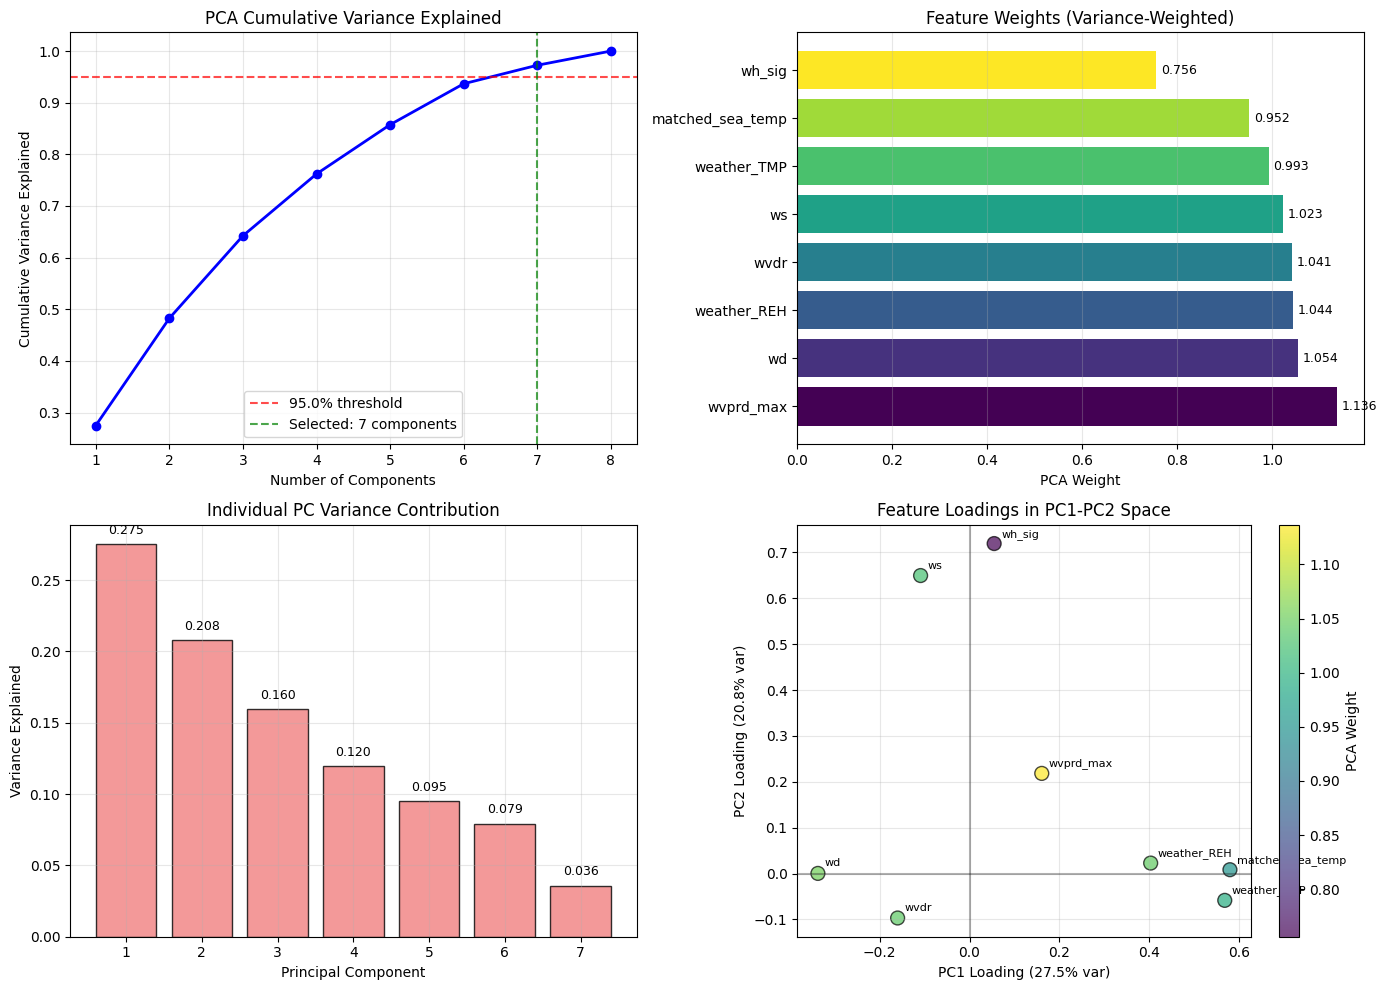

PCA WEIGHTS ANALYSIS RESULTS
Components used: 7
Total variance explained: 97.3%
Variance threshold: 95.0%

Top 5 Important Features:
  1. wvprd_max           : 1.1365
  2. wd                  : 1.0537
  3. weather_REH         : 1.0439
  4. wvdr                : 1.0413
  5. ws                  : 1.0234

Component Contributions:
  PC1: 27.5%
  PC2: 20.8%
  PC3: 16.0%
  PC4: 12.0%
  PC5: 9.5%
  PC6: 7.9%
  PC7: 3.6%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Epoch [20/500] Train Loss: 626.0121, Val Loss: 541.9396, Beta: 0.3758
  Early stopping at epoch 22
  Fold 1 validation reconstruction error: 0.397903

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 623.1223, Val Loss: 516.1372, Beta: 0.3758
  Early stopping at epoch 24
  Fold 2 validation reconstruction error: 0.370426

--- Fold 3 / 3 ---
  Epoch [20/500] Train Loss: 602.0010, Val Loss: 526.7083, Beta: 0.3758
  Early stopping at epoch 21
  Fold 3 validation r

c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sa

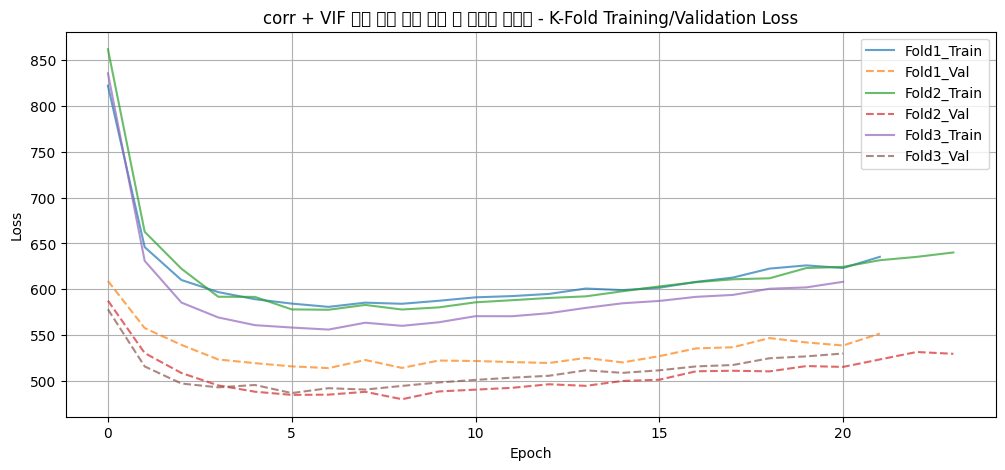


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 4.3674, Val Loss: 3.7867, Beta: 0.2306
Epoch [20/500] Train Loss: 4.7079, Val Loss: 4.0489, Beta: 0.3758
Final model: Early stopping at epoch 20 (No improvement for 15 epochs)


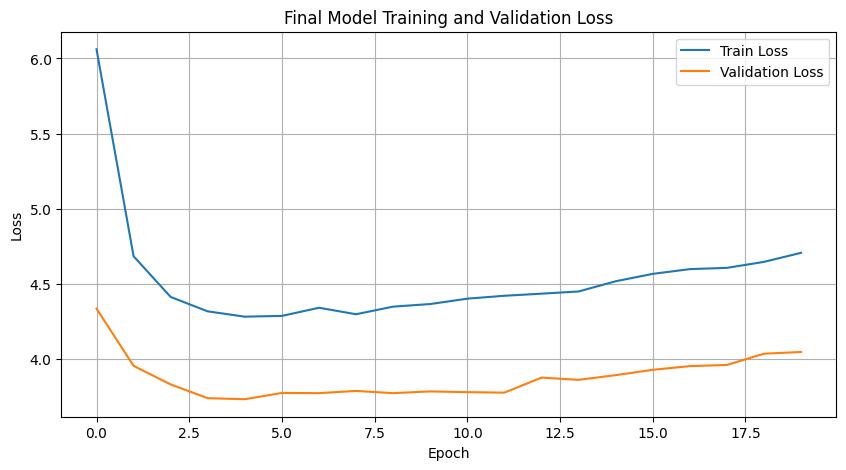


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.392605

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.260223
  - Std: 0.439503
  - Min: 0.651754
  - Max: 3.679595
  - Median: 1.164462
  - 25th percentile: 0.951499
  - 75th percentile: 1.452593
  - 95th percentile: 1.993900

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.431601
  - Std: 0.617390
  - Min: 0.647292
  - Max: 5.866134
  - Median: 1.326953

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.171378
  - Ratio (Anomaly/Normal): 1.136

>>> Final Model Discriminative Power (AUC Score): 0.588139


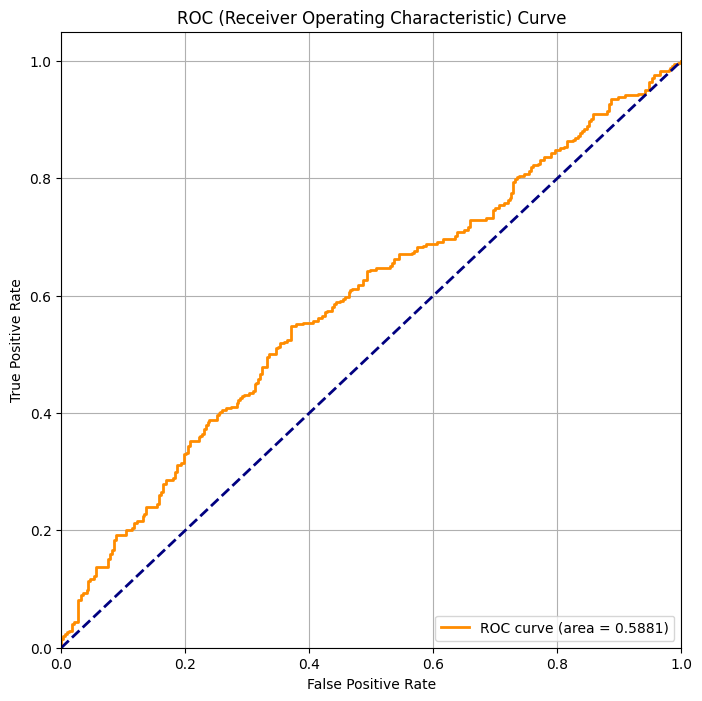

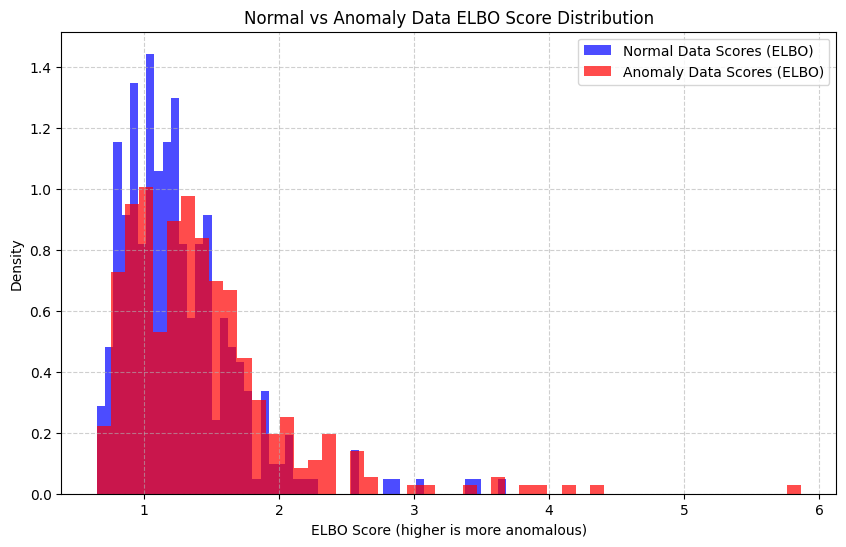

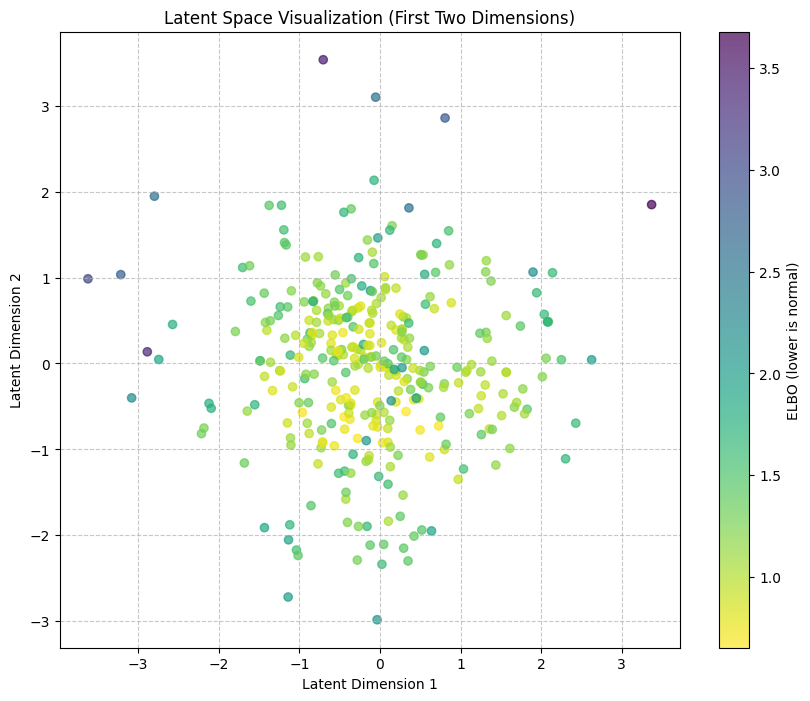


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 1.993900
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%

Model and preprocessing objects saved:
  - Model: ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_improved_vae_model.pth
  - Imputer: ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_imputer.pkl
  - Scaler: ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_scaler.pkl

===== Full Dataset ELBO Score Analysis =====
Full dataset ELBO scores:
  - Mean: 1.233367
  - Std: 0.451207
  - Min: 0.592270
  - Max: 5.047462
  - Median: 1.129271
  - 95th percentile: 2.059721
  - 99th percentile: 3.079807
  - Result file: ./result_corr + VIF 점수 기반 변수 삭제 후 선택된 변수들.csv

===== Final Performance Summary =====
K-Fold CV average reconstruction error: 0.383521
Test data average reconstruction error (MSE): 0.392605
Test data average ELBO score: 1.260223
Final model AUC Score: 0.588139
Anomaly detection threshold (95 percentile): 1.993900
Detected anomalies: 18 / Total 

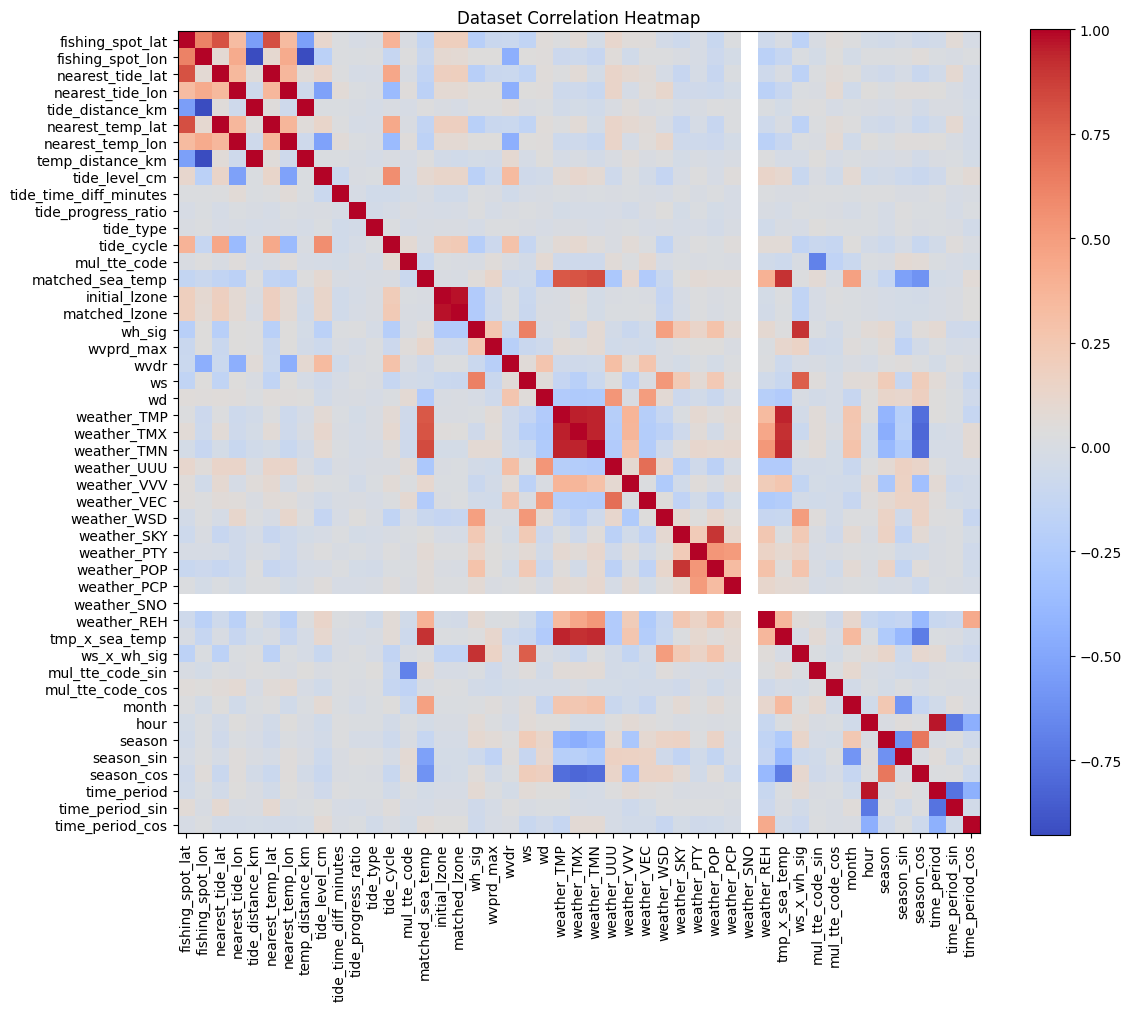


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

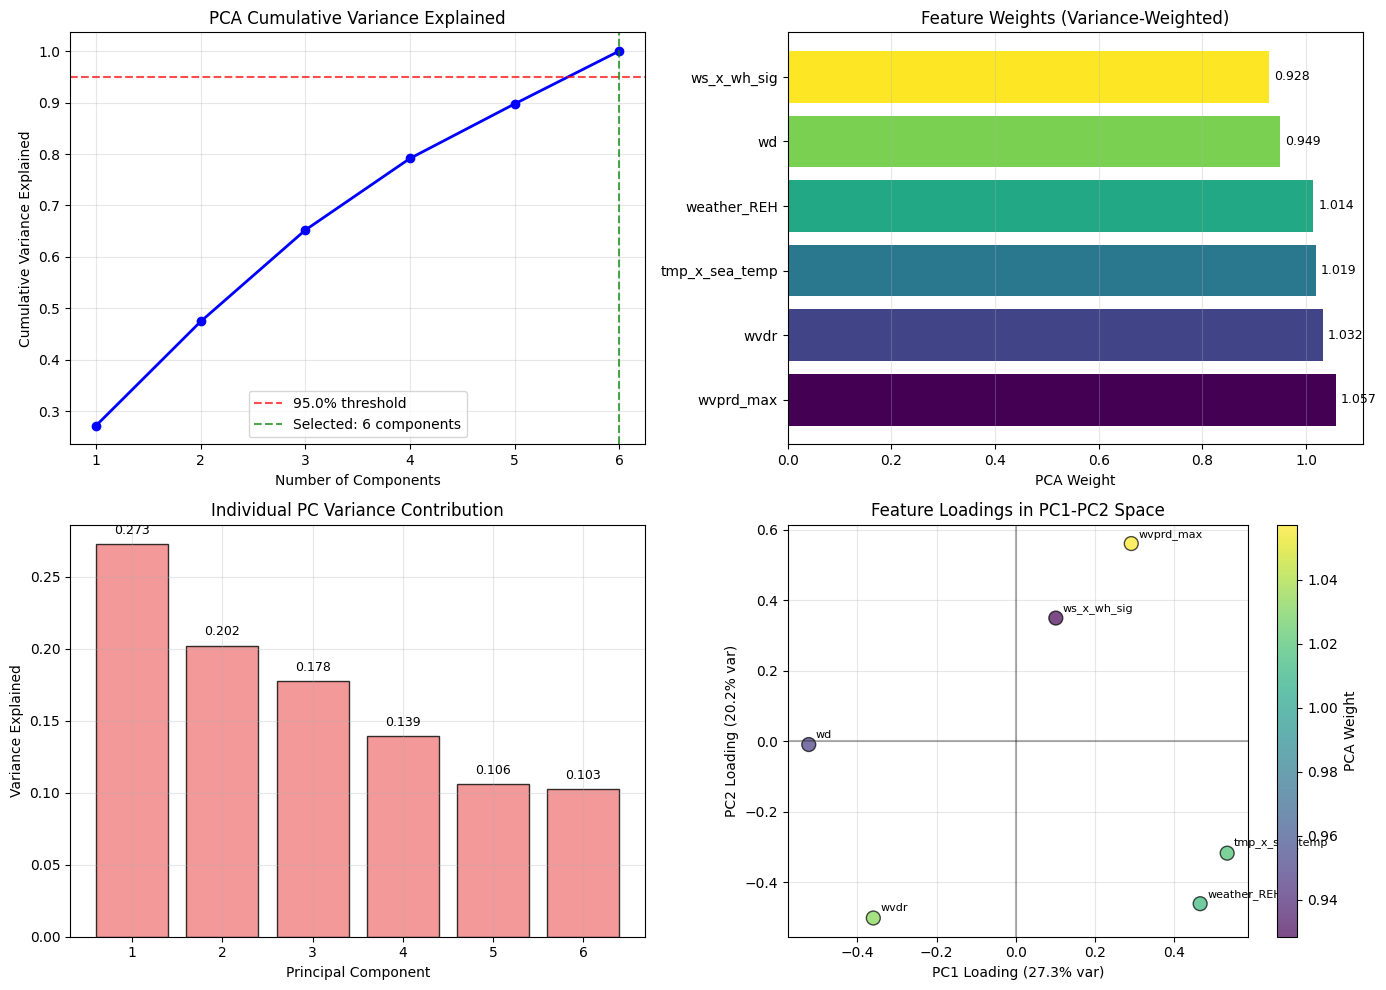

PCA WEIGHTS ANALYSIS RESULTS
Components used: 6
Total variance explained: 100.0%
Variance threshold: 95.0%

Top 5 Important Features:
  1. wvprd_max           : 1.0571
  2. wvdr                : 1.0321
  3. tmp_x_sea_temp      : 1.0190
  4. weather_REH         : 1.0139
  5. wd                  : 0.9494

Component Contributions:
  PC1: 27.3%
  PC2: 20.2%
  PC3: 17.8%
  PC4: 13.9%
  PC5: 10.6%
  PC6: 10.3%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Early stopping at epoch 19
  Fold 1 validation reconstruction error: 0.346804

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 452.1977, Val Loss: 360.2659, Beta: 0.3758
  Early stopping at epoch 21
  Fold 2 validation reconstruction error: 0.303382

--- Fold 3 / 3 ---
  Early stopping at epoch 19
  Fold 3 validation reconstruction error: 0.345689

K-Fold average validation reconstruction error: 0.331959


c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu 

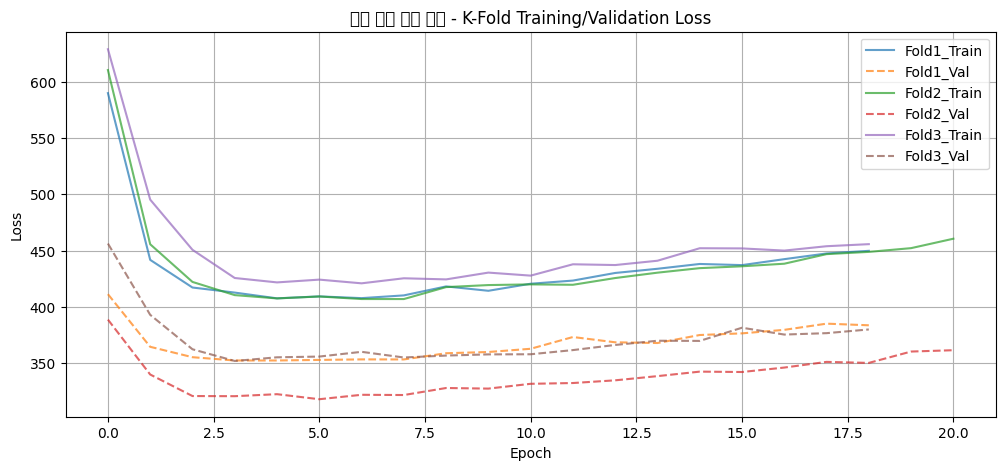


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 3.2665, Val Loss: 2.7322, Beta: 0.2306
Final model: Early stopping at epoch 19 (No improvement for 15 epochs)


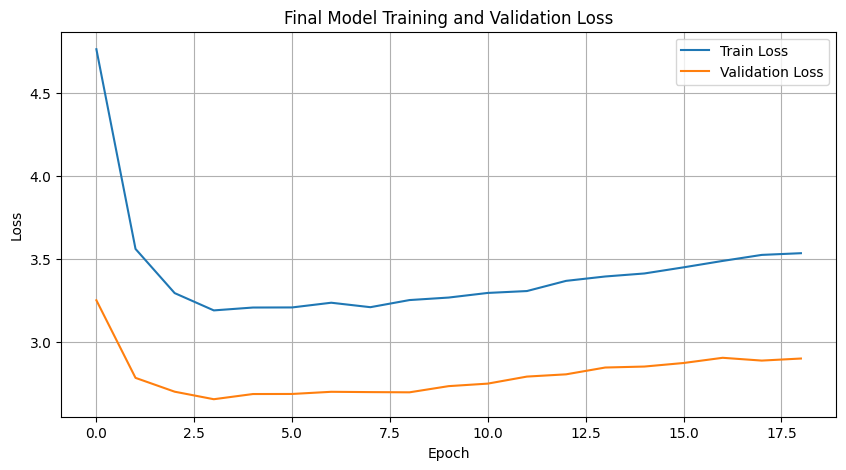


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.357751

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.091821
  - Std: 0.470778
  - Min: 0.572134
  - Max: 4.513913
  - Median: 0.988207
  - 25th percentile: 0.794939
  - 75th percentile: 1.250839
  - 95th percentile: 1.772228

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.259714
  - Std: 0.737141
  - Min: 0.576716
  - Max: 7.396805
  - Median: 1.095993

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.167893
  - Ratio (Anomaly/Normal): 1.154

>>> Final Model Discriminative Power (AUC Score): 0.581951


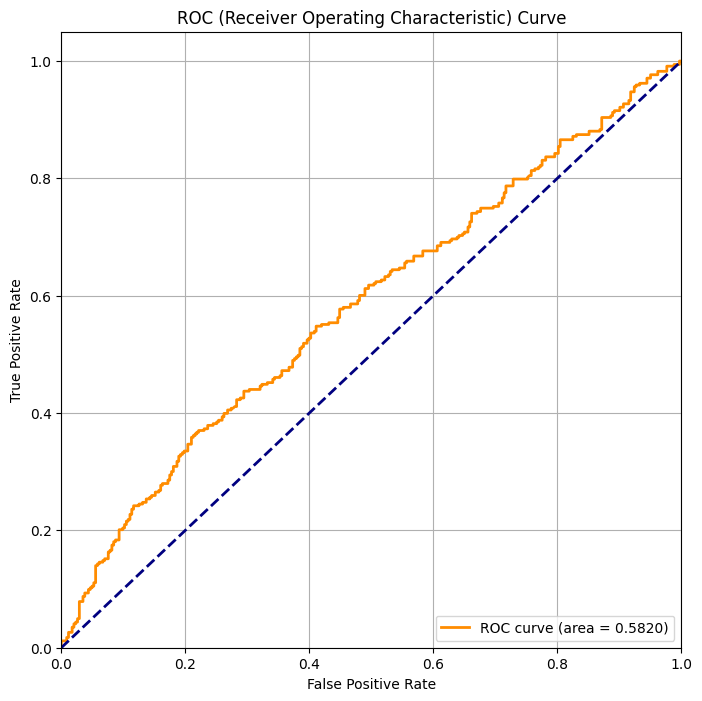

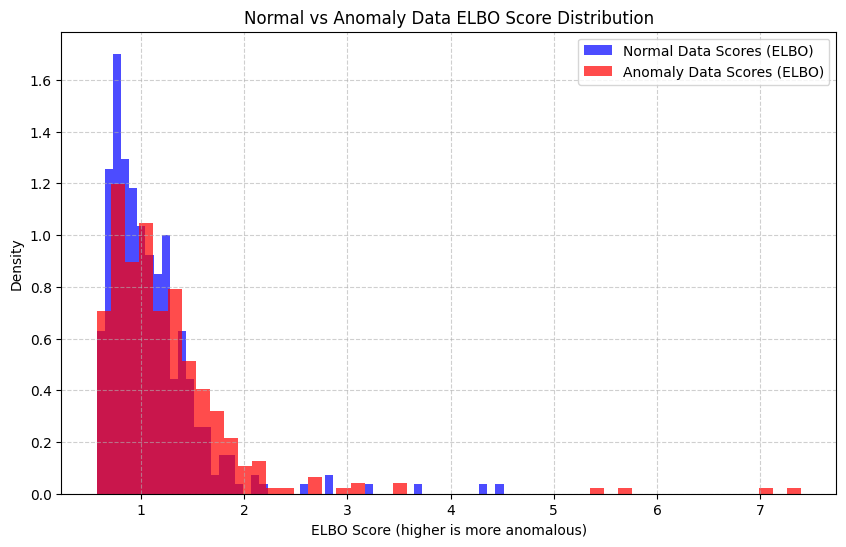

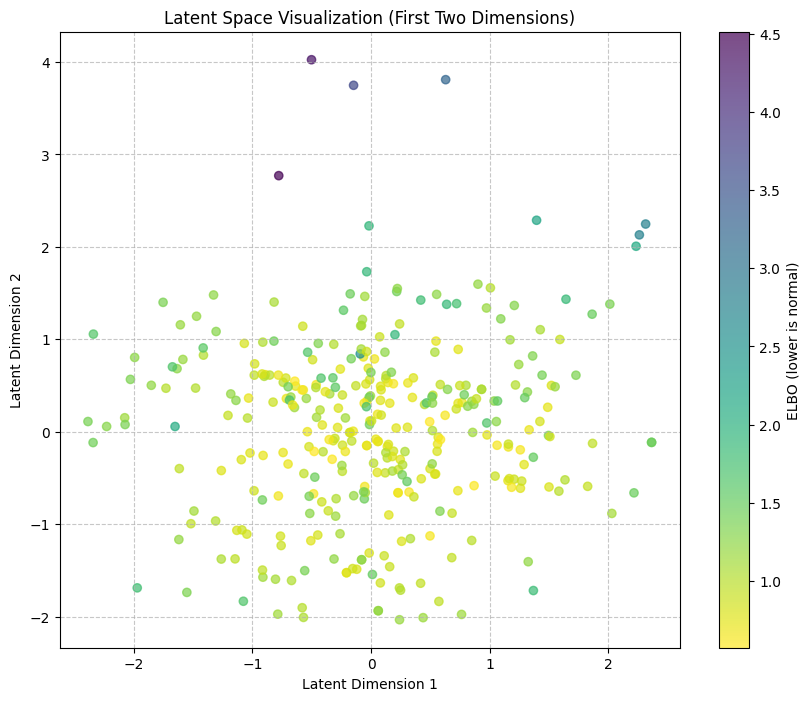


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 1.772228
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%

Model and preprocessing objects saved:
  - Model: ./models/상호 작용 변수 생성_improved_vae_model.pth
  - Imputer: ./models/상호 작용 변수 생성_imputer.pkl
  - Scaler: ./models/상호 작용 변수 생성_scaler.pkl

===== Full Dataset ELBO Score Analysis =====
Full dataset ELBO scores:
  - Mean: 1.076528
  - Std: 0.519835
  - Min: 0.528306
  - Max: 12.390671
  - Median: 0.951580
  - 95th percentile: 1.885049
  - 99th percentile: 3.232649
  - Result file: ./result_상호 작용 변수 생성.csv

===== Final Performance Summary =====
K-Fold CV average reconstruction error: 0.331959
Test data average reconstruction error (MSE): 0.357751
Test data average ELBO score: 1.091821
Final model AUC Score: 0.581951
Anomaly detection threshold (95 percentile): 1.772228
Detected anomalies: 18 / Total test samples: 343
Anomaly detection rate: 5.25%

3/7 experiment in progress...
Star

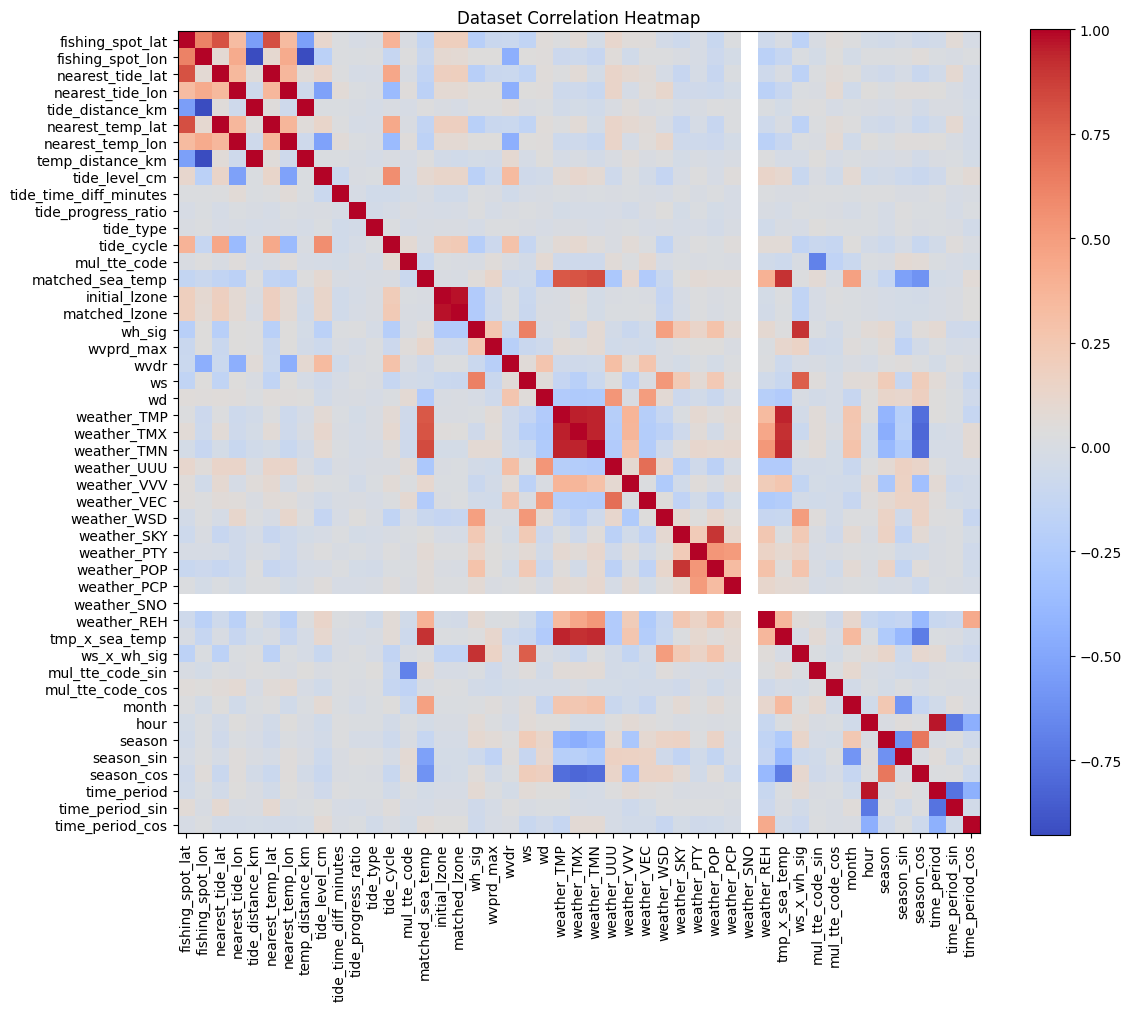


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

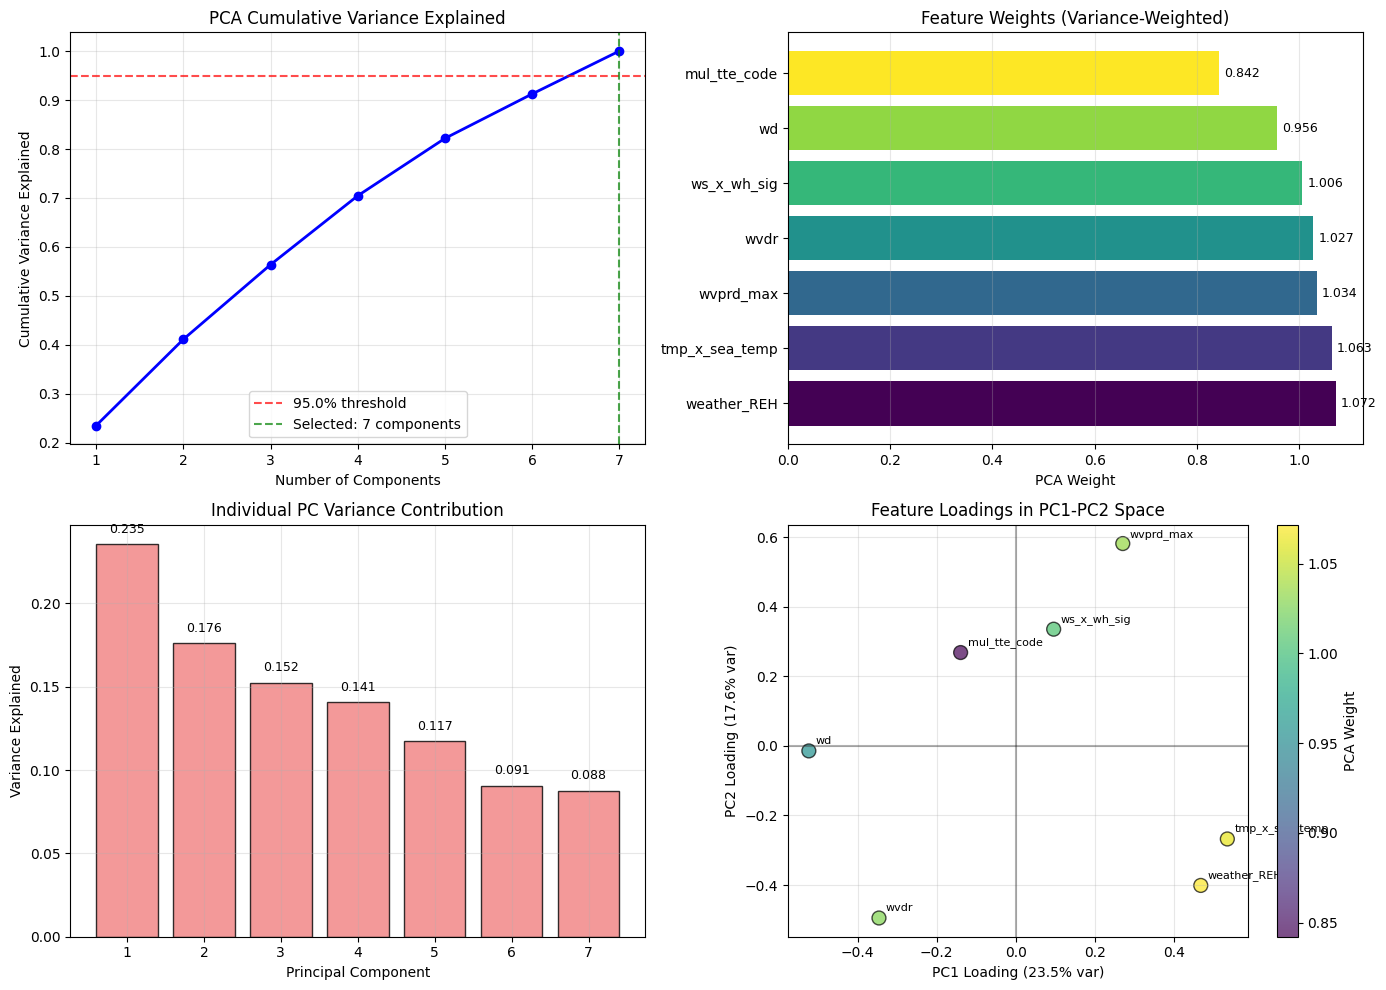

PCA WEIGHTS ANALYSIS RESULTS
Components used: 7
Total variance explained: 100.0%
Variance threshold: 95.0%

Top 5 Important Features:
  1. weather_REH         : 1.0716
  2. tmp_x_sea_temp      : 1.0630
  3. wvprd_max           : 1.0342
  4. wvdr                : 1.0268
  5. ws_x_wh_sig         : 1.0060

Component Contributions:
  PC1: 23.5%
  PC2: 17.6%
  PC3: 15.2%
  PC4: 14.1%
  PC5: 11.7%
  PC6: 9.1%
  PC7: 8.8%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Early stopping at epoch 19
  Fold 1 validation reconstruction error: 0.424285

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 578.0536, Val Loss: 491.9916, Beta: 0.3758
  Early stopping at epoch 22
  Fold 2 validation reconstruction error: 0.428253

--- Fold 3 / 3 ---
  Epoch [20/500] Train Loss: 575.3992, Val Loss: 493.5778, Beta: 0.3758
  Early stopping at epoch 23
  Fold 3 validation reconstruction error: 0.427086

K-Fold average validation reconstructio

c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46412 (\N{HANGUL SYLLABLE DDAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


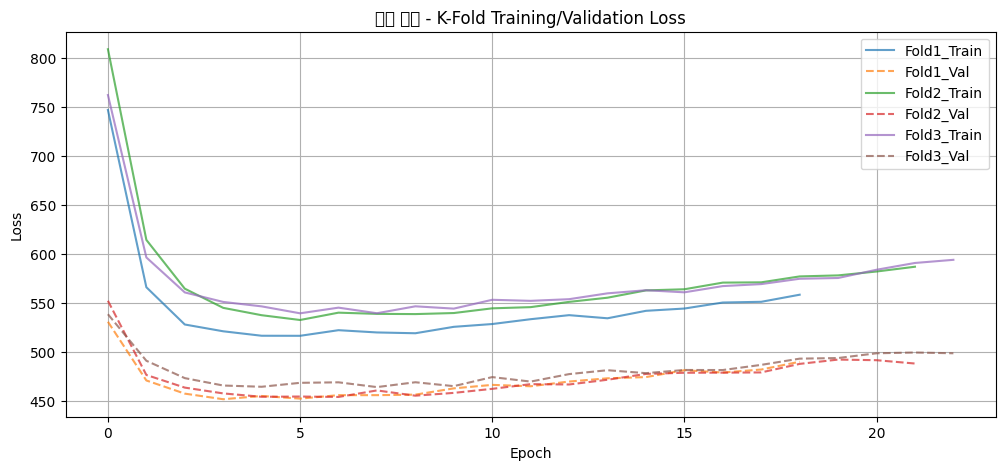


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 4.2356, Val Loss: 3.7069, Beta: 0.2306
Epoch [20/500] Train Loss: 4.4827, Val Loss: 3.8882, Beta: 0.3758
Final model: Early stopping at epoch 22 (No improvement for 15 epochs)


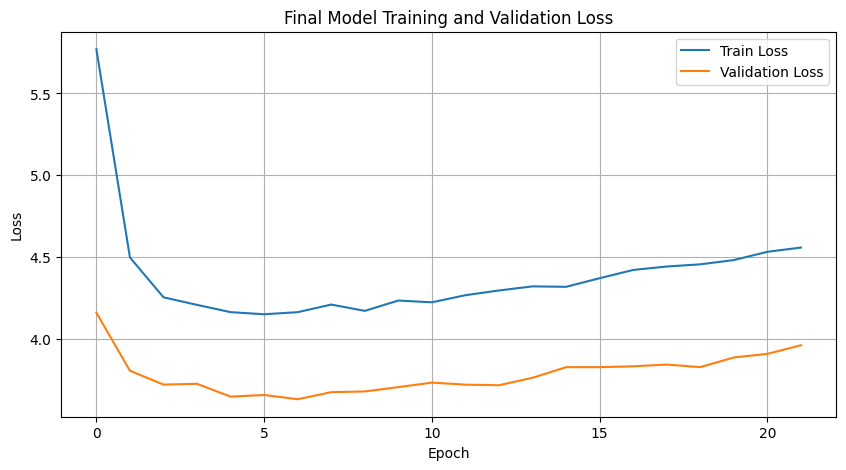


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.436870

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.165414
  - Std: 0.457382
  - Min: 0.552267
  - Max: 4.006623
  - Median: 1.064292
  - 25th percentile: 0.877351
  - 75th percentile: 1.328307
  - 95th percentile: 1.906977

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.293967
  - Std: 0.621379
  - Min: 0.504728
  - Max: 5.639441
  - Median: 1.180928

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.128553
  - Ratio (Anomaly/Normal): 1.110

>>> Final Model Discriminative Power (AUC Score): 0.571514


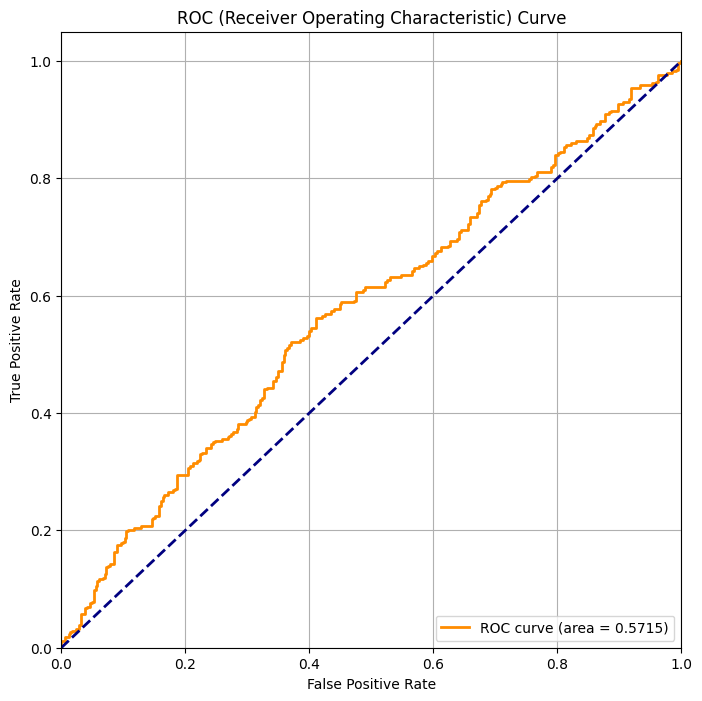

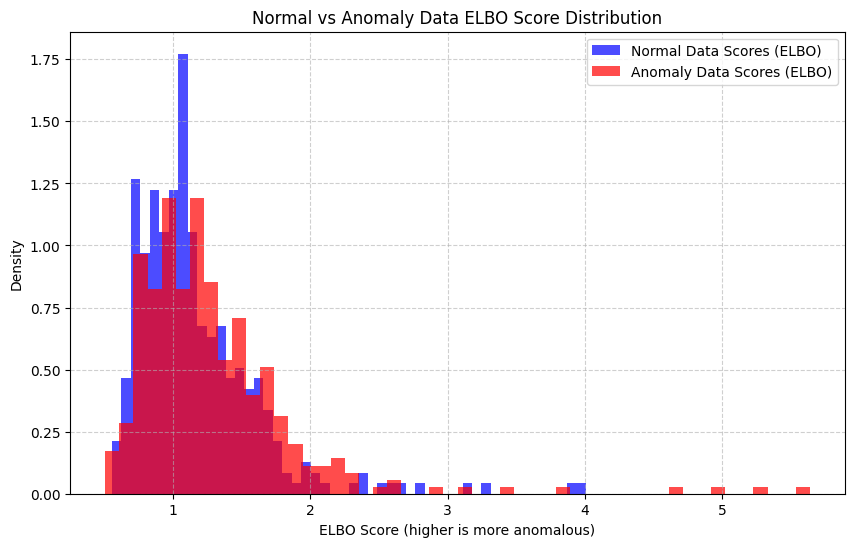

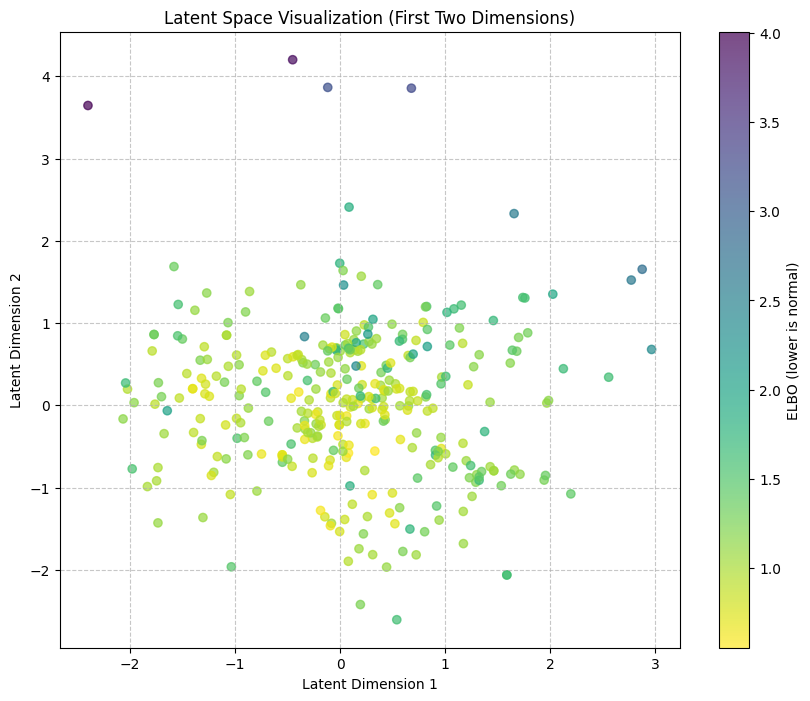


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 1.906977
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%

Model and preprocessing objects saved:
  - Model: ./models/물때 적용_improved_vae_model.pth
  - Imputer: ./models/물때 적용_imputer.pkl
  - Scaler: ./models/물때 적용_scaler.pkl

===== Full Dataset ELBO Score Analysis =====
Full dataset ELBO scores:
  - Mean: 1.150048
  - Std: 0.489940
  - Min: 0.515308
  - Max: 11.027741
  - Median: 1.046595
  - 95th percentile: 1.944166
  - 99th percentile: 2.804203
  - Result file: ./result_물때 적용.csv

===== Final Performance Summary =====
K-Fold CV average reconstruction error: 0.426541
Test data average reconstruction error (MSE): 0.436870
Test data average ELBO score: 1.165414
Final model AUC Score: 0.571514
Anomaly detection threshold (95 percentile): 1.906977
Detected anomalies: 18 / Total test samples: 343
Anomaly detection rate: 5.25%

4/7 experiment in progress...
Starting correlation analysi

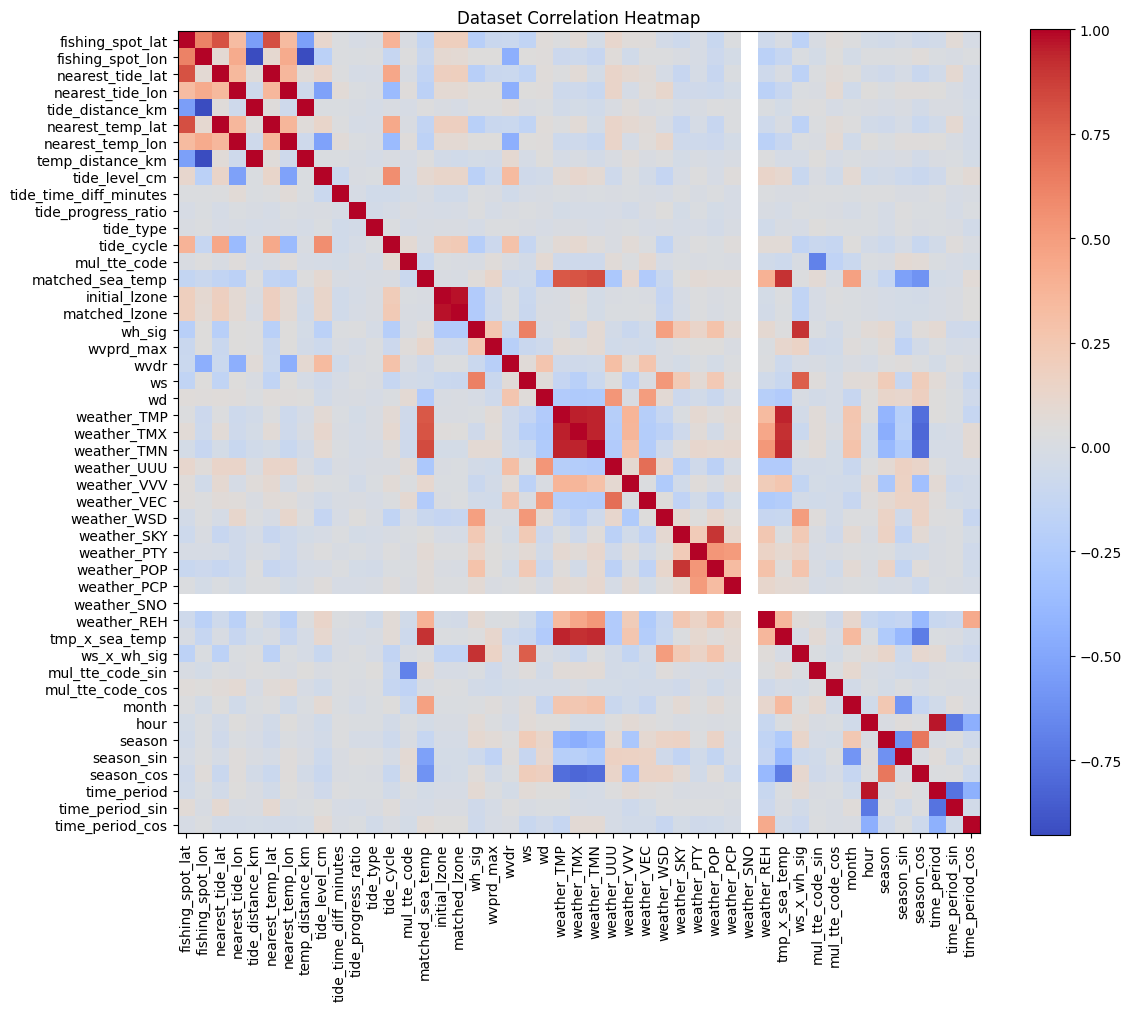


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

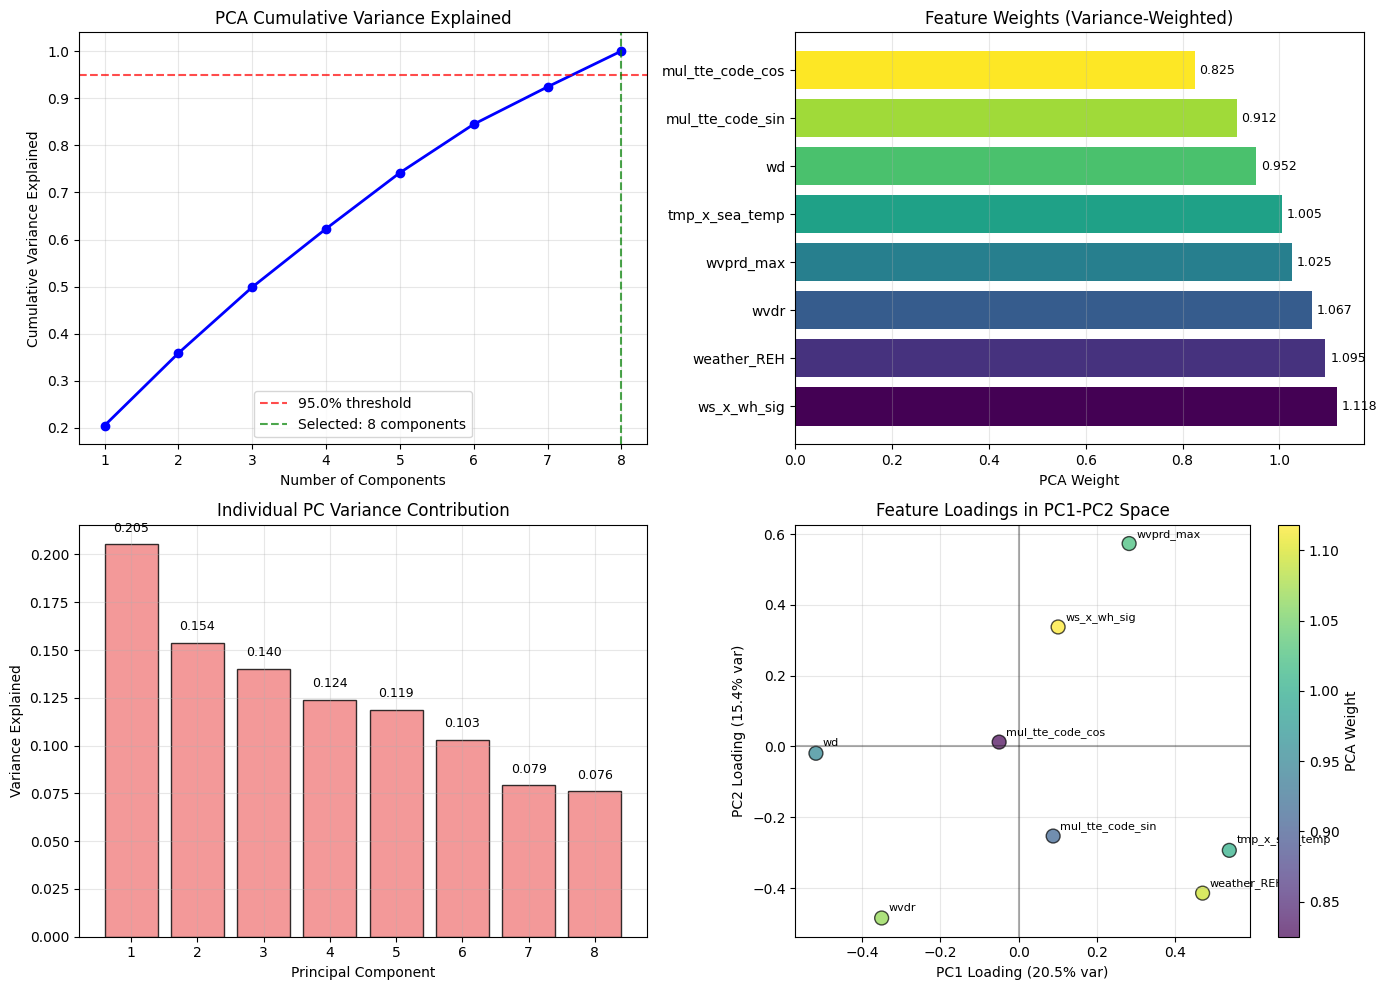

PCA WEIGHTS ANALYSIS RESULTS
Components used: 8
Total variance explained: 100.0%
Variance threshold: 95.0%

Top 5 Important Features:
  1. ws_x_wh_sig         : 1.1182
  2. weather_REH         : 1.0950
  3. wvdr                : 1.0669
  4. wvprd_max           : 1.0253
  5. tmp_x_sea_temp      : 1.0054

Component Contributions:
  PC1: 20.5%
  PC2: 15.4%
  PC3: 14.0%
  PC4: 12.4%
  PC5: 11.9%
  PC6: 10.3%
  PC7: 7.9%
  PC8: 7.6%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Epoch [20/500] Train Loss: 669.5074, Val Loss: 602.3685, Beta: 0.3758
  Early stopping at epoch 20
  Fold 1 validation reconstruction error: 0.492106

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 704.2886, Val Loss: 600.1144, Beta: 0.3758
  Early stopping at epoch 25
  Fold 2 validation reconstruction error: 0.492633

--- Fold 3 / 3 ---
  Epoch [20/500] Train Loss: 696.0858, Val Loss: 606.9779, Beta: 0.3758
  Early stopping at epoch 22
  Fold

c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46412 (\N{HANGUL SYLLABLE DDAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu San

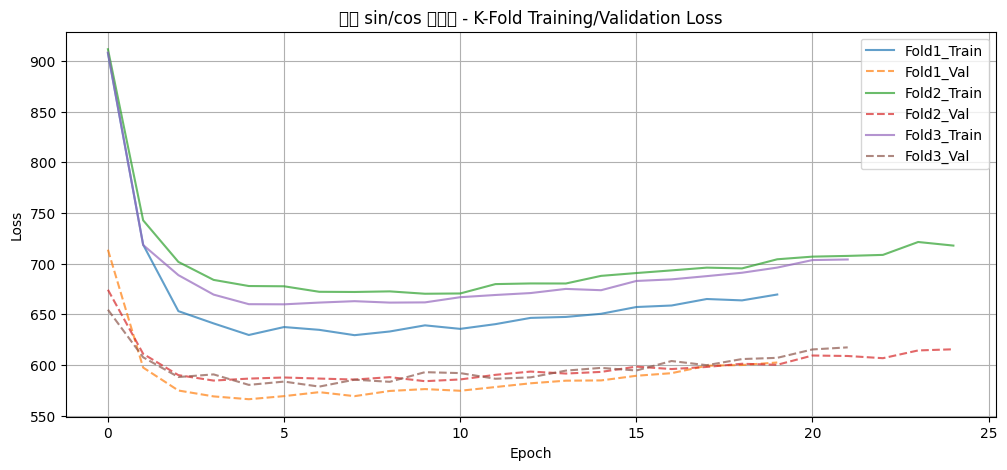


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 5.1129, Val Loss: 4.3700, Beta: 0.2306
Epoch [20/500] Train Loss: 5.3753, Val Loss: 4.5529, Beta: 0.3758
Final model: Early stopping at epoch 21 (No improvement for 15 epochs)


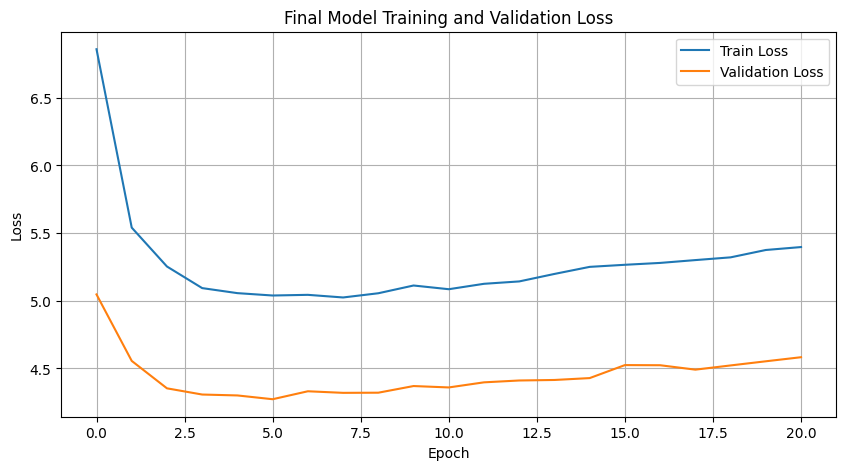


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.507516

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.301101
  - Std: 0.461775
  - Min: 0.741583
  - Max: 4.388824
  - Median: 1.202598
  - 25th percentile: 0.999679
  - 75th percentile: 1.464626
  - 95th percentile: 1.956619

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.379295
  - Std: 0.597141
  - Min: 0.718272
  - Max: 6.453978
  - Median: 1.289137

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.078195
  - Ratio (Anomaly/Normal): 1.060

>>> Final Model Discriminative Power (AUC Score): 0.551658


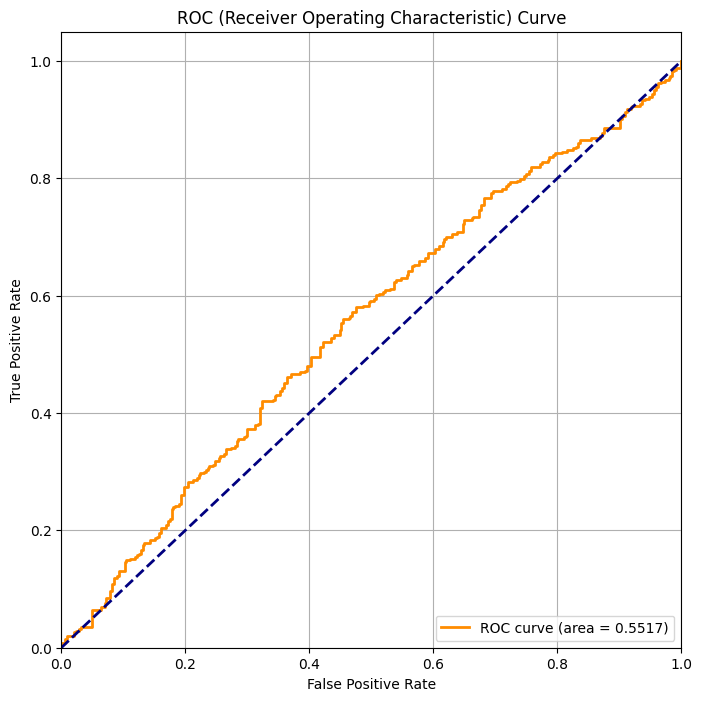

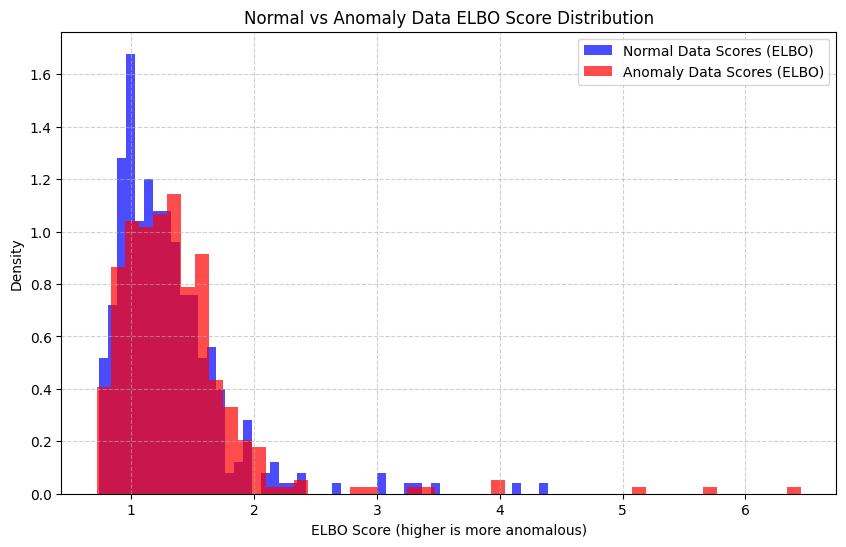

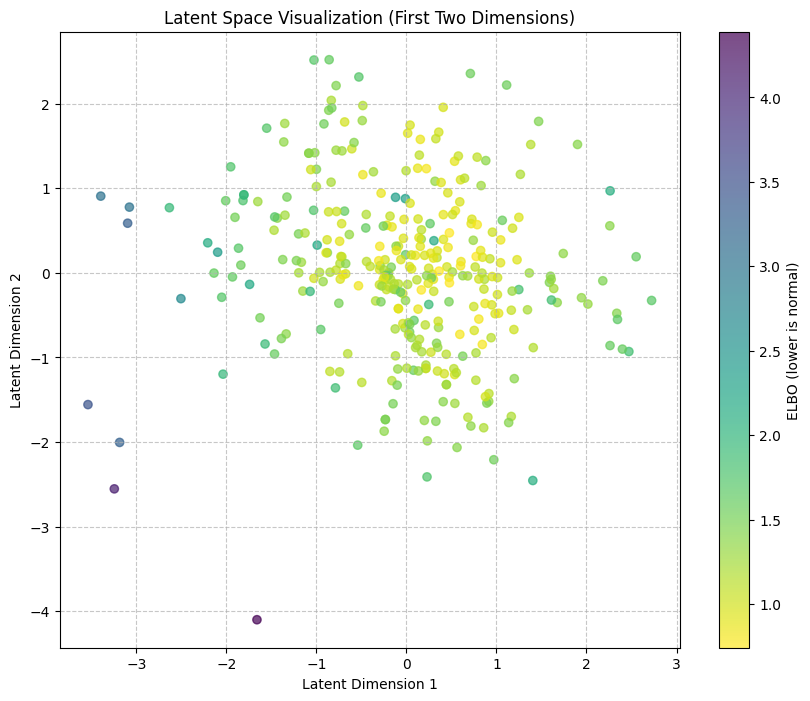


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 1.956619
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%
Error in experiment 물때 sin/cos 인코딩: [Errno 2] No such file or directory: './models/물때 sin/cos 인코딩_improved_vae_model.pth'

5/7 experiment in progress...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_

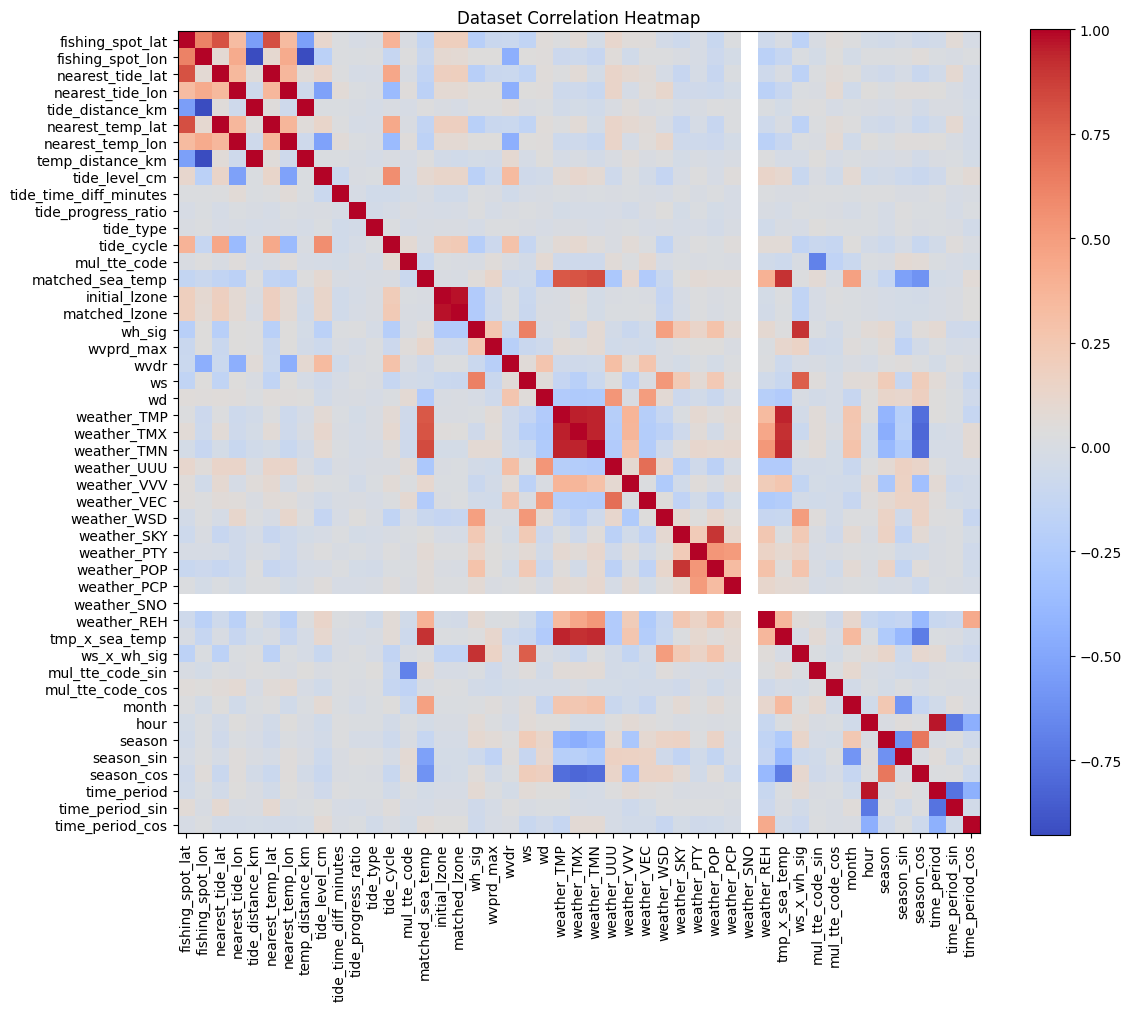


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

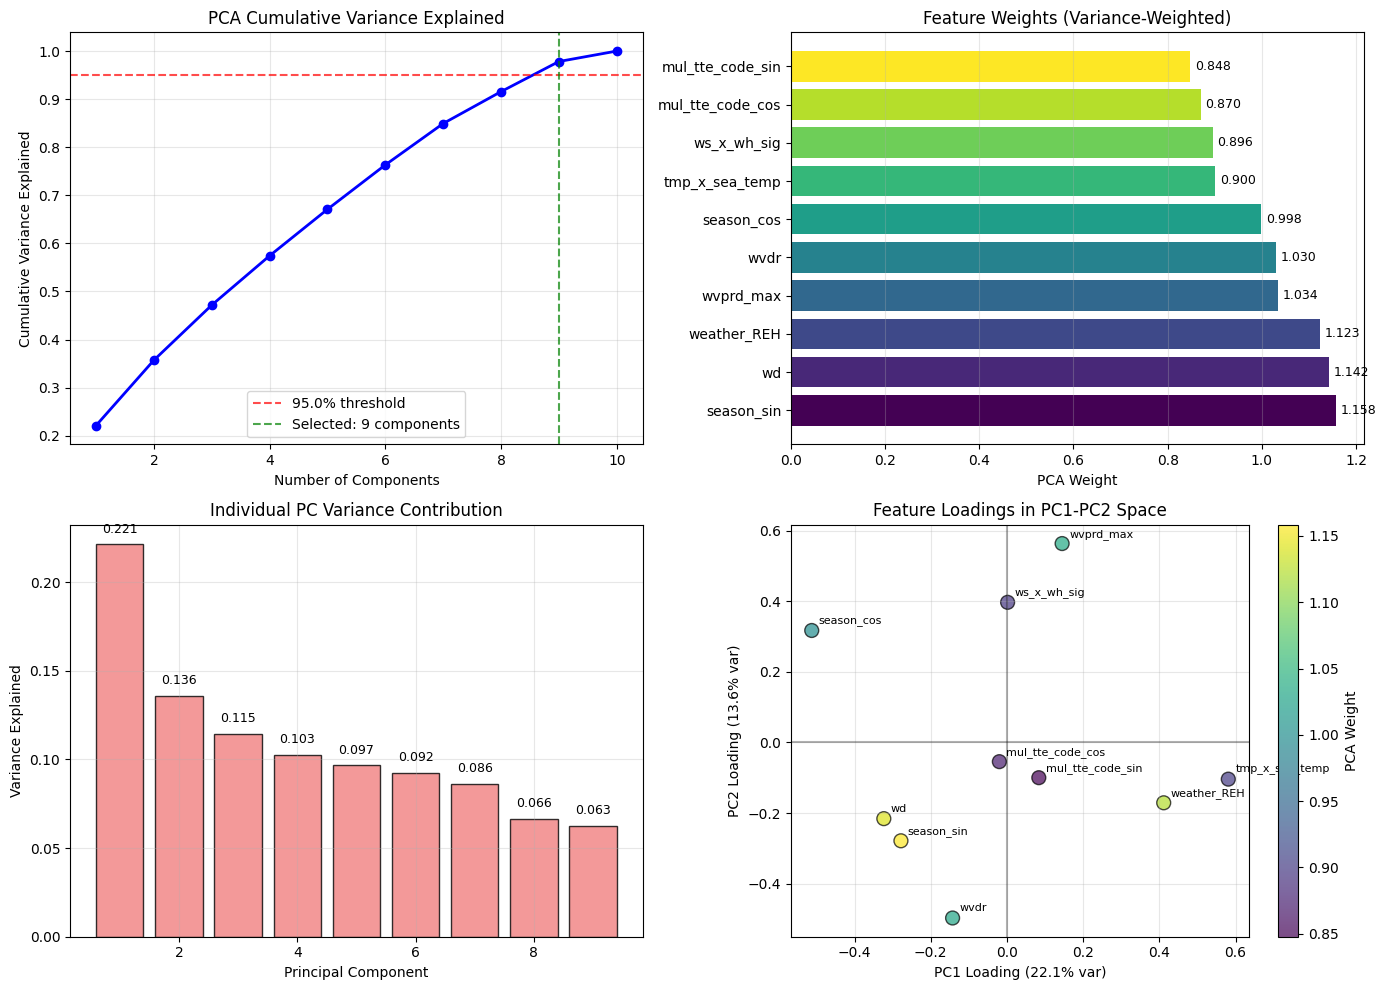

PCA WEIGHTS ANALYSIS RESULTS
Components used: 9
Total variance explained: 97.8%
Variance threshold: 95.0%

Top 5 Important Features:
  1. season_sin          : 1.1583
  2. wd                  : 1.1419
  3. weather_REH         : 1.1227
  4. wvprd_max           : 1.0343
  5. wvdr                : 1.0304

Component Contributions:
  PC1: 22.1%
  PC2: 13.6%
  PC3: 11.5%
  PC4: 10.3%
  PC5: 9.7%
  PC6: 9.2%
  PC7: 8.6%
  PC8: 6.6%
  PC9: 6.3%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Epoch [20/500] Train Loss: 829.4649, Val Loss: 745.8726, Beta: 0.3758
  Early stopping at epoch 26
  Fold 1 validation reconstruction error: 0.481419

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 841.2590, Val Loss: 718.3792, Beta: 0.3758
  Early stopping at epoch 27
  Fold 2 validation reconstruction error: 0.459890

--- Fold 3 / 3 ---
  Epoch [20/500] Train Loss: 831.3164, Val Loss: 723.1316, Beta: 0.3758
  Early stopping at epoch 

c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


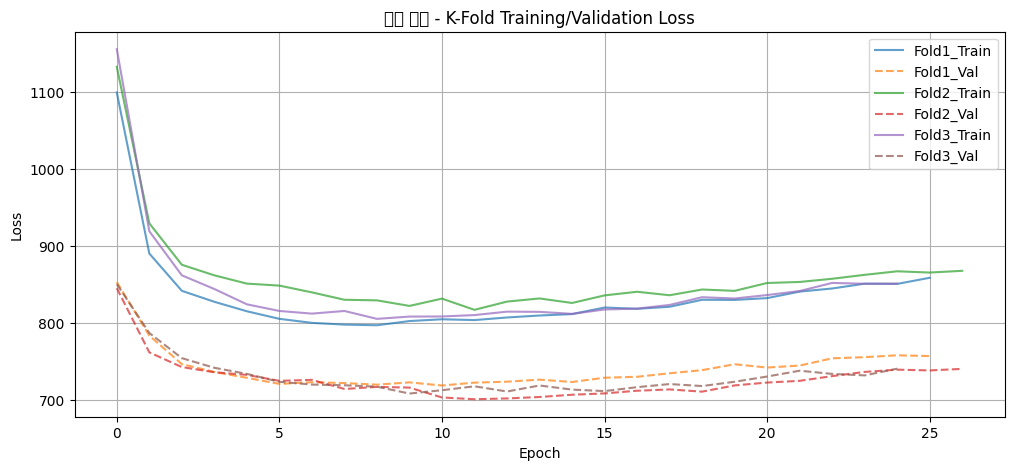


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 6.0925, Val Loss: 5.3205, Beta: 0.2306
Epoch [20/500] Train Loss: 6.3636, Val Loss: 5.4678, Beta: 0.3758
Final model: Early stopping at epoch 25 (No improvement for 15 epochs)


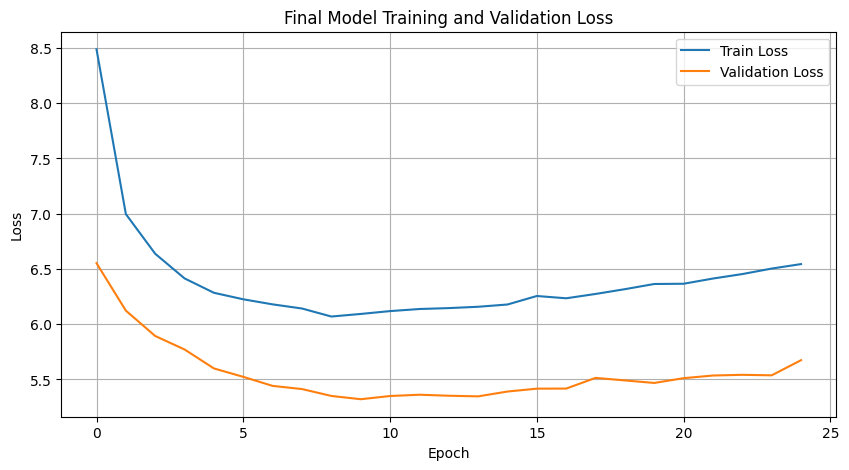


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.461094

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.415648
  - Std: 0.405429
  - Min: 0.909925
  - Max: 4.122192
  - Median: 1.327345
  - 25th percentile: 1.157750
  - 75th percentile: 1.527001
  - 95th percentile: 2.059327

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.681039
  - Std: 0.530280
  - Min: 0.946787
  - Max: 5.836884
  - Median: 1.585004

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.265391
  - Ratio (Anomaly/Normal): 1.187

>>> Final Model Discriminative Power (AUC Score): 0.708676


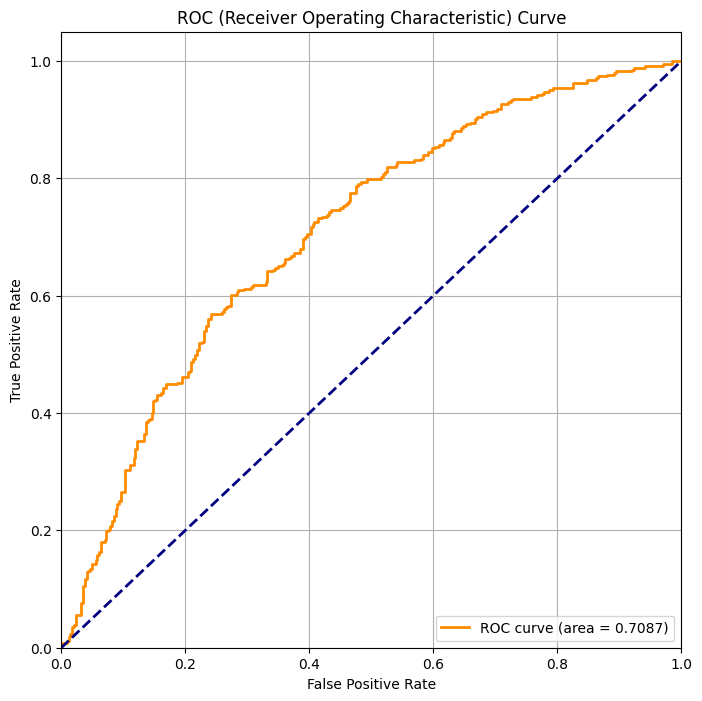

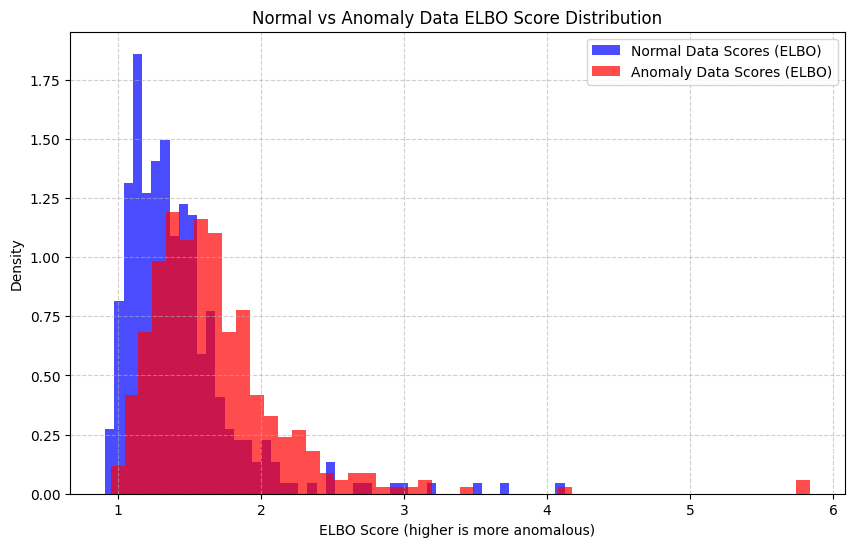

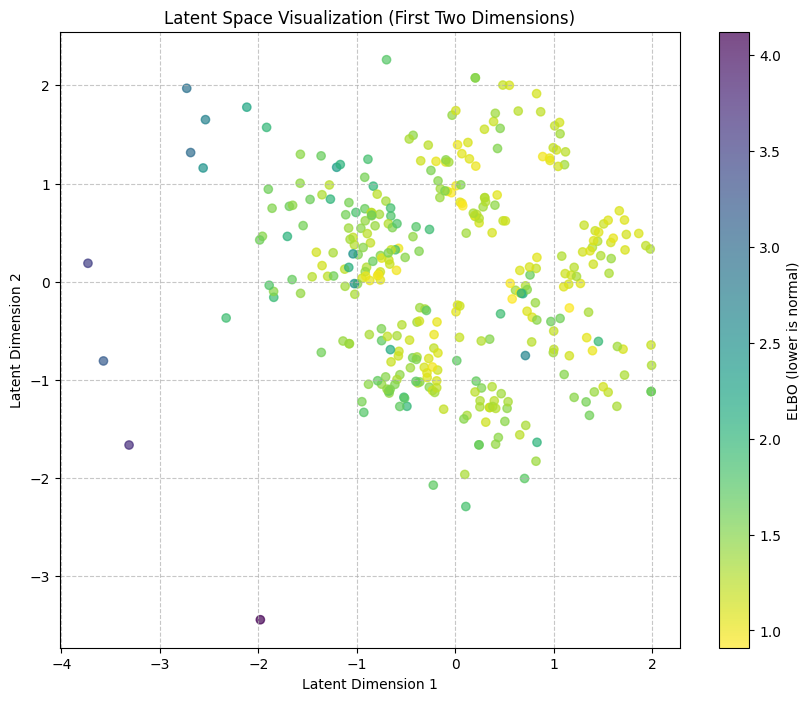


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 2.059327
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%

Model and preprocessing objects saved:
  - Model: ./models/계절 추가_improved_vae_model.pth
  - Imputer: ./models/계절 추가_imputer.pkl
  - Scaler: ./models/계절 추가_scaler.pkl

===== Full Dataset ELBO Score Analysis =====
Full dataset ELBO scores:
  - Mean: 1.381889
  - Std: 0.427122
  - Min: 0.823502
  - Max: 10.263955
  - Median: 1.280486
  - 95th percentile: 2.088146
  - 99th percentile: 2.933762
  - Result file: ./result_계절 추가.csv

===== Final Performance Summary =====
K-Fold CV average reconstruction error: 0.465079
Test data average reconstruction error (MSE): 0.461094
Test data average ELBO score: 1.415648
Final model AUC Score: 0.708676
Anomaly detection threshold (95 percentile): 2.059327
Detected anomalies: 18 / Total test samples: 343
Anomaly detection rate: 5.25%

6/7 experiment in progress...
Starting correlation analysi

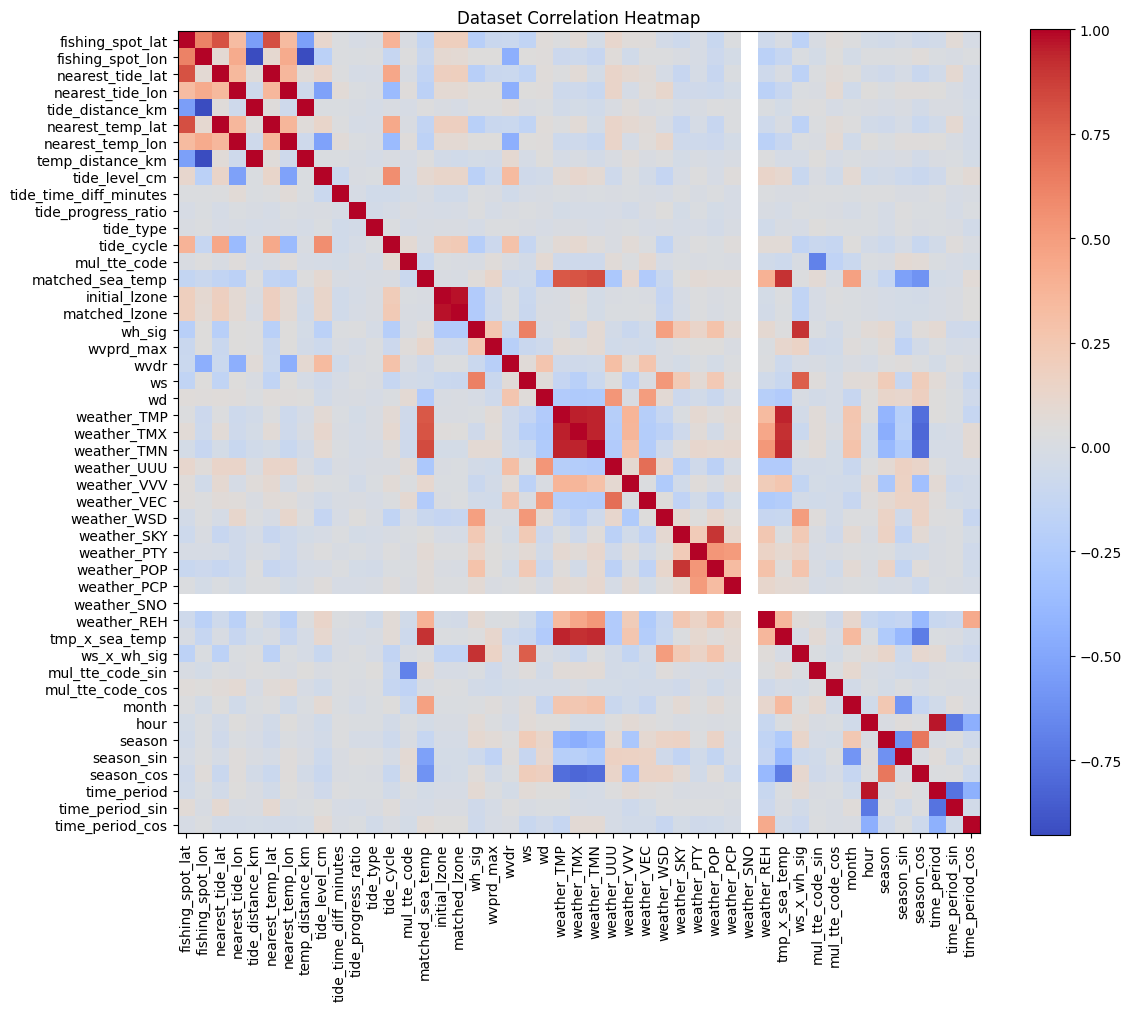


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

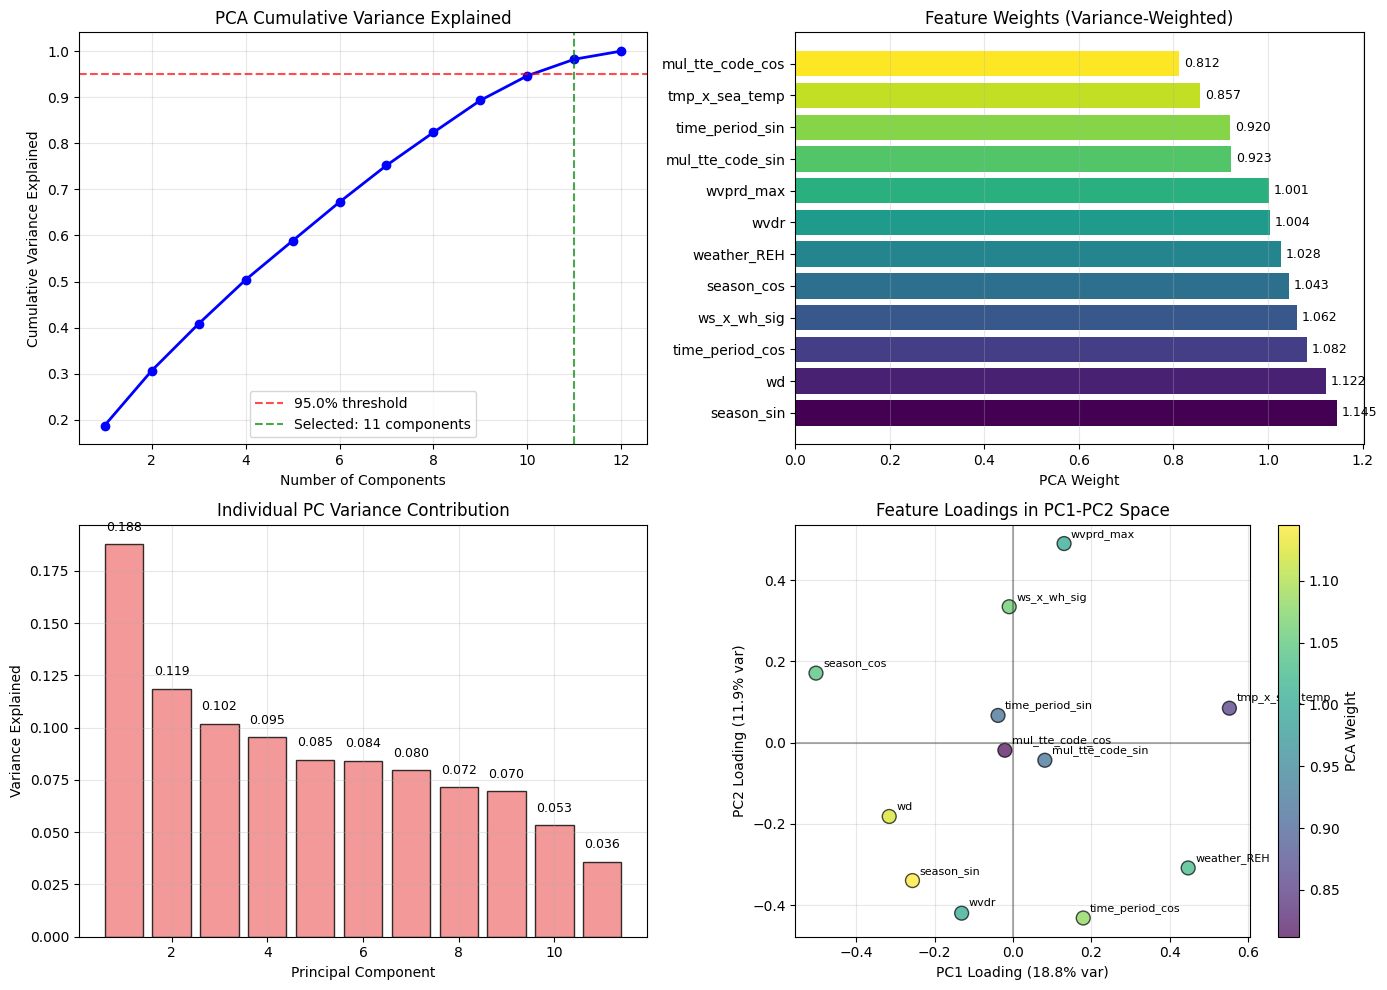

PCA WEIGHTS ANALYSIS RESULTS
Components used: 11
Total variance explained: 98.2%
Variance threshold: 95.0%

Top 5 Important Features:
  1. season_sin          : 1.1453
  2. wd                  : 1.1219
  3. time_period_cos     : 1.0819
  4. ws_x_wh_sig         : 1.0617
  5. season_cos          : 1.0434

Component Contributions:
  PC1: 18.8%
  PC2: 11.9%
  PC3: 10.2%
  PC4: 9.5%
  PC5: 8.5%
  PC6: 8.4%
  PC7: 8.0%
  PC8: 7.2%
  PC9: 7.0%
  PC10: 5.3%
  PC11: 3.6%
PCA weight calculation completed.
===== K-Fold Training with Early Stopping (Improved VAE) =====

--- Fold 1 / 3 ---
  Epoch [20/500] Train Loss: 1073.7318, Val Loss: 983.4114, Beta: 0.3758
  Early stopping at epoch 25
  Fold 1 validation reconstruction error: 0.559078

--- Fold 2 / 3 ---
  Epoch [20/500] Train Loss: 1051.9055, Val Loss: 916.1516, Beta: 0.3758
  Early stopping at epoch 29
  Fold 2 validation reconstruction error: 0.500326

--- Fold 3 / 3 ---
  Epoch [20/500] Train Loss: 1080.6545, Val Loss: 985.4676, Beta: 0.37

c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yeonri\.conda\envs\312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.


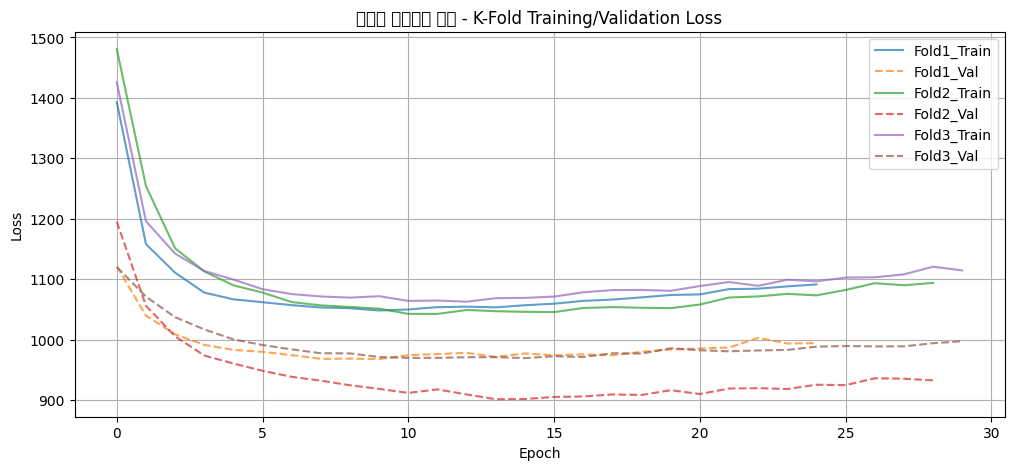


===== Final Model Training with Early Stopping (Improved VAE) =====
Epoch [10/500] Train Loss: 8.0795, Val Loss: 7.2612, Beta: 0.2306
Epoch [20/500] Train Loss: 8.2703, Val Loss: 7.3677, Beta: 0.3758
Final model: Early stopping at epoch 28 (No improvement for 15 epochs)


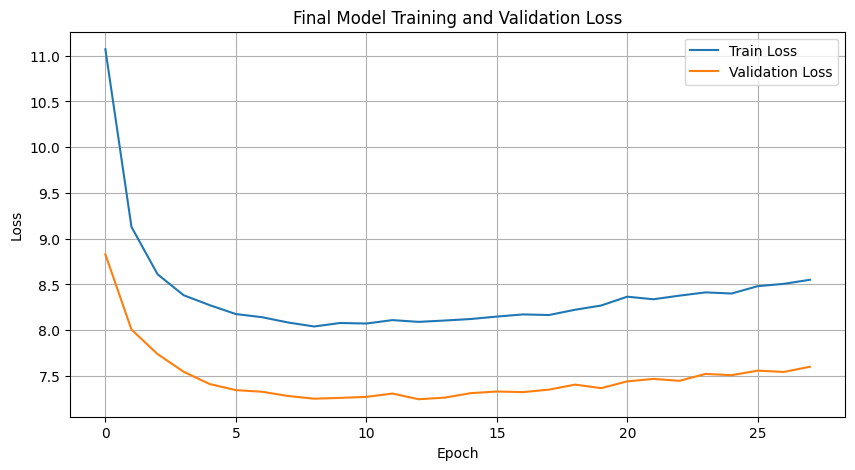


===== Test Data Evaluation =====
>>> Test Reconstruction Error (mean): 0.544234

===== ELBO Score Analysis (Normal Data) =====
Normal data ELBO scores:
  - Mean: 1.427015
  - Std: 0.337284
  - Min: 0.994107
  - Max: 3.878216
  - Median: 1.358640
  - 25th percentile: 1.228326
  - 75th percentile: 1.524216
  - 95th percentile: 1.962100

===== ELBO Score Analysis (Anomaly Data) =====
Anomaly data ELBO scores:
  - Mean: 1.633382
  - Std: 0.581021
  - Min: 1.007895
  - Max: 7.506311
  - Median: 1.538910

===== ELBO Score Comparison =====
Normal vs Anomaly ELBO difference:
  - Mean difference: 0.206367
  - Ratio (Anomaly/Normal): 1.145

>>> Final Model Discriminative Power (AUC Score): 0.679568


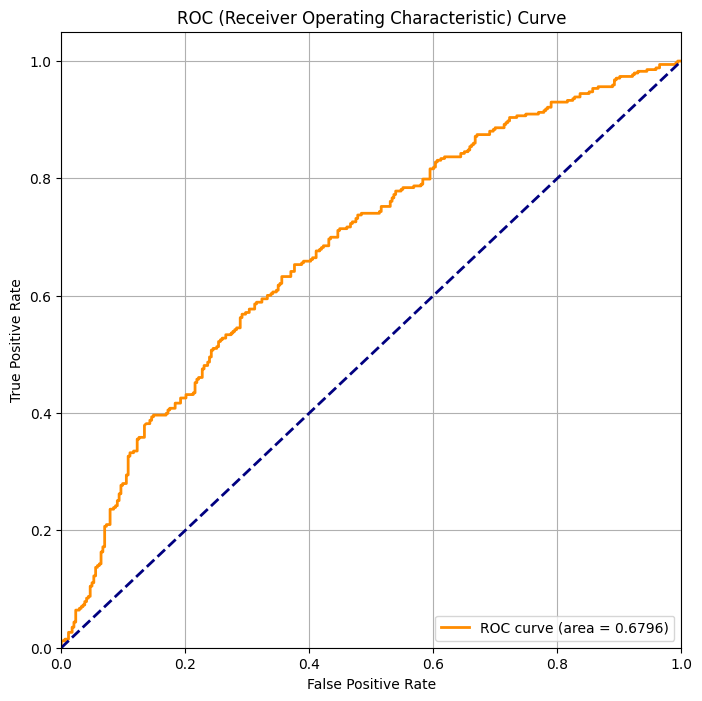

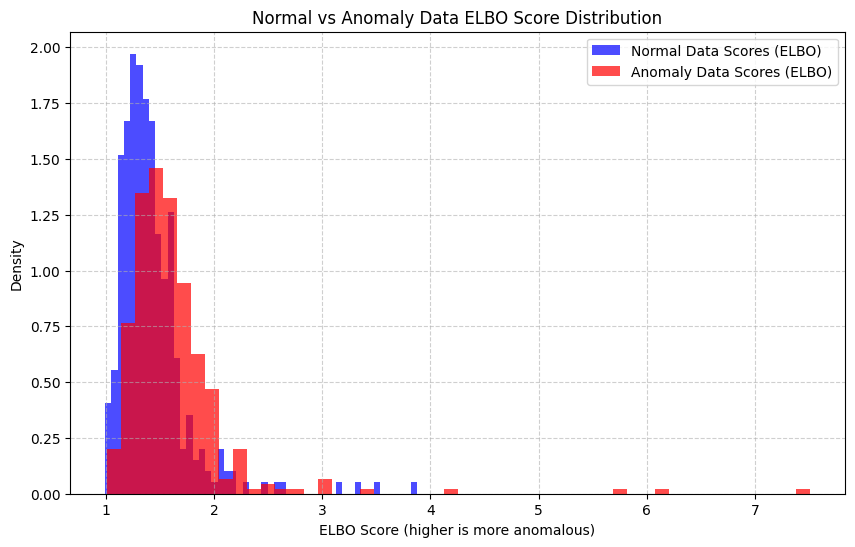

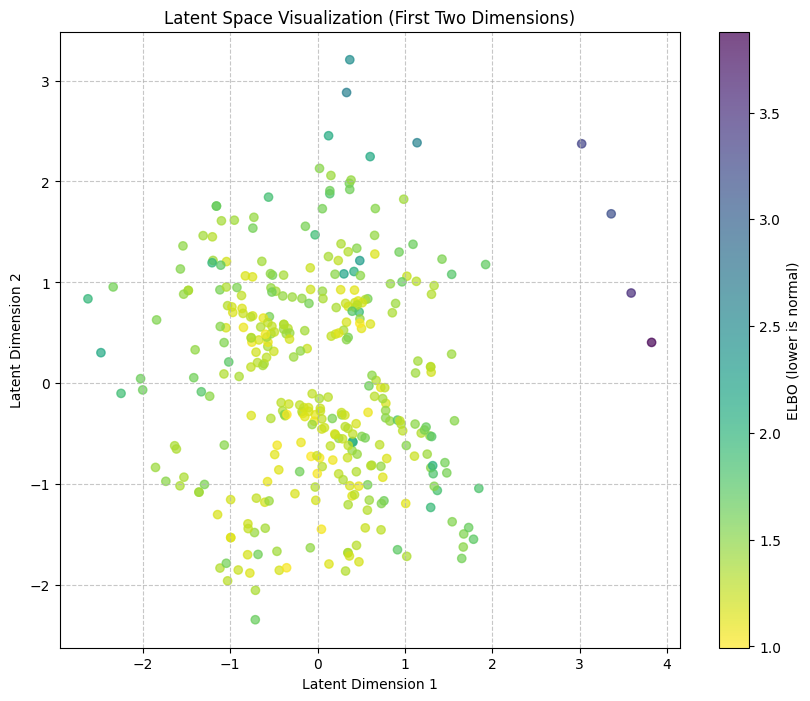


===== ELBO Threshold Analysis =====
ELBO threshold (95th percentile): 1.962100
Number of samples above threshold: 18
Threshold-based anomaly detection rate: 5.25%

Model and preprocessing objects saved:
  - Model: ./models/시간대 추가물때 제거_improved_vae_model.pth
  - Imputer: ./models/시간대 추가물때 제거_imputer.pkl
  - Scaler: ./models/시간대 추가물때 제거_scaler.pkl

===== Full Dataset ELBO Score Analysis =====
Full dataset ELBO scores:
  - Mean: 1.409880
  - Std: 0.387511
  - Min: 0.924670
  - Max: 11.205568
  - Median: 1.329254
  - 95th percentile: 1.968371
  - 99th percentile: 2.758861
  - Result file: ./result_시간대 추가물때 제거.csv

===== Final Performance Summary =====
K-Fold CV average reconstruction error: 0.536655
Test data average reconstruction error (MSE): 0.544234
Test data average ELBO score: 1.427015
Final model AUC Score: 0.679568
Anomaly detection threshold (95 percentile): 1.962100
Detected anomalies: 18 / Total test samples: 343
Anomaly detection rate: 5.25%

Improved VAE Experiment Results Co

In [6]:
df = pd.read_csv("./final_fish_data.csv")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]

df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)

df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)

df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour

df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 
                                            2 if 6 <= x <= 8 else 
                                            3 if 9 <= x <= 11 else 4)

df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)

df['time_period'] = df['hour'].apply(
    lambda x: 0 if 0 <= x < 6 else 
              1 if 6 <= x < 12 else 
              2 if 12 <= x < 18 else 
              3
)

df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_combinations = [
    
    # 원본 변수들
    ["weather_TMP", "matched_sea_temp", "ws", "wh_sig", "weather_REH", "wvprd_max" , "wvdr", "wd"],
    
    # 상호 작용 변수 생성
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd"],
    
    # 물때 적용
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code"],
    
    # 물때 sin/cos 인코딩 적용 -> 순환 주기를 제공
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos"],
    
    # 계절 추가 -> 계절은 순환주기로 sin/cos 인코딩
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos"],
    
    # 시간대 추가
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],
    
    # 물때 제거
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],

]

experiment_names = [
    "corr + VIF 점수 기반 변수 삭제 후 선택된 변수들", 
    "상호 작용 변수 생성", 
    "물때 적용", 
    "물때 sin/cos 인코딩",
    "계절 추가",
    "시간대 추가"
    "물때 제거"
]


comparison_df = compare_improved_vae_combinations(
    df=df,
    feature_combinations=feature_combinations,
    experiment_names=experiment_names
)


# PCA 제거

## 이유
- VAE 모델은 저차원 잠재 공간에서 데이터들의 고차원적이고 비선형적인 관계를 파악한다.
- PCA는 데이터들을 선형적으로 파악하여 차원을 축소하는 기법이다.
    - 비선형적인 특징들을 파악하지 못하고 분산의 크기를 이용하여 변수의 중요도를 파악한다.

## 가정
- PCA는 선형적인 특징들을 이용해서 중요도 값을 추출하며, 이를 VAE 모델의 오차 가중치로 사용하면 데이터들의 비선형성 관계에 대한 중요도가 무시되어 적용된다.
- 이로 인해 VAE 모델의 자체 학습에 악영향을 미칠 것이다.
- 모델의 차원이 낮은 초기의 VAE 모델은 차원이 낮았기 때문에 비선형적인 관계를 파악하여 학습을 충분히 하지 못하였을 것이며, PCA를 적용했을 때, 선형적인 관계에 대한 가중치를 이용하여 학습해야되는 주요 변수들에 적고 많은 가중치를 주어 비선형적인 관계의 중요도가 낮아져서 MSE와 ELBO 값이 높게 나왔을 것이다.

## 실험
- PCA를 적용하지 않고 학습을 진행하여 차이를 확인한다.

## 결과
- PCA를 적용하지 않은 모델이 확실하게 더 높은 AUC 값을 가지게 되었다.

## 결론
- PCA를 이용하여 주요 변수들의 중요도가 낮아졌기 때문에 각 변수들간의 비선형 적인 관계를 파악하여 학습하는데 악영향을 미쳤다.
- 비선형적 관계를 파악하기 위해 VAE 모델의 차원을 늘려서 각 데이터들관의 관계를 파악시키는게 중요하였다. 

In [ ]:
import joblib
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from typing import List, Tuple, Dict, Optional
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import product
import time

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # elif torch.backends.mps.is_available():
    #     return torch.device("mps")
    else:
        return torch.device("cpu")

def heatmap(df: pd.DataFrame, title: str = 'Correlation Heatmap'):
    plt.figure(figsize=(12, 10))
    corr = df.corr()
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def find_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.9) -> set:
    corr_matrix = df.corr().abs()
    highly_correlated_pairs = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                highly_correlated_pairs.add((colname, corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    return highly_correlated_pairs

def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=np.number).dropna()
    
    numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_df.dropna(inplace=True)

    constant_cols = [col for col in numeric_df.columns if numeric_df[col].nunique() <= 1]
    if constant_cols:
        numeric_df = numeric_df.drop(columns=constant_cols)

    if numeric_df.shape[1] < 2:
        return pd.DataFrame(columns=['Feature', 'VIF', 'priority_score'])

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    
    vif_values = []
    for i in range(numeric_df.shape[1]):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
        except Exception:
            vif = np.inf
        vif_values.append(vif)
        
    vif_data["VIF"] = vif_values

    vif_data['priority_score'] = vif_data['VIF'].apply(
        lambda x: 0 if np.isinf(x) else
                  1 if x >= 50 else
                  2 if x >= 20 else
                  3 if x >= 10 else
                  4 if x >= 5 else 5
    )

    vif_result = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    return vif_result

def analyze_data_correlation(df: pd.DataFrame, title_prefix: str = "Data"):
    print(f"\n{'='*60}")
    print(f"{title_prefix} Correlation Analysis")
    print(f"{'='*60}")
    
    df_numeric = df.select_dtypes(include=np.number)
    
    print(f"Number of numeric variables: {len(df_numeric.columns)}")
    print(f"Numeric variables: {list(df_numeric.columns)}")
    
    heatmap(df_numeric, title=f'{title_prefix} Correlation Heatmap')
    
    highly_correlated_features = find_highly_correlated_features(df_numeric, threshold=0.7)
    print(f"\nHighly correlated feature pairs (threshold=0.7):")
    if highly_correlated_features:
        for pair in sorted(highly_correlated_features, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  No highly correlated pairs found.")
    
    moderate_corr_features = find_highly_correlated_features(df_numeric, threshold=0.3)
    print(f"\nModerate correlation feature pairs (threshold=0.3):")
    if moderate_corr_features:
        moderate_only = moderate_corr_features - highly_correlated_features
        for pair in sorted(moderate_only, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  No moderate correlation pairs found.")
    
    print(f"\nVIF (Variance Inflation Factor) Analysis:")
    vif_result = calculate_vif(df_numeric)
    if not vif_result.empty:
        print(vif_result.to_string(index=False))
        
        high_vif = vif_result[vif_result['VIF'] >= 10]
        if not high_vif.empty:
            print(f"\nHigh VIF values (≥10) variables:")
            for _, row in high_vif.iterrows():
                print(f"  {row['Feature']}: {row['VIF']:.2f}")
        else:
            print(f"\nAll variables have VIF < 10.")
    else:
        print("  Insufficient data for VIF calculation.")
    
    return {
        'numeric_df': df_numeric,
        'high_corr': highly_correlated_features,
        'moderate_corr': moderate_corr_features,
        'vif_result': vif_result
    }

def compute_pca_weights(X: np.ndarray, variance_threshold: float = 0.95, feature_names: List[str] = None) -> torch.Tensor:
    pca_full = PCA()
    pca_full.fit(X)
    
    cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumsum_variance >= variance_threshold) + 1
    n_components = min(n_components, X.shape[1])
    
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    variance_ratios = pca.explained_variance_ratio_
    components_abs = np.abs(pca.components_)
    
    weighted_importance = np.zeros(X.shape[1])
    for i, (component, variance_ratio) in enumerate(zip(components_abs, variance_ratios)):
        weighted_importance += component * variance_ratio

    weights = weighted_importance * (len(weighted_importance) / np.sum(weighted_importance))
    
    if feature_names is not None:
        _visualize_pca_results(pca, pca_full, weights, feature_names, variance_threshold, n_components)
    
    return torch.tensor(weights, dtype=torch.float32)

def _visualize_pca_results(pca, pca_full, weights, feature_names, variance_threshold, n_components):
    
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(len(weights))]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    axes[0, 0].plot(range(1, len(cumsum_var)+1), cumsum_var, 'bo-', linewidth=2, markersize=6)
    axes[0, 0].axhline(y=variance_threshold, color='r', linestyle='--', alpha=0.7, 
                      label=f'{variance_threshold*100}% threshold')
    axes[0, 0].axvline(x=n_components, color='g', linestyle='--', alpha=0.7, 
                      label=f'Selected: {n_components} components')
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('Cumulative Variance Explained')
    axes[0, 0].set_title('PCA Cumulative Variance Explained')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    sorted_idx = np.argsort(weights)[::-1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(weights)))
    bars = axes[0, 1].barh(range(len(weights)), weights[sorted_idx], color=colors)
    axes[0, 1].set_yticks(range(len(weights)))
    axes[0, 1].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[0, 1].set_xlabel('PCA Weight')
    axes[0, 1].set_title('Feature Weights (Variance-Weighted)')
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    variance_ratios = pca.explained_variance_ratio_
    axes[1, 0].bar(range(1, len(variance_ratios)+1), variance_ratios, 
                   color='lightcoral', alpha=0.8, edgecolor='black')
    axes[1, 0].set_xlabel('Principal Component')
    axes[1, 0].set_ylabel('Variance Explained')
    axes[1, 0].set_title('Individual PC Variance Contribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    for i, val in enumerate(variance_ratios):
        axes[1, 0].text(i+1, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    if len(pca.components_) >= 2:
        pc1_loadings = pca.components_[0]
        pc2_loadings = pca.components_[1]
        
        scatter = axes[1, 1].scatter(pc1_loadings, pc2_loadings, 
                                   c=weights, cmap='viridis', s=100, alpha=0.7, edgecolors='black')
        
        for i, name in enumerate(feature_names):
            axes[1, 1].annotate(name, (pc1_loadings[i], pc2_loadings[i]), 
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[1, 1].set_xlabel(f'PC1 Loading ({variance_ratios[0]:.1%} var)')
        axes[1, 1].set_ylabel(f'PC2 Loading ({variance_ratios[1]:.1%} var)')
        axes[1, 1].set_title('Feature Loadings in PC1-PC2 Space')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 1].axvline(x=0, color='k', linestyle='-', alpha=0.3)
        
        plt.colorbar(scatter, ax=axes[1, 1], label='PCA Weight')
    else:
        axes[1, 1].text(0.5, 0.5, 'Need 2+ components\nfor loading plot', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('PC1-PC2 Loading Plot')
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 50)
    print("PCA WEIGHTS ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Components used: {n_components}")
    print(f"Total variance explained: {np.sum(variance_ratios):.1%}")
    print(f"Variance threshold: {variance_threshold*100}%")
    
    print(f"\nTop 5 Important Features:")
    sorted_idx = np.argsort(weights)[::-1]
    for i in range(min(5, len(weights))):
        idx = sorted_idx[i]
        print(f"  {i+1}. {feature_names[idx]:20s}: {weights[idx]:.4f}")
    
    print(f"\nComponent Contributions:")
    for i, ratio in enumerate(variance_ratios):
        print(f"  PC{i+1}: {ratio:.1%}")
    
    return None

class CyclicKLAnnealing:
    def __init__(self, n_cycles=4, ratio=0.5):
        self.n_cycles, self.ratio = n_cycles, ratio
    def get_beta(self, epoch, max_epochs, max_beta=1.0, min_beta=0.0):
        cycle_length = max_epochs // self.n_cycles
        cycle_position = epoch % cycle_length
        annealing_length = int(cycle_length * self.ratio)
        return min_beta + (max_beta - min_beta) * (cycle_position / annealing_length) if cycle_position < annealing_length else max_beta

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, latent_dim=8, dropout_rate=0.2):
        super(ImprovedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.fc_mu, self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim), nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    def decode(self, z): return self.output_layer(self.decoder(z))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0, weight_vector=None, free_bits=0.0):
    if weight_vector is None:
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    else:
        weight_vector = weight_vector.to(recon_x.device)
        recon_loss = torch.sum(((recon_x - x) ** 2) * weight_vector.unsqueeze(0))

    kl_loss_per_dimension = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if free_bits > 0:
        kl_loss_per_dimension = torch.max(kl_loss_per_dimension, torch.tensor(free_bits, device=kl_loss_per_dimension.device))
    kl_loss = torch.sum(kl_loss_per_dimension)
    
    return recon_loss + beta * kl_loss

def get_elbo_scores(model, data_tensor, beta, weight_vector=None, free_bits=0.0):
    with torch.no_grad():
        recon_x, mu, logvar = model(data_tensor)
        recon_x, mu, logvar = recon_x.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()
    
    data_np = data_tensor.cpu().numpy()
    
    if weight_vector is None:
        recon_errors = np.sum((data_np - recon_x)**2, axis=1)
    else:
        weights_np = weight_vector.cpu().numpy()
        recon_errors = np.sum((data_np - recon_x)**2 * weights_np, axis=1)
    
    kl_loss_per_dim = -0.5 * (1 + logvar - mu**2 - np.exp(logvar))
    if free_bits > 0:
        kl_loss_per_dim = np.maximum(kl_loss_per_dim, free_bits)
    kl_losses = np.sum(kl_loss_per_dim, axis=1)
    
    elbo_scores = recon_errors + beta * kl_losses
    mse_errors = np.mean((data_np - recon_x)**2, axis=1)
    return elbo_scores, mse_errors

def run_analysis(df: pd.DataFrame, user_feature_cols: List[str] = None, 
                 experiment_name: str = "VAE_Analysis",
                 use_pca_weights: bool = False,
                 use_hyperparameter_search: bool = True) -> Dict:
    
    print("Starting correlation analysis...")
    correlation_analysis = analyze_data_correlation(df, "Dataset")
    
    df_processed = df.copy()
    feature_cols = user_feature_cols
    
    missing_features = [col for col in feature_cols if col not in df_processed.columns]
    if missing_features:
        raise ValueError(f"Missing selected feature columns in CSV: {missing_features}")
    
    print(f"\n{'='*60}")
    print(f"VAE Analysis: {experiment_name}")
    print(f"Features used: {feature_cols}")
    print(f"Use PCA weights for loss: {use_pca_weights}")
    print(f"Use hyperparameter search: {use_hyperparameter_search}")
    print(f"{'='*60}")
    
    df_features = df_processed[feature_cols].copy()
    imputer = SimpleImputer(strategy="mean")
    X_raw = df_features.values.astype(np.float32)
    X_filled = imputer.fit_transform(X_raw)
    
    X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
    scaler = StandardScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data shape - Train: {X_trainval_scaled.shape}, Test: {X_test_scaled.shape}")
    
    device = get_device()
    input_dim = X_trainval_scaled.shape[1]
    print(f"Device used: {device}")

    feature_weights = None
    if use_pca_weights:
        print("\n===== Calculating PCA Weights for Loss Function =====")
        feature_weights = compute_pca_weights(X_trainval_scaled, feature_names=feature_cols)
        print("PCA weight calculation completed.")

    if use_hyperparameter_search:
        print("\n===== Hyperparameter Search =====")
        start_time = time.time()
        
        param_grid = {
            'hidden_dim': [64, 128],
            'latent_dim': [2, 4],
            'learning_rate': [1e-3, 1e-4],
            'beta_max': [0.1, 0.5, 1.0],
            'free_bits': [0.0, 0.1]
        }
        
        keys, values = zip(*param_grid.items())
        hyperparam_combinations = [dict(zip(keys, v)) for v in product(*values)]
        hyperparam_results = {}
        
        print(f"Number of combinations to evaluate: {len(hyperparam_combinations)}")
       
        n_splits = 3
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        batch_size = 512
        num_epochs = 500
        early_stop_patience = 15
        
        for i, params in enumerate(hyperparam_combinations):
            print(f"\n--- Combination {i+1}/{len(hyperparam_combinations)} evaluating: {params} ---")
            fold_aucs = []
            
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_scaled)):
                print(f"  Fold {fold_idx + 1} / {n_splits}")
                
                X_tr, X_val = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
                X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
                
                train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor), batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor), batch_size=batch_size, shuffle=False)
                
                model = ImprovedVAE(input_dim=input_dim, hidden_dim=params['hidden_dim'], latent_dim=params['latent_dim']).to(device)
                optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])
                kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
                
                best_val_loss, epochs_no_improve = float('inf'), 0
                best_model_state = None
                
                for epoch in range(num_epochs):
                    current_beta = kl_scheduler.get_beta(epoch, num_epochs, max_beta=params['beta_max'])
                    
                    model.train()
                    for batch_x, _ in train_loader:
                        optimizer.zero_grad()
                        recon_x, mu, logvar = model(batch_x)
                        loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=params['free_bits'])
                        loss.backward()
                        optimizer.step()
                    
                    model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for batch_x, _ in val_loader:
                            recon_x, mu, logvar = model(batch_x)
                            loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, weight_vector=feature_weights, free_bits=params['free_bits'])
                            val_loss += loss.item()
                    val_loss_avg = val_loss / len(val_loader.dataset)

                    if val_loss_avg < best_val_loss:
                        best_val_loss, epochs_no_improve = val_loss_avg, 0
                        best_model_state = model.state_dict()
                    else:
                        epochs_no_improve += 1
                    
                    if epochs_no_improve >= early_stop_patience:
                        print(f"    Early stopping at epoch {epoch+1}")
                        break
                
                if best_model_state:
                    model.load_state_dict(best_model_state)
                
                model.eval()
                with torch.no_grad():
                    normal_elbo, _ = get_elbo_scores(model, X_val_tensor, params['beta_max'], feature_weights, params['free_bits'])
                    
                    X_val_anomaly = X_val.copy()
                    for j in range(X_val_anomaly.shape[0]): np.random.shuffle(X_val_anomaly[j, :])
                    X_val_anomaly_tensor = torch.tensor(X_val_anomaly, dtype=torch.float32).to(device)
                    
                    anomaly_elbo, _ = get_elbo_scores(model, X_val_anomaly_tensor, params['beta_max'], feature_weights, params['free_bits'])
                    
                    y_true_fold = np.concatenate([np.zeros(len(normal_elbo)), np.ones(len(anomaly_elbo))])
                    all_scores_fold = np.concatenate([normal_elbo, anomaly_elbo])
                    fold_aucs.append(roc_auc_score(y_true_fold, all_scores_fold))

            hyperparam_results[tuple(params.items())] = np.mean(fold_aucs)
        
        best_params_tuple = max(hyperparam_results, key=hyperparam_results.get)
        best_params = dict(best_params_tuple)
        best_params['batch_size'] = 128
        best_params['weight_decay'] = 1e-5
        best_params['dropout_rate'] = 0.2
        best_params['early_stop_patience'] = early_stop_patience
        best_params['beta_min'] = 0.0
        
        search_time = time.time() - start_time
        print(f"\nHyperparameter search completed in {search_time:.2f} seconds")
        print(f"Best params: {best_params}")
        print(f"Best CV AUC: {hyperparam_results[best_params_tuple]:.6f}")

    else:
        best_params = {
            'hidden_dim': 128, 'latent_dim': 8, 'learning_rate': 0.001, 
            'beta_max': 0.5, 'free_bits': 0.1, 'batch_size': 128,
            'weight_decay': 1e-5, 'dropout_rate': 0.2, 'early_stop_patience': 15,
            'beta_min': 0.0
        }
        print(f"Using default parameters: {best_params}")

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    X_trainval_np = X_trainval_scaled
    
    fold_recon_errors = []
    fold_train_losses = []
    fold_val_losses = []
    
    print("\n===== K-Fold Training with Early Stopping =====")
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_np)):
        print(f"\n--- Fold {fold_idx+1} / {n_splits} ---")
        
        X_tr, X_val = X_trainval_np[train_idx], X_trainval_np[val_idx]
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
        
        model = ImprovedVAE(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], 
                           latent_dim=best_params['latent_dim'], dropout_rate=best_params['dropout_rate']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'], 
                               weight_decay=best_params['weight_decay'])
        kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
        
        train_loss_history = []
        val_loss_history = []
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state_dict = None
        
        num_epochs = 500
        for epoch in range(num_epochs):
            current_beta = kl_scheduler.get_beta(epoch, num_epochs, best_params['beta_max'], best_params['beta_min'])
            
            model.train()
            batch_train_losses = []
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                               weight_vector=feature_weights, free_bits=best_params['free_bits'])
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())
            train_loss_avg = np.mean(batch_train_losses)
            
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                                   weight_vector=feature_weights, free_bits=best_params['free_bits'])
                    batch_val_losses.append(loss.item())
            val_loss_avg = np.mean(batch_val_losses)
            
            train_loss_history.append(train_loss_avg)
            val_loss_history.append(val_loss_avg)
            
            if (epoch+1) % 20 == 0:
                print(f"  Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state_dict = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= best_params['early_stop_patience']:
                print(f"  Early stopping at epoch {epoch+1}")
                break
        
        fold_train_losses.append(train_loss_history)
        fold_val_losses.append(val_loss_history)
        
        if best_model_state_dict is not None:
            model.load_state_dict(best_model_state_dict)
        
        model.eval()
        with torch.no_grad():
            recon_val, _, _ = model(X_val_tensor)
            recon_val_np = recon_val.cpu().numpy()
            X_val_np = X_val_tensor.cpu().numpy()
        
        mse_each = np.mean((X_val_np - recon_val_np)**2, axis=1)
        fold_mse = np.mean(mse_each)
        print(f"  Fold {fold_idx+1} validation reconstruction error: {fold_mse:.6f}")
        fold_recon_errors.append(fold_mse)
    
    cv_mean_error = np.mean(fold_recon_errors)
    print(f"\nK-Fold average validation reconstruction error: {cv_mean_error:.6f}")
    
    plt.figure(figsize=(12, 5))
    for i in range(n_splits):
        plt.plot(range(len(fold_train_losses[i])), fold_train_losses[i], label=f"Fold{i+1}_Train", alpha=0.7)
        plt.plot(range(len(fold_val_losses[i])), fold_val_losses[i], '--', label=f"Fold{i+1}_Val", alpha=0.7)
    plt.title(f"{experiment_name} - K-Fold Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n===== Final Model Training with Early Stopping =====")
    X_final_train, X_final_val = train_test_split(X_trainval_scaled, test_size=0.1, random_state=42, shuffle=True)
    X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
    X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
    trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)
    trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    final_model = ImprovedVAE(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], 
                             latent_dim=best_params['latent_dim'], dropout_rate=best_params['dropout_rate']).to(device)
    optimizer = optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'], 
                           weight_decay=best_params['weight_decay'])
    kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
    
    train_loss_history_final, val_loss_history_final = [], []
    best_val_loss_final, epochs_no_improve_final = float('inf'), 0
    best_model_state_dict_final = None
    
    num_epochs = 500
    for epoch in range(num_epochs):
        current_beta = kl_scheduler.get_beta(epoch, num_epochs, best_params['beta_max'], best_params['beta_min'])
        final_model.train()
        total_loss = 0.0
        for batch_x, _ in trainval_loader:
            optimizer.zero_grad()
            recon_x, mu, logvar = final_model(batch_x)
            loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                           weight_vector=feature_weights, free_bits=best_params['free_bits'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(trainval_dataset)
        train_loss_history_final.append(train_loss_avg)
        
        final_model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_x, _ in val_loader:
                recon_x, mu, logvar = final_model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=current_beta, 
                               weight_vector=feature_weights, free_bits=best_params['free_bits'])
                total_val_loss += loss.item()
        val_loss_avg = total_val_loss / len(val_dataset)
        val_loss_history_final.append(val_loss_avg)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
        
        if val_loss_avg < best_val_loss_final:
            best_val_loss_final, epochs_no_improve_final = val_loss_avg, 0
            best_model_state_dict_final = final_model.state_dict()
        else:
            epochs_no_improve_final += 1
        
        if epochs_no_improve_final >= best_params['early_stop_patience']:
            print(f"Final model: Early stopping at epoch {epoch+1} (No improvement for {best_params['early_stop_patience']} epochs)")
            break
    
    if best_model_state_dict_final is not None:
        final_model.load_state_dict(best_model_state_dict_final)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history_final, label='Train Loss')
    plt.plot(val_loss_history_final, label='Validation Loss')
    plt.title('Final Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n===== Test Data Evaluation =====")
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    final_model.eval()
    
    final_beta = best_params['beta_max']
    elbo_normal, mse_normal = get_elbo_scores(final_model, X_test_tensor, final_beta, feature_weights, best_params['free_bits'])
    
    print(f">>> Test Reconstruction Error (mean): {np.mean(mse_normal):.6f}")
    
    X_test_anomaly = X_test_scaled.copy()
    for i in range(X_test_anomaly.shape[0]):
        np.random.shuffle(X_test_anomaly[i, :])
    X_test_anomaly_tensor = torch.tensor(X_test_anomaly, dtype=torch.float32).to(device)
    
    elbo_anomaly, _ = get_elbo_scores(final_model, X_test_anomaly_tensor, final_beta, feature_weights, best_params['free_bits'])
    
    y_true = np.concatenate([np.zeros(len(elbo_normal)), np.ones(len(elbo_anomaly))])
    all_scores = np.concatenate([elbo_normal, elbo_anomaly])
    
    auc_score = roc_auc_score(y_true, all_scores)
    fpr, tpr, thresholds = roc_curve(y_true, all_scores)
    
    print(f"\n>>> Final Model Discriminative Power (AUC Score): {auc_score:.6f}")
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Receiver Operating Characteristic) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.hist(elbo_normal, bins=50, alpha=0.7, label='Normal Data Scores (ELBO)', color='blue', density=True)
    plt.hist(elbo_anomaly, bins=50, alpha=0.7, label='Anomaly Data Scores (ELBO)', color='red', density=True)
    plt.title('Normal vs Anomaly Data ELBO Score Distribution')
    plt.xlabel('ELBO Score (higher is more anomalous)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    with torch.no_grad():
        _, latent_mu, _ = final_model(X_test_tensor)
        latent_mu = latent_mu.cpu().numpy()
    
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=elbo_normal, cmap='viridis_r', alpha=0.7)
    plt.colorbar(label='ELBO (lower is normal)')
    plt.title('Latent Space Visualization (First Two Dimensions)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    threshold_95 = np.percentile(elbo_normal, 95)
    anomaly_count = np.sum(elbo_normal > threshold_95)
    
    os.makedirs("./models", exist_ok=True)
    model_path = f"./models/{experiment_name}_model.pth"
    imputer_path = f"./models/{experiment_name}_imputer.pkl"
    scaler_path = f"./models/{experiment_name}_scaler.pkl"
    params_path = f"./models/{experiment_name}_best_params.pkl"
    
    torch.save(final_model.to('cpu').state_dict(), model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(best_params, params_path)
    
    print(f"\nModel and preprocessing objects saved:")
    print(f"  - Model: {model_path}")
    print(f"  - Imputer: {imputer_path}")
    print(f"  - Scaler: {scaler_path}")
    print(f"  - Parameters: {params_path}")
    
    df_processed_copy = df_processed.copy()
    X_all_raw = df_processed_copy[feature_cols].values.astype(np.float32)
    X_all_filled = imputer.transform(X_all_raw)
    X_all_scaled = scaler.transform(X_all_filled)
    X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)
    
    final_model.to(device)
    final_model.eval()
    with torch.no_grad():
        recon_all, mu_all, logvar_all = final_model(X_all_tensor)
    
    recon_all_np = recon_all.cpu().numpy()
    mu_all_np = mu_all.cpu().numpy()
    logvar_all_np = logvar_all.cpu().numpy()
    
    errors_all = np.mean((X_all_scaled - recon_all_np)**2, axis=1)
    kl_all = -0.5 * np.sum(1 + logvar_all_np - mu_all_np**2 - np.exp(logvar_all_np), axis=1)
    elbo_all = errors_all + final_beta * kl_all
    
    min_elbo = elbo_all.min()
    max_elbo = elbo_all.max()
    if max_elbo == min_elbo:
        score_all = np.ones_like(elbo_all)
    else:
        score_all = 1 - (elbo_all - min_elbo) / (max_elbo - min_elbo)
        score_all = np.clip(score_all, 0, 1)
    
    df_processed_copy["reconstruction_error_mse"] = errors_all
    df_processed_copy["kl_loss"] = kl_all
    df_processed_copy["elbo"] = elbo_all
    df_processed_copy["elbo_score_0to1"] = score_all
    
    result_path = f"./result_{experiment_name}.csv"
    df_processed_copy.to_csv(result_path, index=False, encoding='utf-8-sig')
    print(f"  - Result file: {result_path}")
    
    print(f"\n===== Final Performance Summary =====")
    print(f"K-Fold CV average reconstruction error: {cv_mean_error:.6f}")
    print(f"Test data average reconstruction error (MSE): {np.mean(mse_normal):.6f}")
    print(f"Final model AUC Score: {auc_score:.6f}")
    print(f"Anomaly detection threshold (95 percentile): {threshold_95:.6f}")
    print(f"Detected anomalies: {anomaly_count} / Total test samples: {len(elbo_normal)}")
    print(f"Anomaly detection rate: {anomaly_count/len(elbo_normal)*100:.2f}%")
    
    display_vae_results(
        experiment_name=experiment_name,
        feature_cols=feature_cols,
        correlation_analysis=correlation_analysis,
        fold_recon_errors=fold_recon_errors,
        fold_train_losses=fold_train_losses,
        fold_val_losses=fold_val_losses,
        cv_mean_error=cv_mean_error,
        train_loss_history_final=train_loss_history_final,
        val_loss_history_final=val_loss_history_final,
        test_reconstruction_error=np.mean(mse_normal),
        auc_score=auc_score,
        fpr=fpr,
        tpr=tpr,
        threshold_95=threshold_95,
        anomaly_count=anomaly_count,
        elbo_normal=elbo_normal,
        elbo_anomaly=elbo_anomaly,
        latent_mu=latent_mu,
        best_params=best_params,
        use_pca_weights=use_pca_weights,
        feature_weights=feature_weights,
        n_splits=n_splits,
        num_epochs=num_epochs,
        X_test_shape=X_test_scaled.shape
    )
    
    return {
        'experiment_name': experiment_name,
        'feature_cols': feature_cols,
        'correlation_analysis': correlation_analysis,
        'cv_mean_error': cv_mean_error,
        'test_reconstruction_error': np.mean(mse_normal),
        'auc_score': auc_score,
        'threshold_95': threshold_95,
        'anomaly_count': anomaly_count,
        'anomaly_rate': anomaly_count/len(elbo_normal)*100,
        'model': final_model,
        'imputer': imputer,
        'scaler': scaler,
        'elbo_scores': elbo_normal,
        'result_df': df_processed_copy,
        'best_params': best_params
    }

def compare_analysis_combinations(df: pd.DataFrame, feature_combinations: List[List[str]], 
                                   experiment_names: List[str] = None,
                                   use_pca_weights: bool = False,
                                   use_hyperparameter_search: bool = True) -> pd.DataFrame:
   
    if experiment_names is None:
        experiment_names = [f"Experiment_{i+1}" for i in range(len(feature_combinations))]
    
    results = []
    all_experiment_results = []
    
    for i, (features, exp_name) in enumerate(zip(feature_combinations, experiment_names)):
        print(f"\n{'='*80}")
        print(f"{i+1}/{len(feature_combinations)} experiment in progress...")
        print(f"{'='*80}")
        
        try:
            result = run_analysis(
                df=df,
                user_feature_cols=features,
                experiment_name=exp_name,
                use_pca_weights=use_pca_weights,
                use_hyperparameter_search=use_hyperparameter_search
            )
            
            results.append({
                'Experiment': exp_name,
                'Feature Combination': str(features),
                'Feature Count': len(features),
                'PCA Weights': use_pca_weights,
                'Hyper-tuning': use_hyperparameter_search,
                'CV Recon Error': result['cv_mean_error'],
                'Test Recon Error': result['test_reconstruction_error'],
                'AUC Score': result['auc_score'],
                'Threshold (95%)': result['threshold_95'],
                'Anomaly Count': result['anomaly_count'],
                'Anomaly Rate(%)': result['anomaly_rate'],
                'Hidden Dim': result['best_params']['hidden_dim'],
                'Latent Dim': result['best_params']['latent_dim'],
                'Learning Rate': result['best_params']['learning_rate'],
                'Beta Max': result['best_params']['beta_max'],
                'Free Bits': result['best_params']['free_bits']
            })
            
            all_experiment_results.append(result)
            
        except Exception as e:
            print(f"Error in experiment {exp_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if not results:
        print("No successful experiments.")
        return None
    
    comparison_df = pd.DataFrame(results)
    
    print("\n" + "="*150)
    print("VAE Experiment Results Comparison")
    print("="*150)
    print(comparison_df.to_string(index=False))
    
    best_auc_idx = comparison_df['AUC Score'].idxmax()
    best_experiment = comparison_df.iloc[best_auc_idx]
    
    print(f"\n{'='*80}")
    print("BEST EXPERIMENT SUMMARY")
    print(f"{'='*80}")
    print(f"Best experiment (highest AUC): {best_experiment['Experiment']}")
    print(f"  - AUC Score: {best_experiment['AUC Score']:.6f}")
    print(f"  - CV Reconstruction Error: {best_experiment['CV Recon Error']:.6f}")
    print(f"  - Test Reconstruction Error: {best_experiment['Test Recon Error']:.6f}")
    print(f"  - Feature combination: {best_experiment['Feature Combination']}")
    print(f"  - Number of features: {best_experiment['Feature Count']}")
    print(f"  - Anomaly detection rate: {best_experiment['Anomaly Rate(%)']:.2f}%")
    print(f"  - Best hyperparameters:")
    print(f"    * Hidden dimension: {best_experiment['Hidden Dim']}")
    print(f"    * Latent dimension: {best_experiment['Latent Dim']}")
    print(f"    * Learning rate: {best_experiment['Learning Rate']}")
    print(f"    * Beta max: {best_experiment['Beta Max']}")
    print(f"    * Free bits: {best_experiment['Free Bits']}")
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 2, 1)
    x_pos = np.arange(len(comparison_df))
    bars1 = plt.bar(x_pos, comparison_df['AUC Score'], alpha=0.7, color='blue')
    plt.xticks(x_pos, comparison_df['Experiment'], rotation=45, ha='right')
    plt.ylabel('AUC Score')
    plt.title('AUC Score Comparison')
    plt.grid(True, alpha=0.3)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(x_pos, comparison_df['CV Recon Error'], alpha=0.7, color='green')
    plt.xticks(x_pos, comparison_df['Experiment'], rotation=45, ha='right')
    plt.ylabel('CV Reconstruction Error')
    plt.title('Cross-Validation Reconstruction Error')
    plt.grid(True, alpha=0.3)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                f'{height:.6f}', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 3)
    bars3 = plt.bar(x_pos, comparison_df['Test Recon Error'], alpha=0.7, color='orange')
    plt.xticks(x_pos, comparison_df['Experiment'], rotation=45, ha='right')
    plt.ylabel('Test Reconstruction Error')
    plt.title('Test Set Reconstruction Error')
    plt.grid(True, alpha=0.3)
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
                f'{height:.6f}', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 4)
    bars4 = plt.bar(x_pos, comparison_df['Anomaly Rate(%)'], alpha=0.7, color='red')
    plt.xticks(x_pos, comparison_df['Experiment'], rotation=45, ha='right')
    plt.ylabel('Anomaly Rate (%)')
    plt.title('Anomaly Detection Rate')
    plt.grid(True, alpha=0.3)
    for i, bar in enumerate(bars4):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    comparison_df_saved = comparison_df.copy()
    comparison_df_saved.to_csv(f"./experiment_comparison_results.csv", index=False, encoding='utf-8-sig')
    print(f"\nComparison results saved to: ./experiment_comparison_results.csv")
    
    return comparison_df


def display_vae_results(experiment_name, feature_cols, correlation_analysis, 
                       fold_recon_errors, fold_train_losses, fold_val_losses,
                       cv_mean_error, train_loss_history_final, val_loss_history_final,
                       test_reconstruction_error, auc_score, fpr, tpr, threshold_95,
                       anomaly_count, elbo_normal, elbo_anomaly, latent_mu,
                       best_params, use_pca_weights, feature_weights=None,
                       n_splits=3, num_epochs=500, X_test_shape=None):
    
    print(f"\n{'='*60}")
    print(f"VAE Analysis: {experiment_name}")
    print(f"Features used: {feature_cols}")
    print(f"Use PCA weights: {use_pca_weights}")
    print(f"{'='*60}")
    
    if use_pca_weights and feature_weights is not None:
        print("\n===== PCA Weight Analysis =====")
        sorted_idx = torch.argsort(feature_weights, descending=True)
        print("Feature Importance (PCA-weighted):")
        for i in range(len(feature_weights)):
            idx = sorted_idx[i]
            print(f"  {i+1}. {feature_cols[idx]:20s}: {feature_weights[idx]:.4f}")
    
    print("\n===== K-Fold Cross Validation Results =====")
    print(f"Number of folds: {n_splits}")
    for i in range(len(fold_recon_errors)):
        print(f"  Fold {i+1} validation reconstruction error: {fold_recon_errors[i]:.6f}")
    print(f"\nK-Fold average validation reconstruction error: {cv_mean_error:.6f}")
    
    plt.figure(figsize=(12, 5))
    for i in range(n_splits):
        plt.plot(range(len(fold_train_losses[i])), fold_train_losses[i], 
                label=f"Fold{i+1}_Train", alpha=0.7)
        plt.plot(range(len(fold_val_losses[i])), fold_val_losses[i], '--', 
                label=f"Fold{i+1}_Val", alpha=0.7)
    plt.title(f"{experiment_name} - K-Fold Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n===== Final Model Training Summary =====")
    print(f"Hyperparameters:")
    print(f"  Hidden dimension: {best_params['hidden_dim']}")
    print(f"  Latent dimension: {best_params['latent_dim']}")
    print(f"  Learning rate: {best_params['learning_rate']}")
    print(f"  Beta max: {best_params['beta_max']}")
    print(f"  Beta min: {best_params.get('beta_min', 0.0)}")
    print(f"  Free bits: {best_params['free_bits']}")
    print(f"  Batch size: {best_params.get('batch_size', 128)}")
    print(f"  Weight decay: {best_params.get('weight_decay', 1e-5)}")
    print(f"  Dropout rate: {best_params.get('dropout_rate', 0.2)}")
    print(f"  Max epochs: {num_epochs}")
    print(f"  Early stopping patience: {best_params.get('early_stop_patience', 15)}")
    
    final_epochs_trained = len(train_loss_history_final)
    print(f"\nTraining stopped at epoch: {final_epochs_trained} (early stopping)")
    print(f"Final training loss: {train_loss_history_final[-1]:.4f}")
    print(f"Final validation loss: {val_loss_history_final[-1]:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history_final, label='Train Loss')
    plt.plot(val_loss_history_final, label='Validation Loss')
    plt.title('Final Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n===== Test Data Evaluation =====")
    if X_test_shape:
        print(f"Test data shape: {X_test_shape}")
    print(f">>> Test Reconstruction Error (mean MSE): {test_reconstruction_error:.6f}")
    print(f">>> Test Reconstruction Error (std): {np.std(elbo_normal):.6f}")
    
    print("\n===== Anomaly Detection Performance =====")
    print(f"Final Model Discriminative Power (AUC Score): {auc_score:.6f}")
    print(f"Anomaly detection threshold (95 percentile): {threshold_95:.6f}")
    print(f"Detected anomalies in test set: {anomaly_count} / {len(elbo_normal)}")
    print(f"Anomaly detection rate: {anomaly_count/len(elbo_normal)*100:.2f}%")
    
    print("\n===== ELBO Score Statistics =====")
    print(f"Normal data ELBO scores:")
    print(f"  Mean: {np.mean(elbo_normal):.6f}")
    print(f"  Std: {np.std(elbo_normal):.6f}")
    print(f"  Min: {np.min(elbo_normal):.6f}")
    print(f"  Max: {np.max(elbo_normal):.6f}")
    print(f"  25th percentile: {np.percentile(elbo_normal, 25):.6f}")
    print(f"  50th percentile (median): {np.percentile(elbo_normal, 50):.6f}")
    print(f"  75th percentile: {np.percentile(elbo_normal, 75):.6f}")
    print(f"  95th percentile (threshold): {threshold_95:.6f}")
    
    print(f"\nAnomaly data ELBO scores:")
    print(f"  Mean: {np.mean(elbo_anomaly):.6f}")
    print(f"  Std: {np.std(elbo_anomaly):.6f}")
    print(f"  Min: {np.min(elbo_anomaly):.6f}")
    print(f"  Max: {np.max(elbo_anomaly):.6f}")
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Receiver Operating Characteristic) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.hist(elbo_normal, bins=50, alpha=0.7, label='Normal Data Scores (ELBO)', 
             color='blue', density=True)
    plt.hist(elbo_anomaly, bins=50, alpha=0.7, label='Anomaly Data Scores (ELBO)', 
             color='red', density=True)
    plt.axvline(threshold_95, color='green', linestyle='--', linewidth=2, 
                label=f'95% Threshold: {threshold_95:.3f}')
    plt.title('Normal vs Anomaly Data ELBO Score Distribution')
    plt.xlabel('ELBO Score (higher is more anomalous)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    if latent_mu.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=elbo_normal, 
                             cmap='viridis_r', alpha=0.7)
        plt.colorbar(scatter, label='ELBO (lower is normal)')
        plt.title('Latent Space Visualization (First Two Dimensions)')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    
    print(f"\n===== Model Save Information =====")
    print(f"Model saved: ./models/{experiment_name}_model.pth")
    print(f"Imputer saved: ./models/{experiment_name}_imputer.pkl")
    print(f"Scaler saved: ./models/{experiment_name}_scaler.pkl")
    if 'best_params' in best_params:
        print(f"Parameters saved: ./models/{experiment_name}_best_params.pkl")
    print(f"Result file saved: ./result_{experiment_name}.csv")
    
    print(f"\n===== Final Performance Summary =====")
    print(f"Experiment: {experiment_name}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"K-Fold CV average reconstruction error: {cv_mean_error:.6f}")
    print(f"Test data average reconstruction error (MSE): {test_reconstruction_error:.6f}")
    print(f"Final model AUC Score: {auc_score:.6f}")
    print(f"Anomaly detection threshold (95 percentile): {threshold_95:.6f}")
    print(f"Detected anomalies: {anomaly_count} / Total test samples: {len(elbo_normal)}")
    print(f"Anomaly detection rate: {anomaly_count/len(elbo_normal)*100:.2f}%")
    
    return {
        'experiment_name': experiment_name,
        'cv_mean_error': cv_mean_error,
        'test_reconstruction_error': test_reconstruction_error,
        'auc_score': auc_score,
        'threshold_95': threshold_95,
        'anomaly_count': anomaly_count,
        'anomaly_rate': anomaly_count/len(elbo_normal)*100
    }


Running experiment: ImproveVAEcorr + VIF 점수 기반 변수 삭제 후 선택된 변수들 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


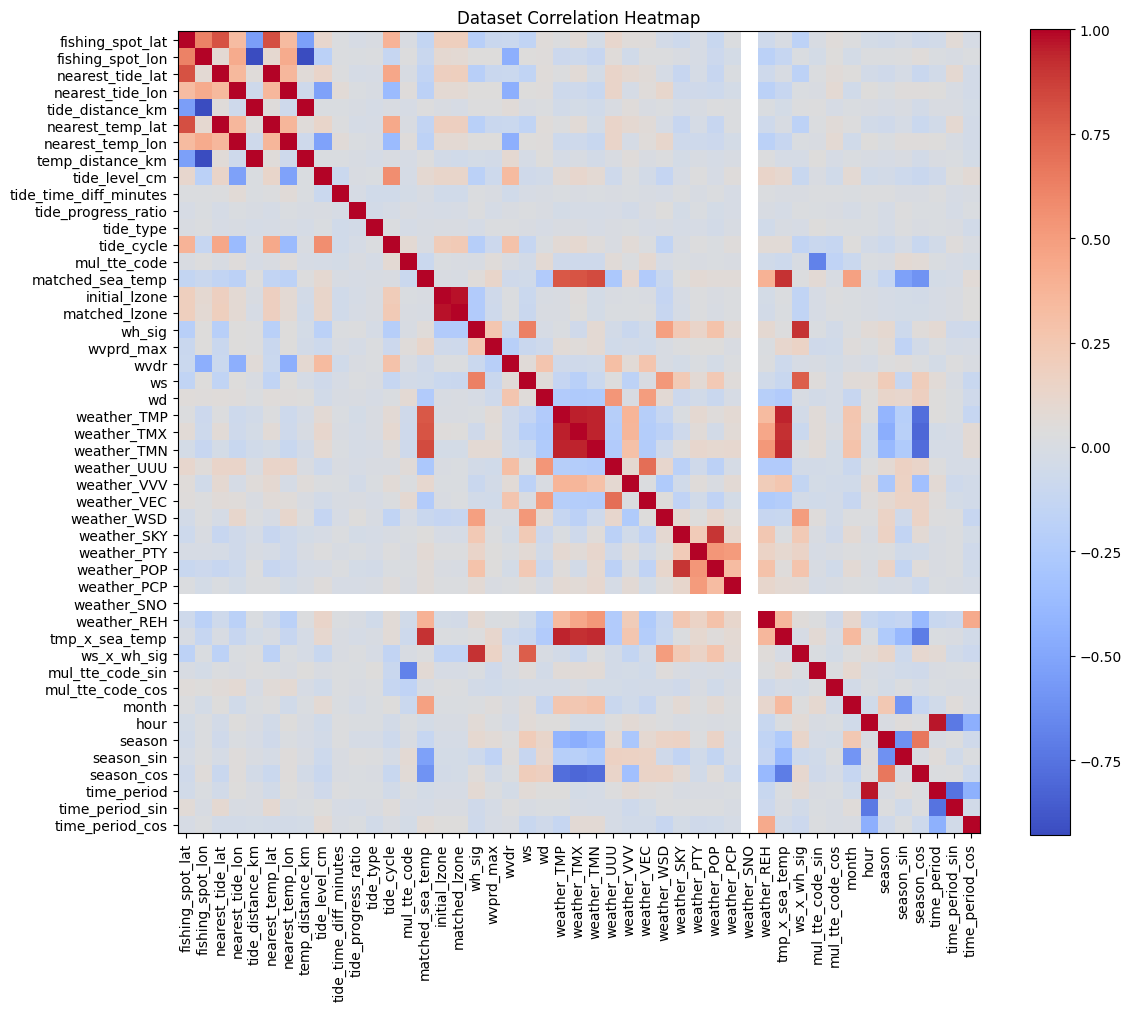


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

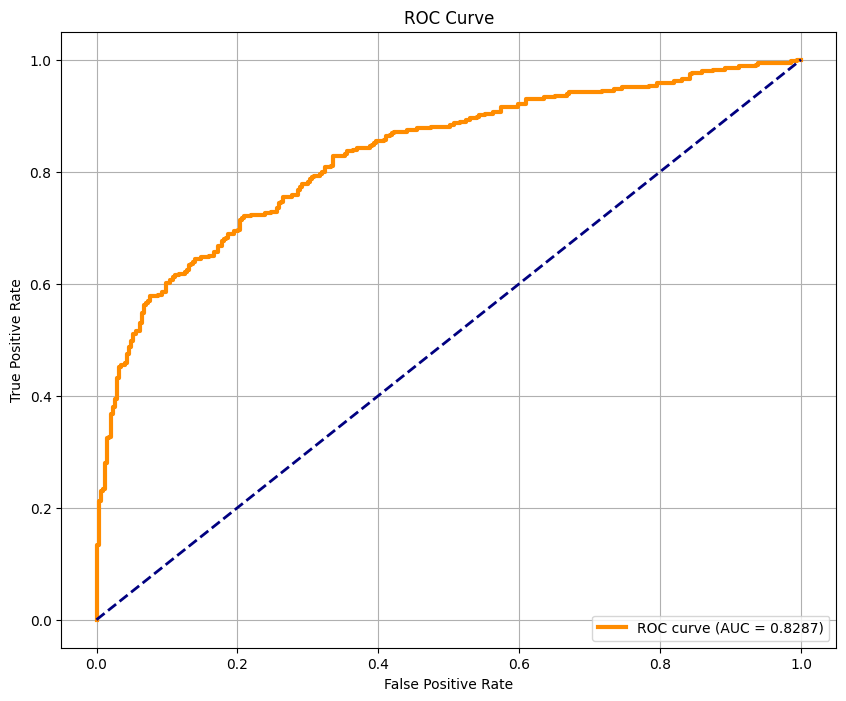

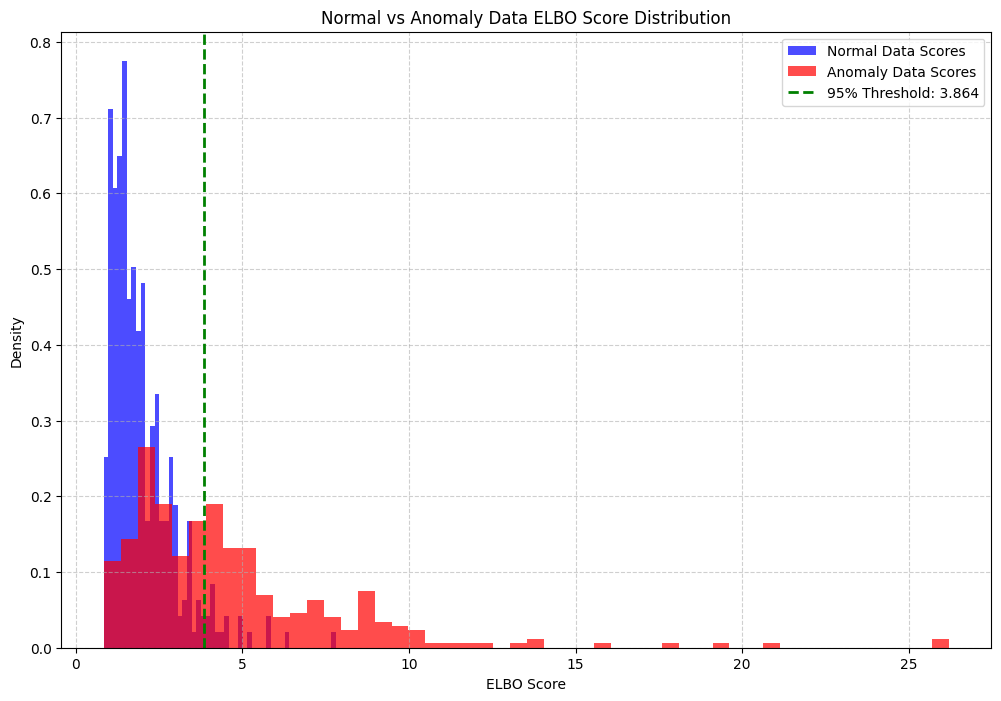

Error in experiment ImproveVAEcorr + VIF 점수 기반 변수 삭제 후 선택된 변수들 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE상호 작용 변수 생성 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin'

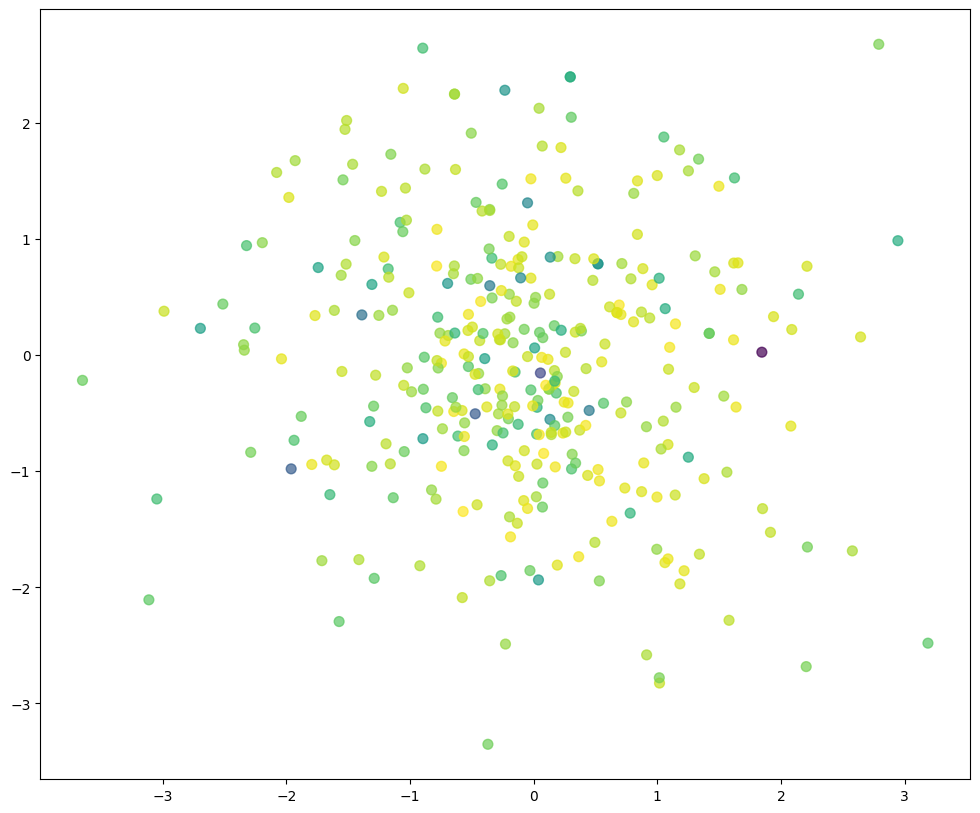

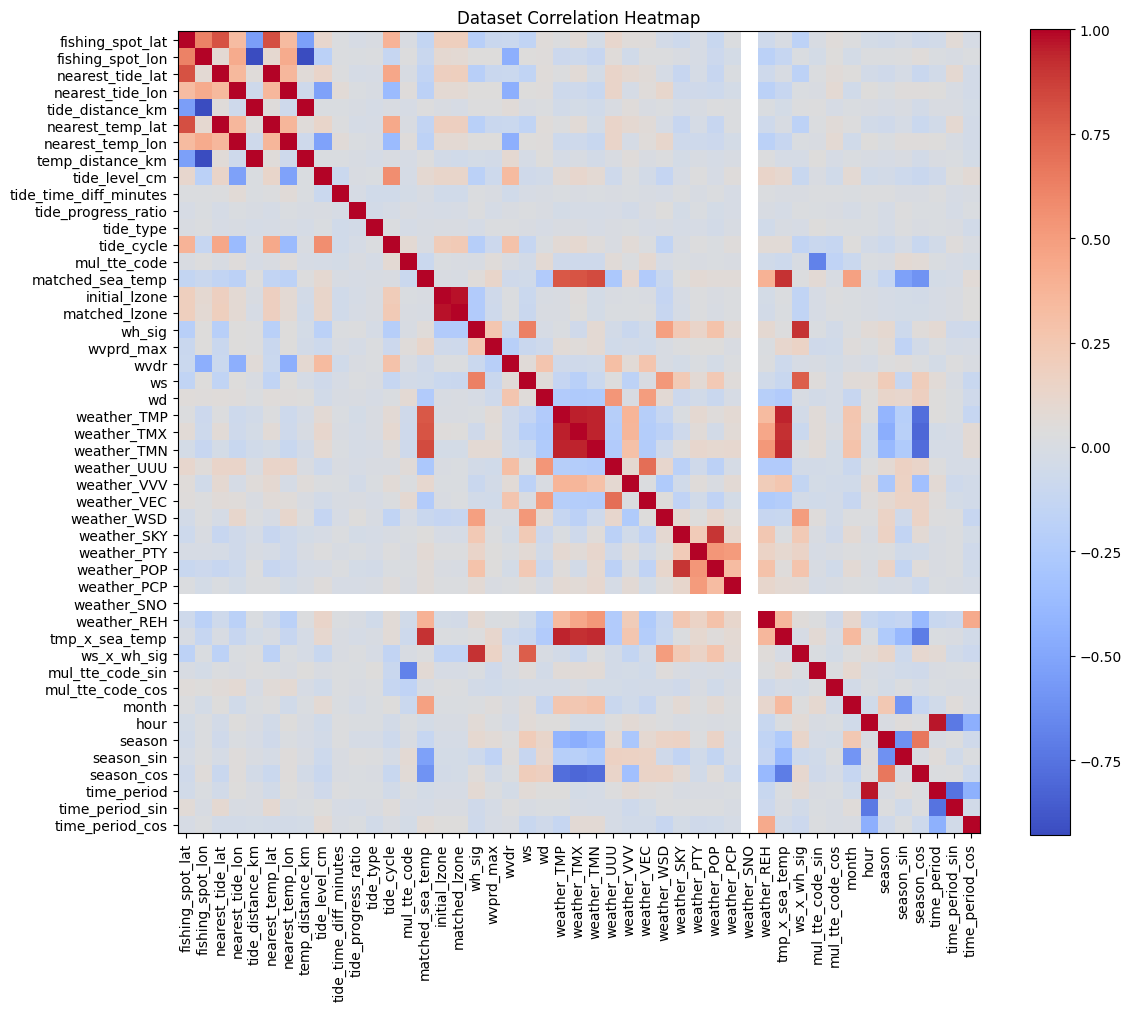


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

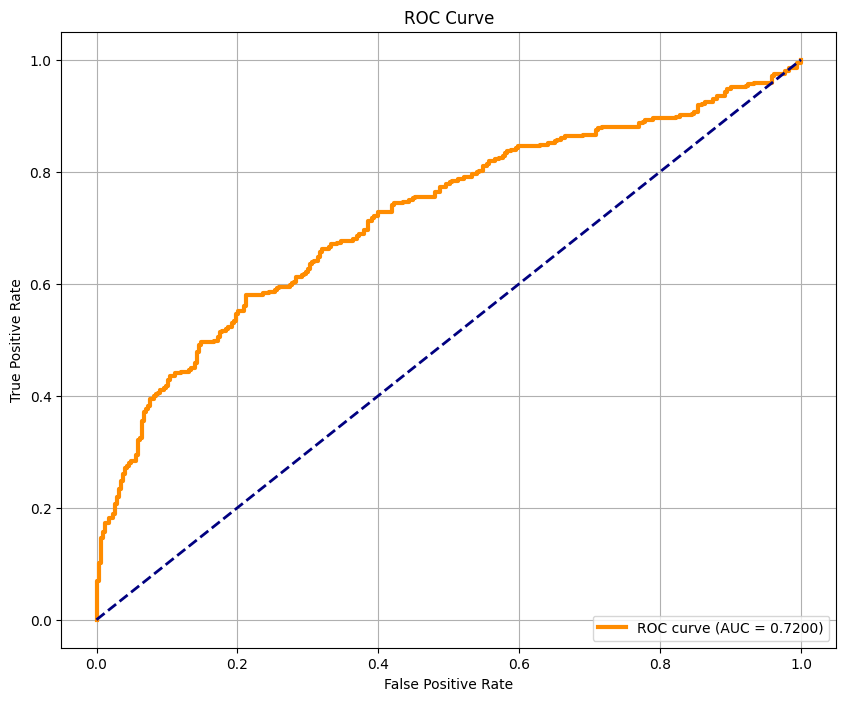

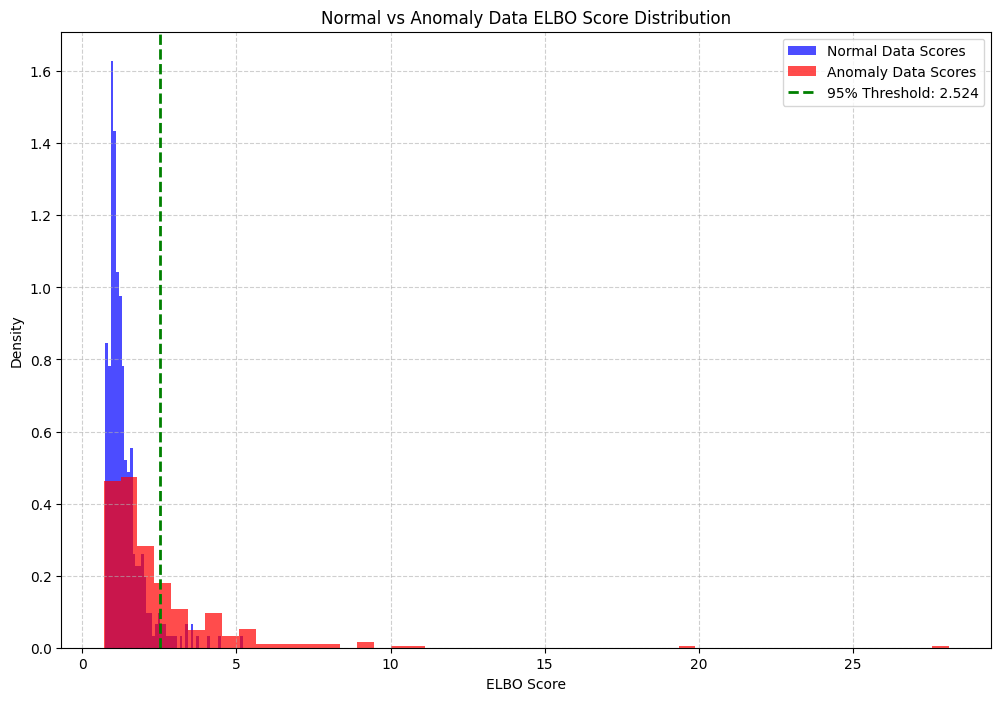

Error in experiment ImproveVAE상호 작용 변수 생성 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE물때 적용 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


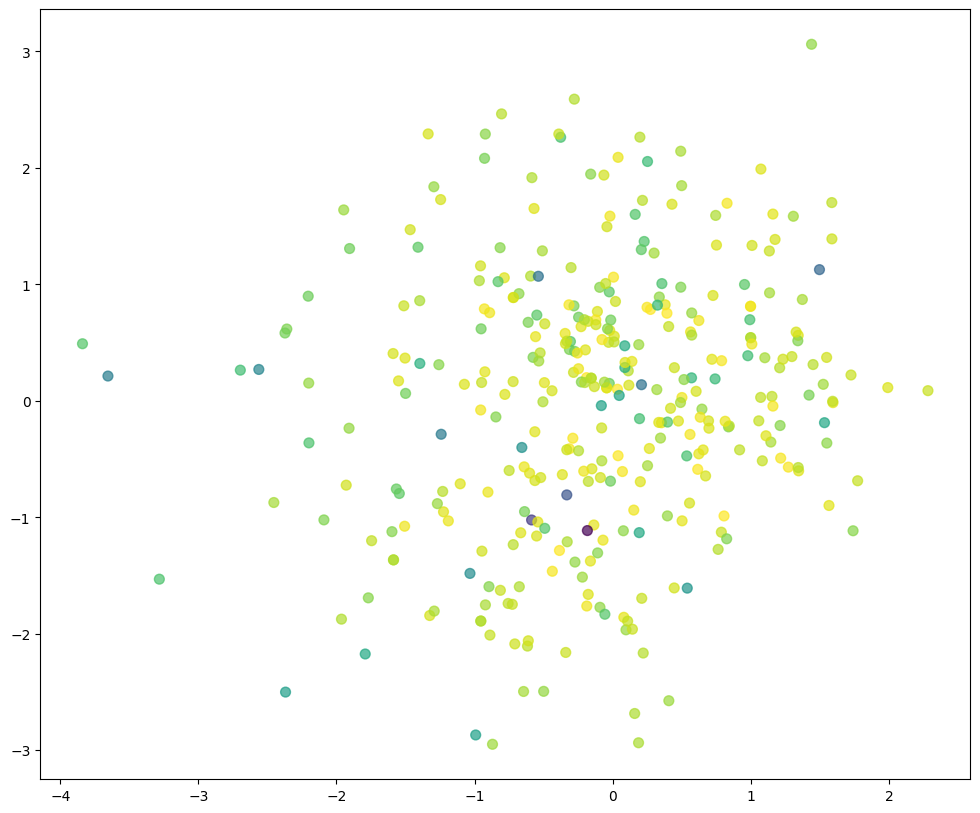

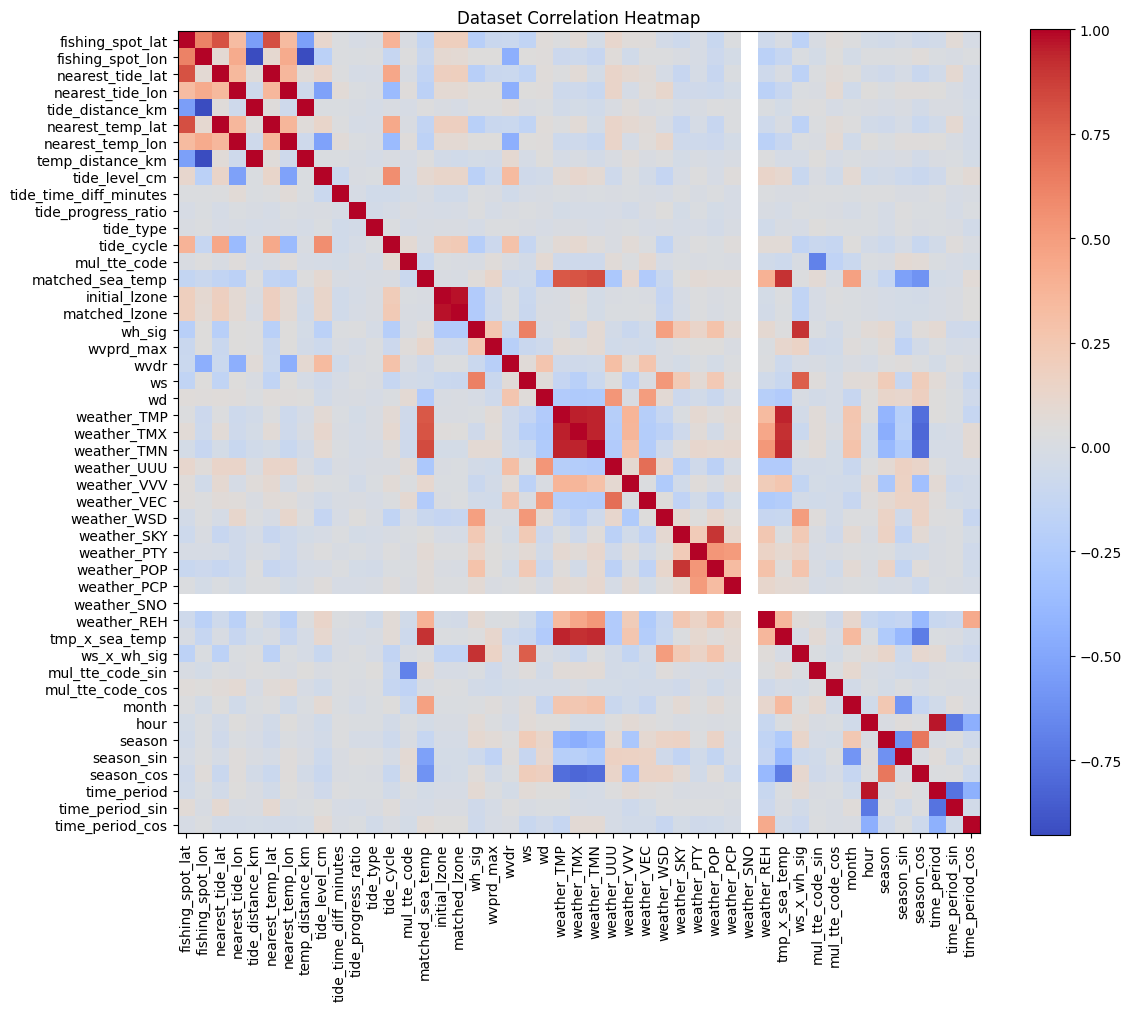


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

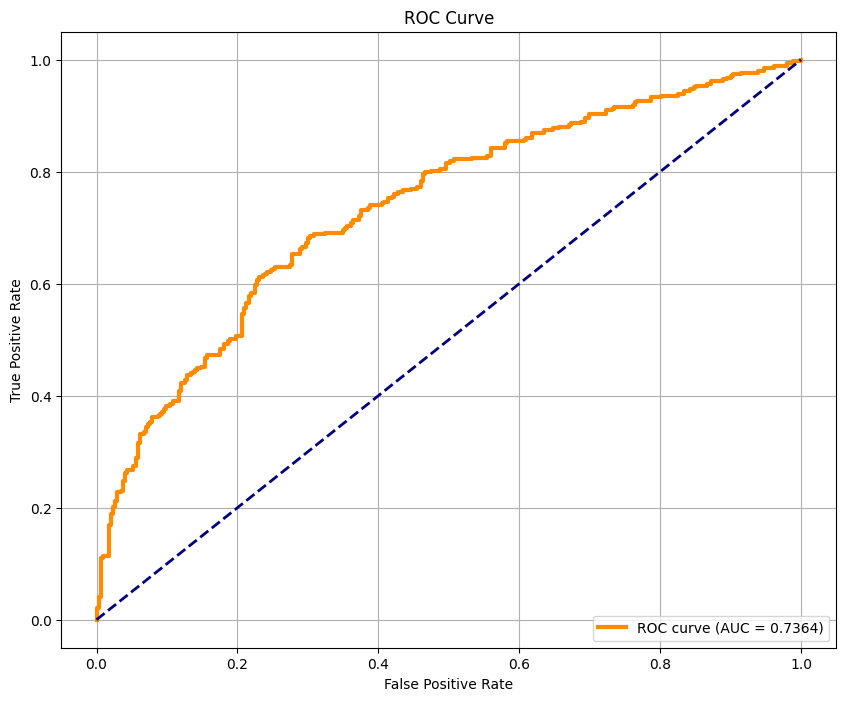

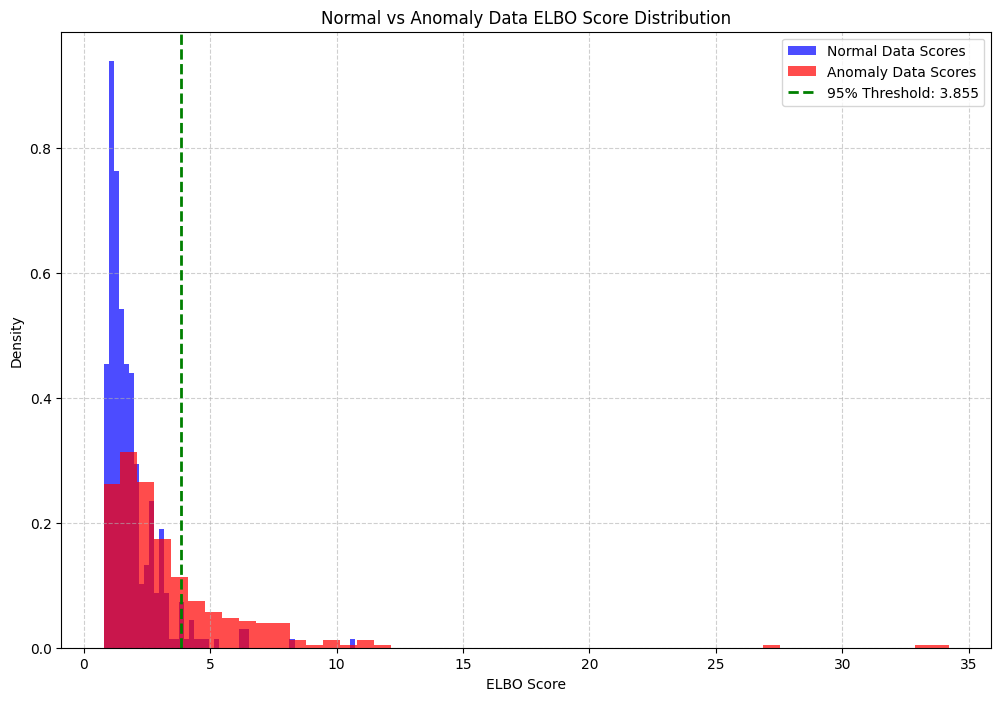

Error in experiment ImproveVAE물때 적용 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE물때 sin/cos 인코딩 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


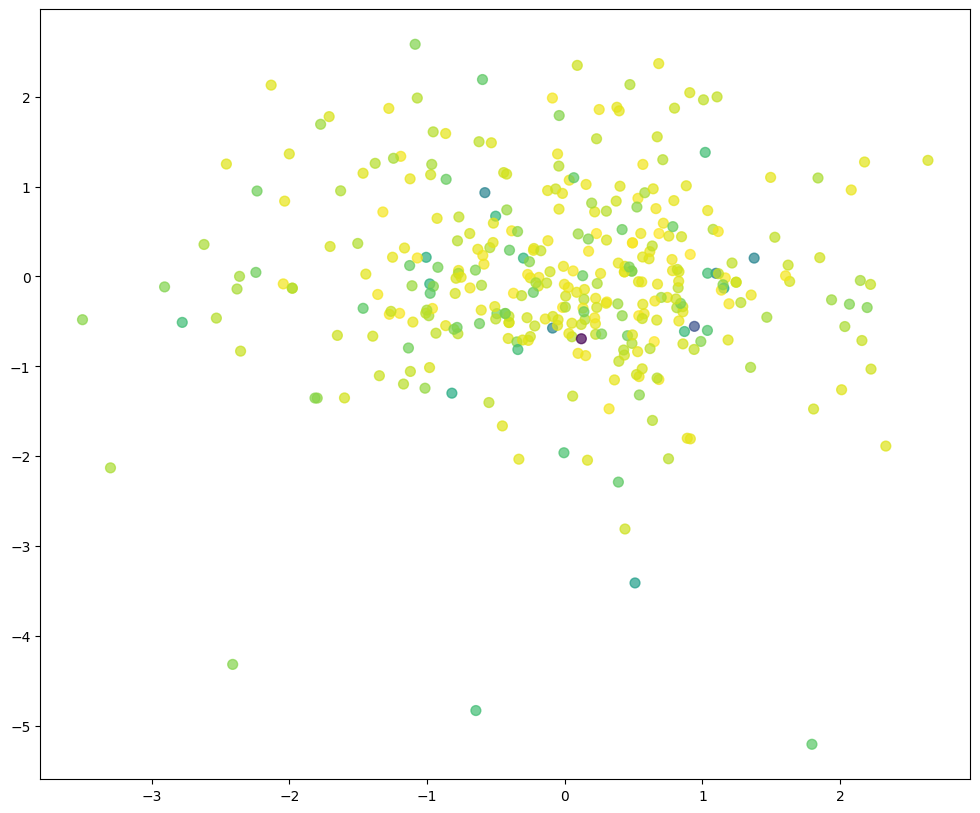

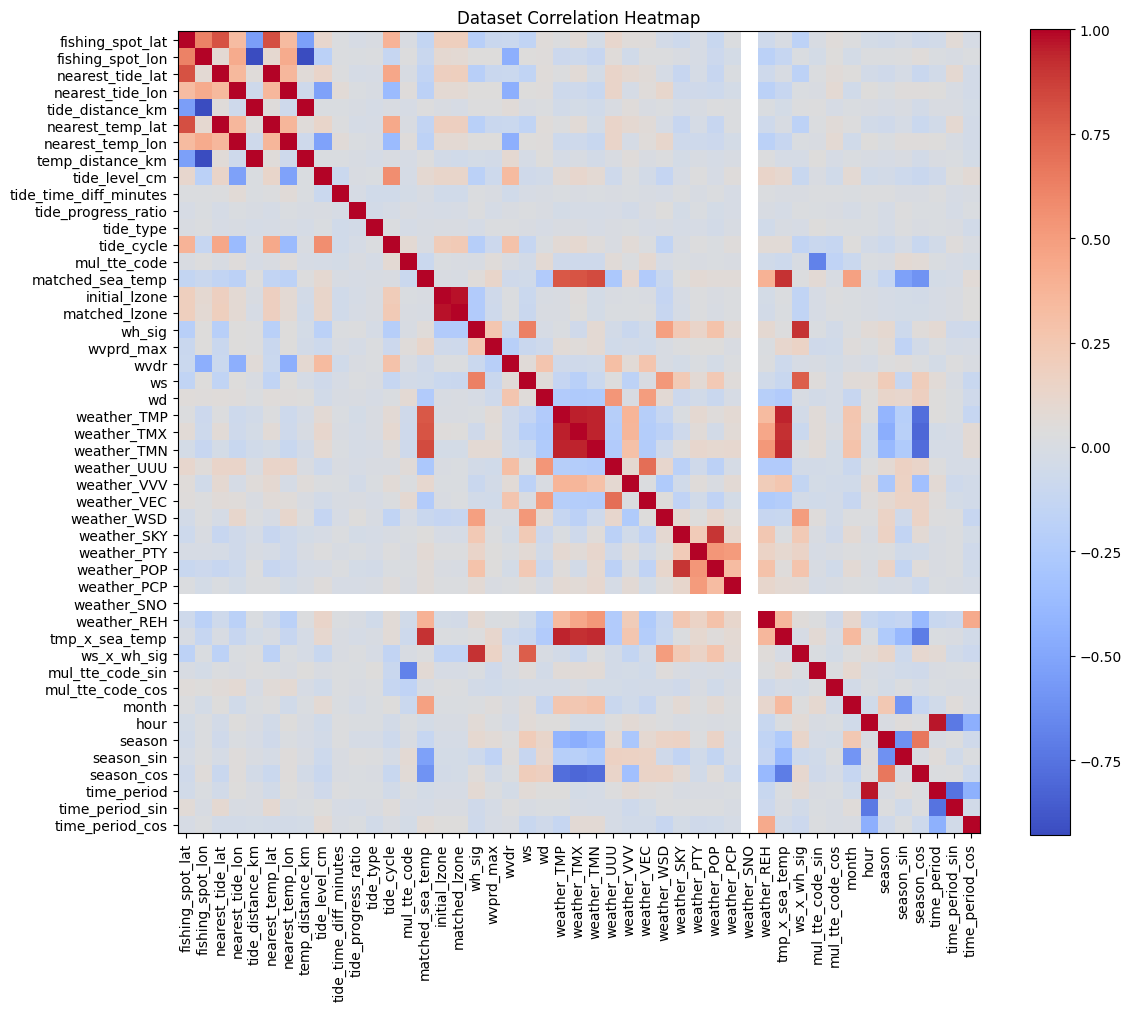


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

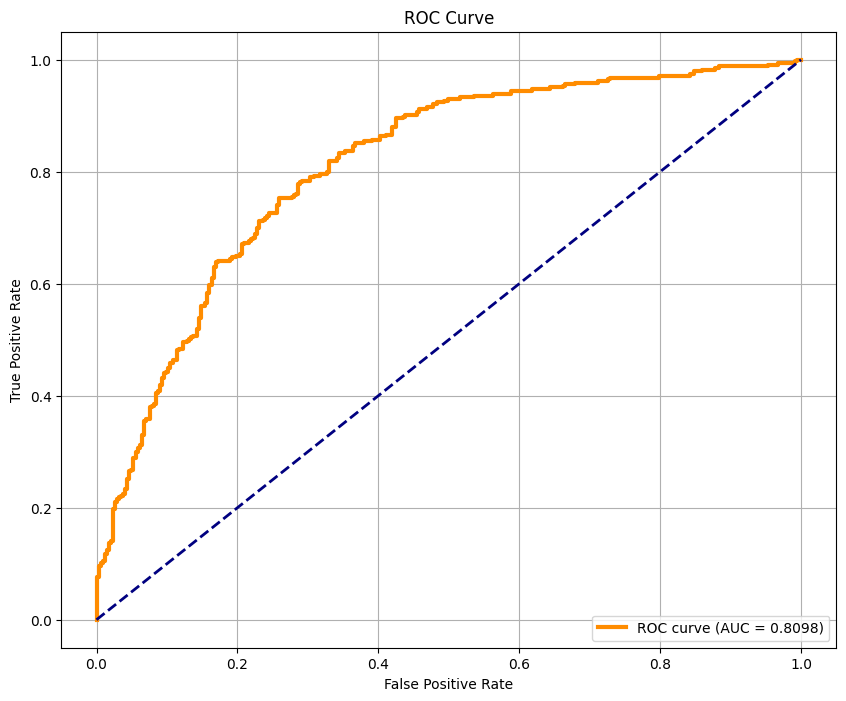

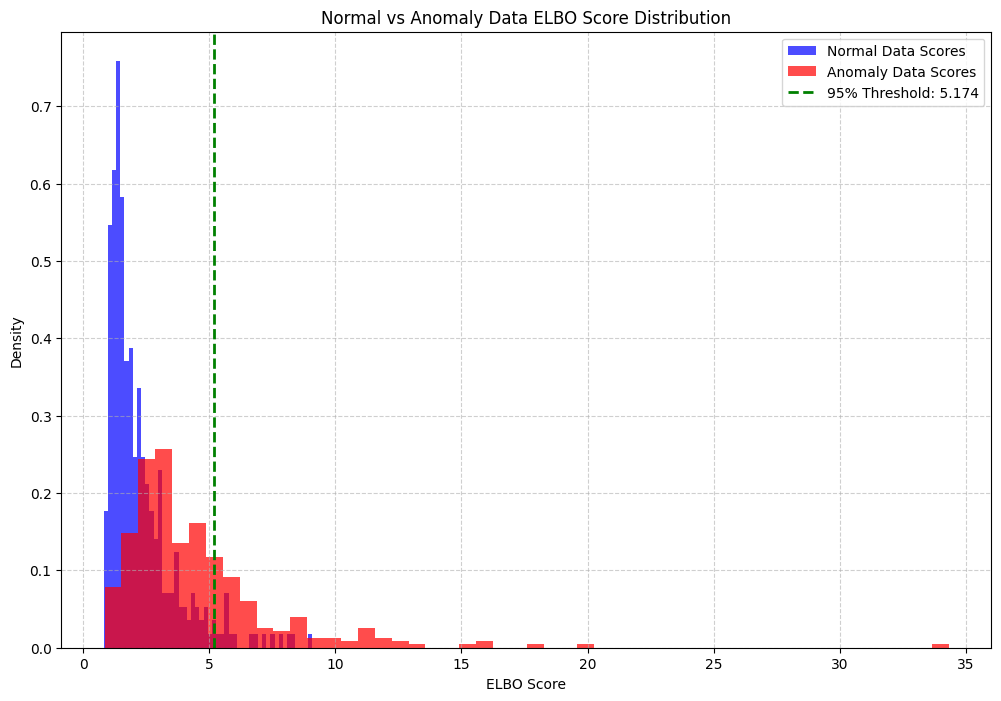

Error in experiment ImproveVAE물때 sin/cos 인코딩 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE계절 추가 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


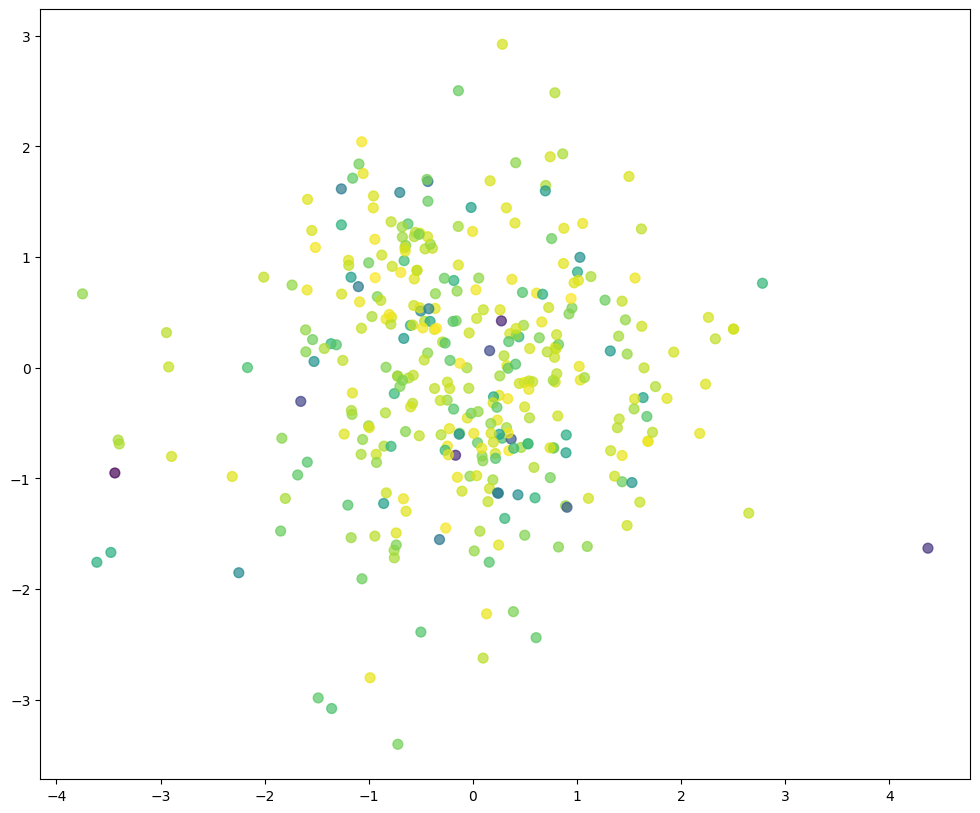

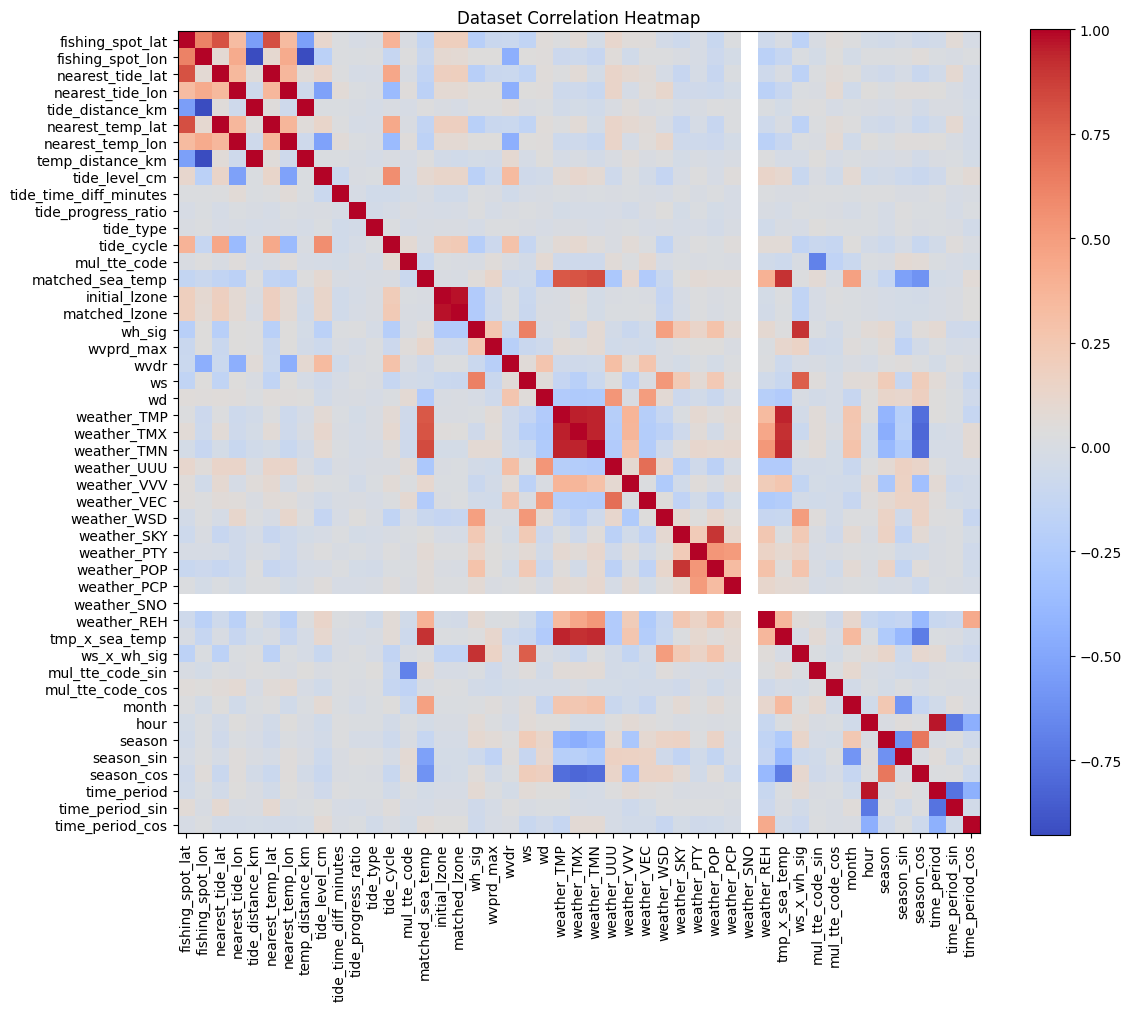


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

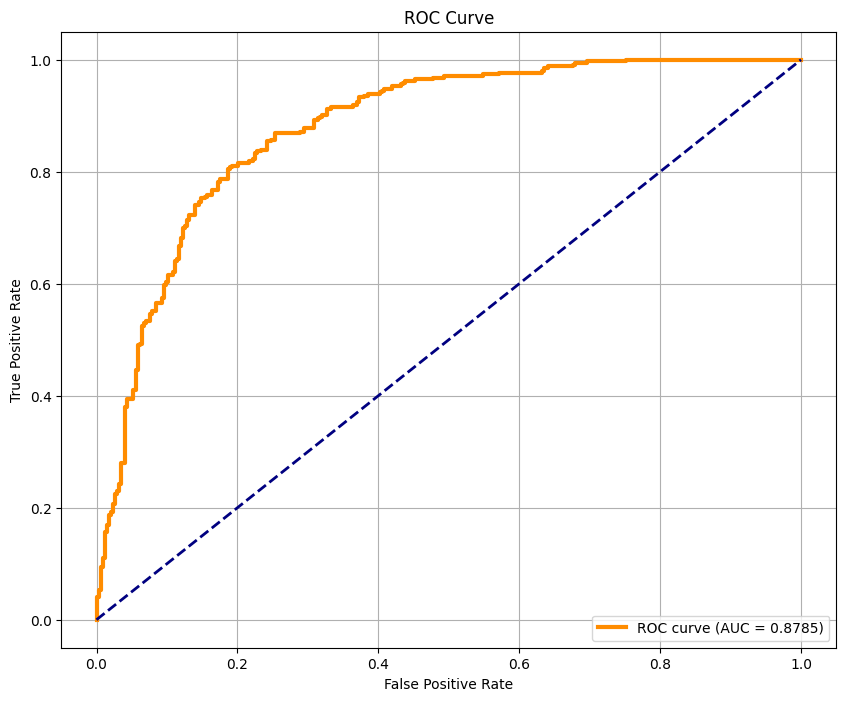

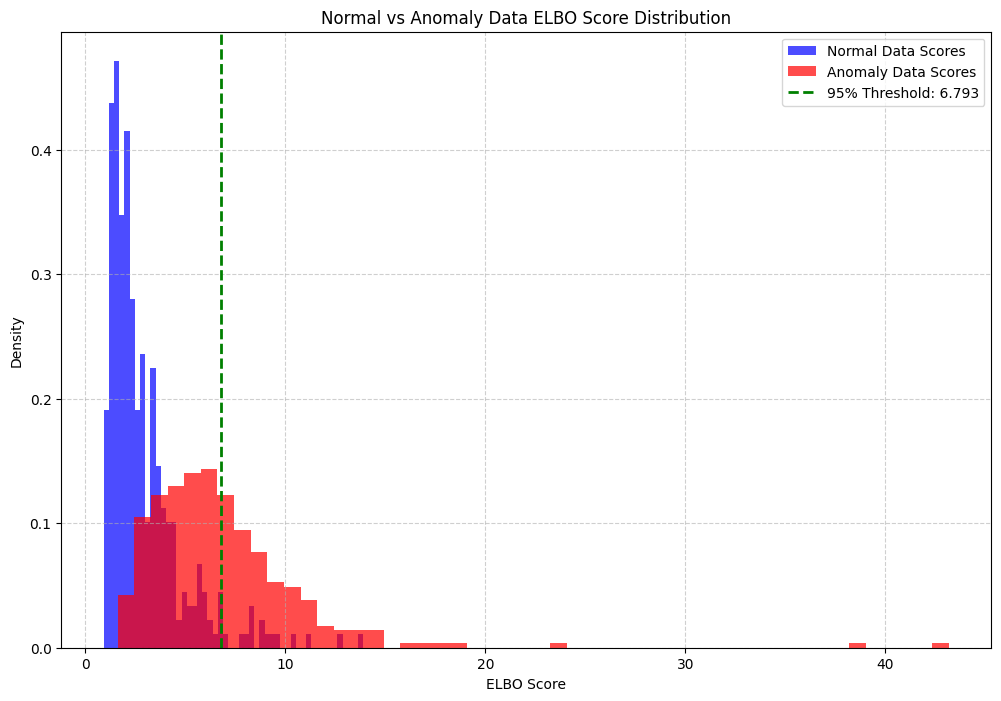

Error in experiment ImproveVAE계절 추가 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE시간대 추가 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


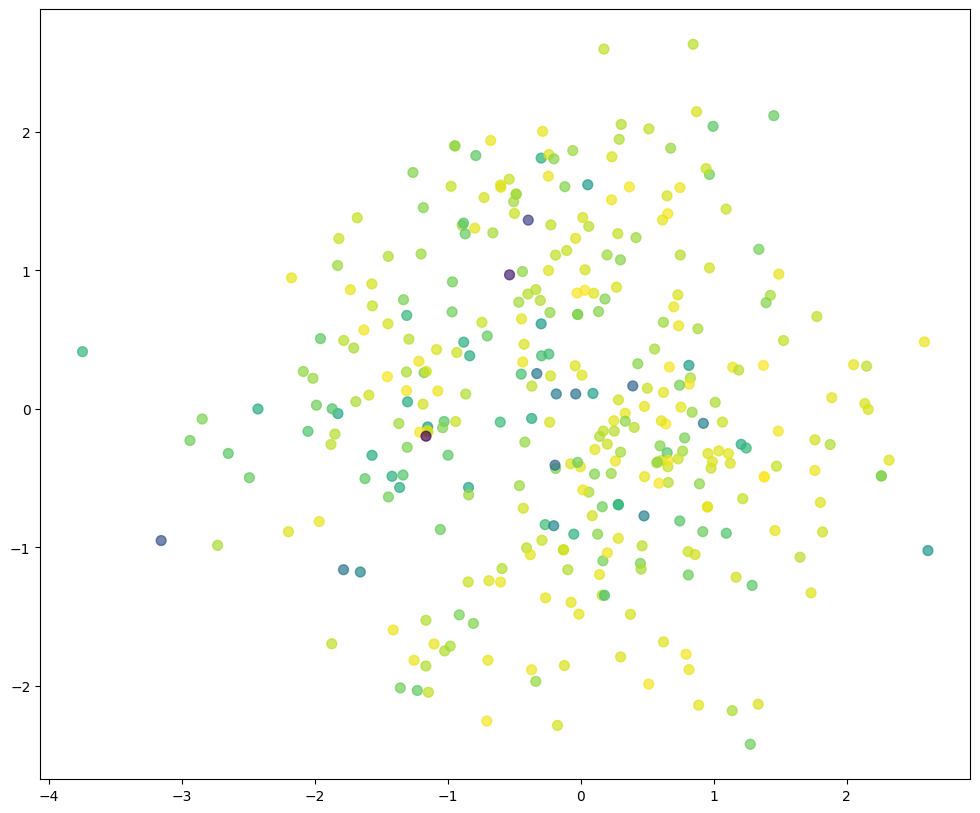

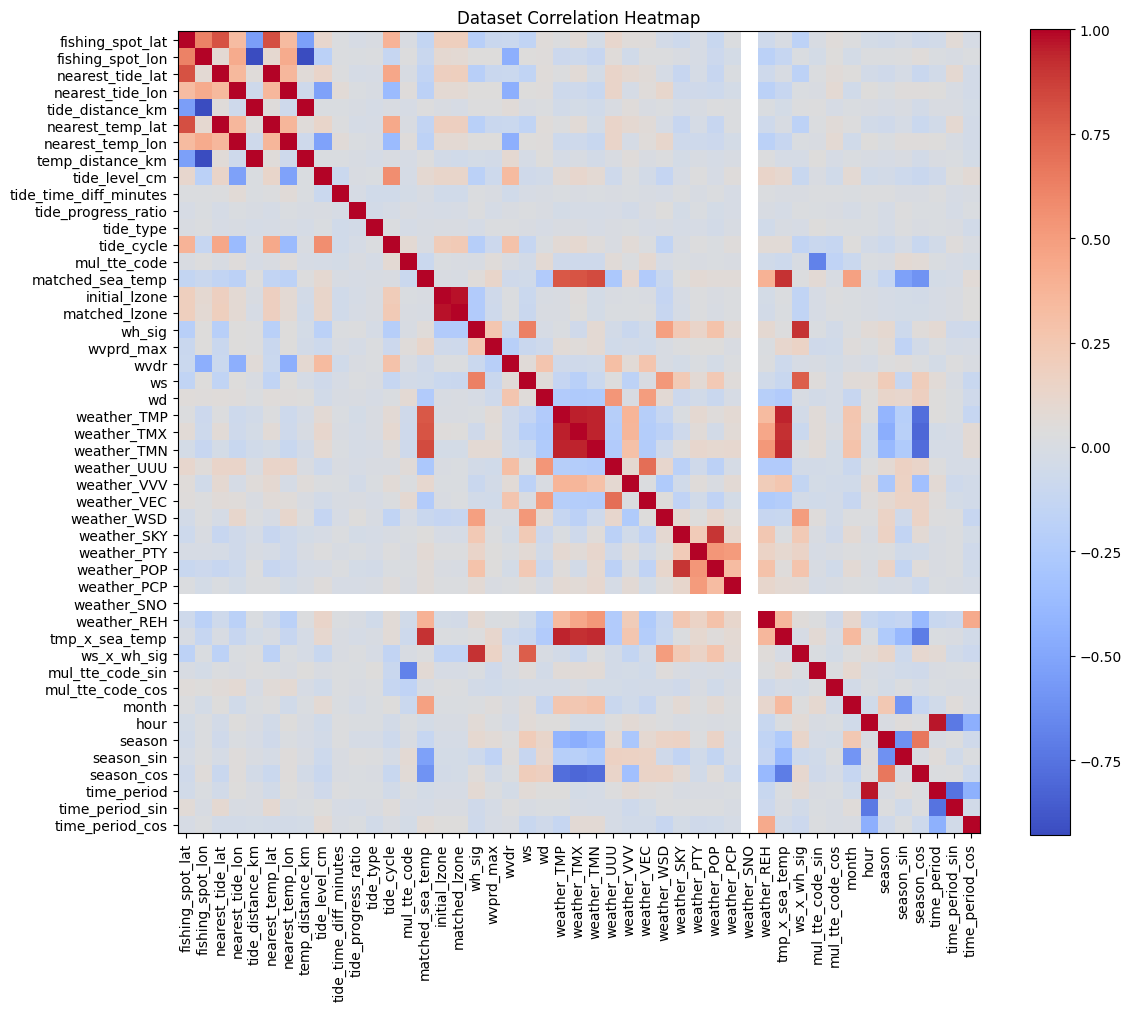


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

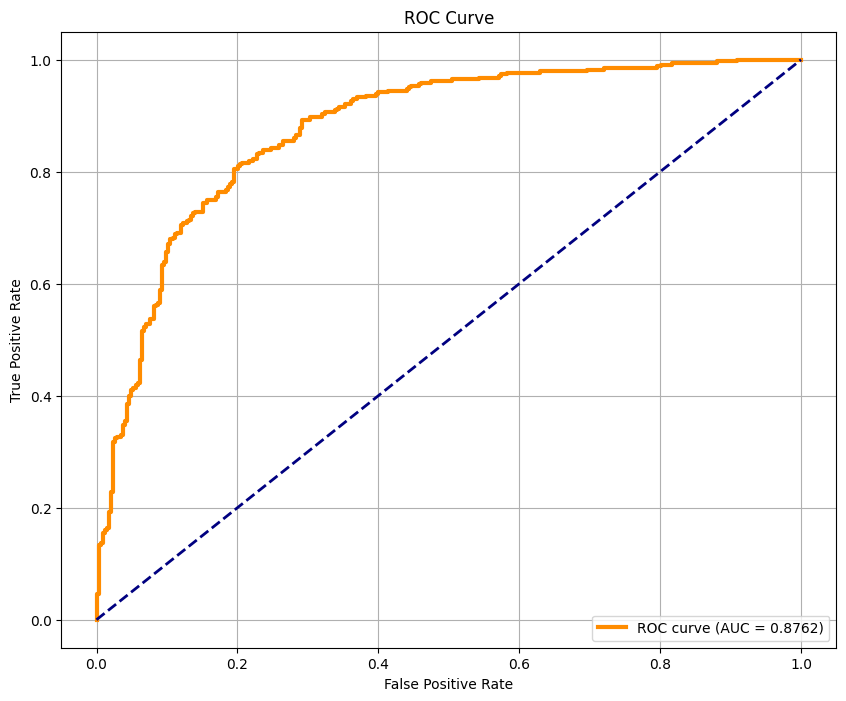

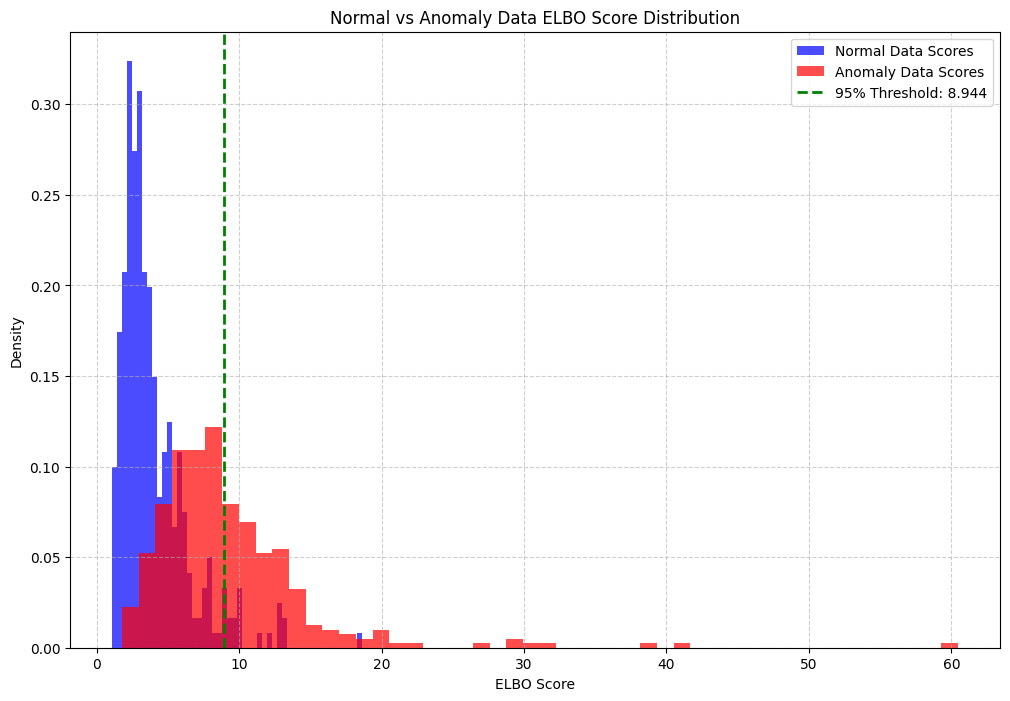

Error in experiment ImproveVAE시간대 추가 + PCA_False: name 'scatter' is not defined

Running experiment: ImproveVAE물때 제거 + PCA_False...
Starting correlation analysis...

Dataset Correlation Analysis
Number of numeric variables: 47
Numeric variables: ['fishing_spot_lat', 'fishing_spot_lon', 'nearest_tide_lat', 'nearest_tide_lon', 'tide_distance_km', 'nearest_temp_lat', 'nearest_temp_lon', 'temp_distance_km', 'tide_level_cm', 'tide_time_diff_minutes', 'tide_progress_ratio', 'tide_type', 'tide_cycle', 'mul_tte_code', 'matched_sea_temp', 'initial_lzone', 'matched_lzone', 'wh_sig', 'wvprd_max', 'wvdr', 'ws', 'wd', 'weather_TMP', 'weather_TMX', 'weather_TMN', 'weather_UUU', 'weather_VVV', 'weather_VEC', 'weather_WSD', 'weather_SKY', 'weather_PTY', 'weather_POP', 'weather_PCP', 'weather_SNO', 'weather_REH', 'tmp_x_sea_temp', 'ws_x_wh_sig', 'mul_tte_code_sin', 'mul_tte_code_cos', 'month', 'hour', 'season', 'season_sin', 'season_cos', 'time_period', 'time_period_sin', 'time_period_cos']


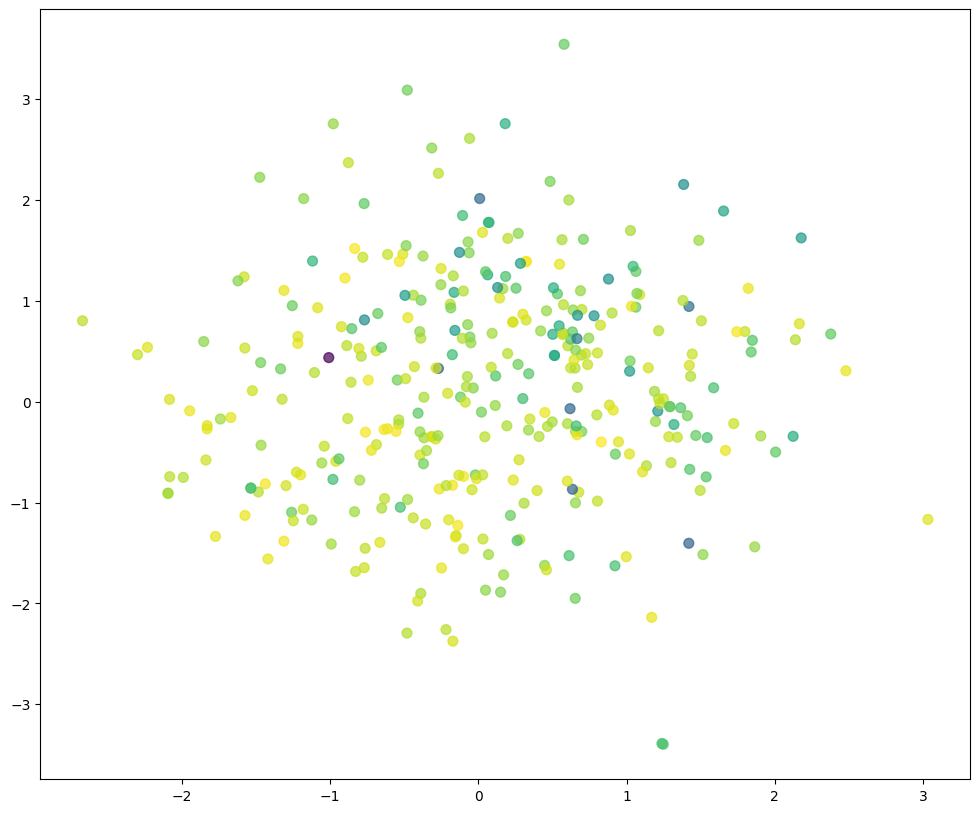

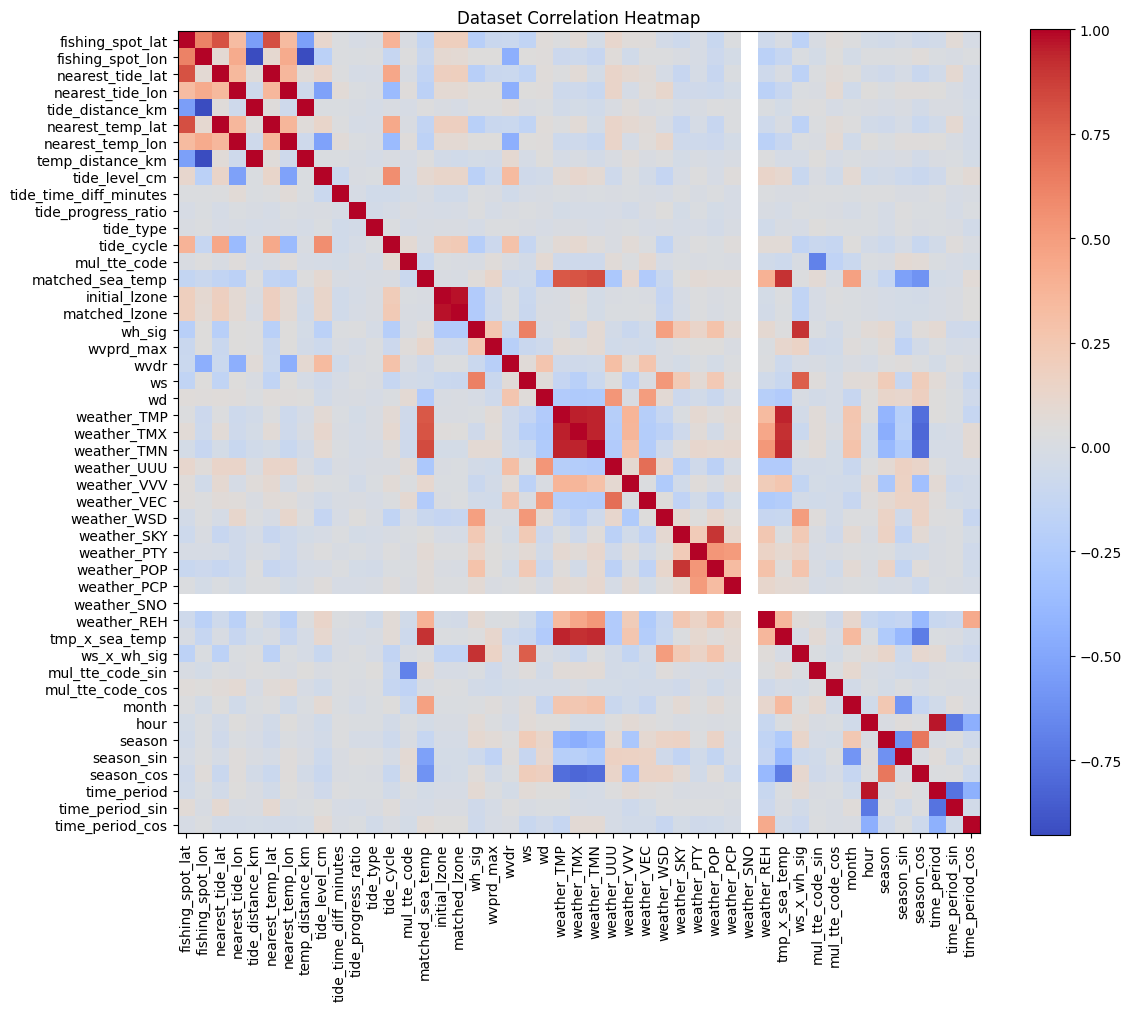


Highly correlated feature pairs (threshold=0.7):
  temp_distance_km ↔ tide_distance_km: 1.000
  nearest_temp_lat ↔ nearest_tide_lat: 0.997
  nearest_temp_lon ↔ nearest_tide_lon: 0.997
  matched_lzone ↔ initial_lzone: 0.970
  time_period ↔ hour: 0.963
  weather_TMX ↔ weather_TMP: 0.948
  weather_TMN ↔ weather_TMX: 0.944
  weather_TMN ↔ weather_TMP: 0.941
  tmp_x_sea_temp ↔ weather_TMP: 0.941
  tide_distance_km ↔ fishing_spot_lon: 0.930
  temp_distance_km ↔ fishing_spot_lon: 0.930
  tmp_x_sea_temp ↔ weather_TMN: 0.925
  tmp_x_sea_temp ↔ weather_TMX: 0.915
  tmp_x_sea_temp ↔ matched_sea_temp: 0.908
  ws_x_wh_sig ↔ wh_sig: 0.906
  weather_POP ↔ weather_SKY: 0.895
  weather_TMN ↔ matched_sea_temp: 0.831
  nearest_temp_lat ↔ fishing_spot_lat: 0.812
  nearest_tide_lat ↔ fishing_spot_lat: 0.808
  season_cos ↔ weather_TMX: 0.805
  weather_TMX ↔ matched_sea_temp: 0.799
  weather_TMP ↔ matched_sea_temp: 0.787
  season_cos ↔ weather_TMN: 0.786
  season_cos ↔ weather_TMP: 0.775
  ws_x_wh_sig ↔ ws:

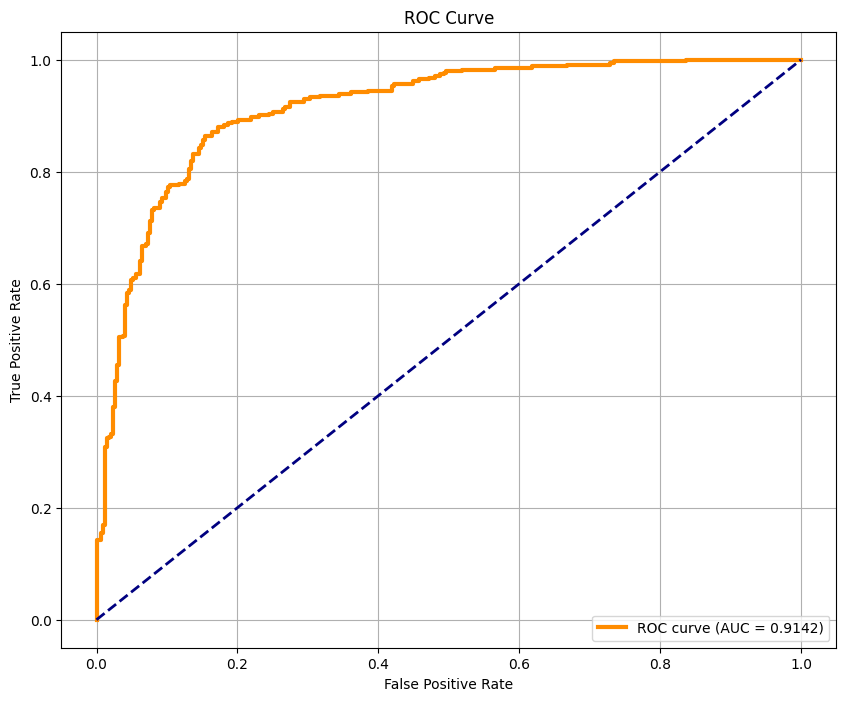

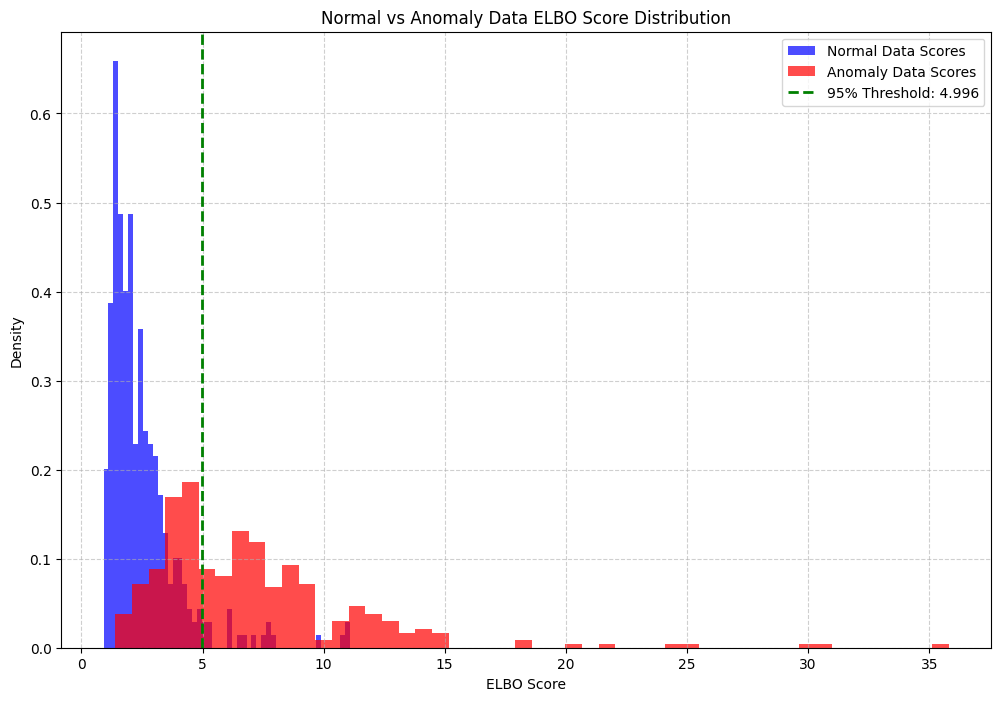

Error in experiment ImproveVAE물때 제거 + PCA_False: name 'scatter' is not defined


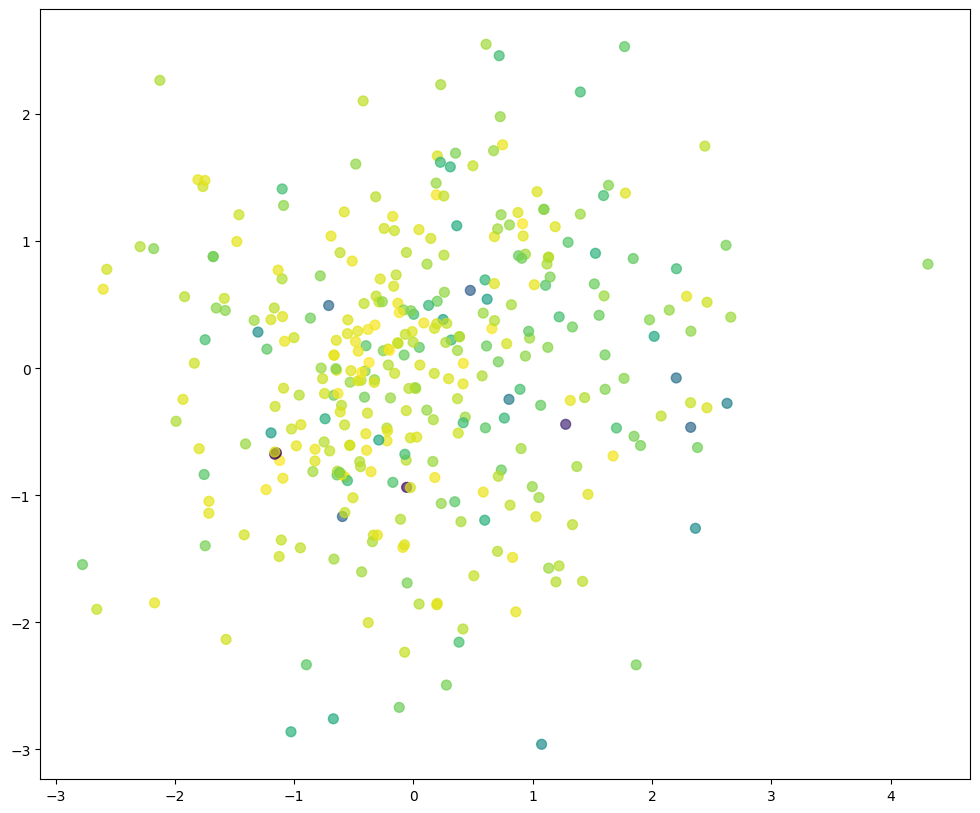

In [ ]:

df = pd.read_csv("../data/final_fish_data.csv")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]

df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)

df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)

df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour

df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 
                                            2 if 6 <= x <= 8 else 
                                            3 if 9 <= x <= 11 else 4)

df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)

df['time_period'] = df['hour'].apply(
    lambda x: 0 if 0 <= x < 6 else 
              1 if 6 <= x < 12 else 
              2 if 12 <= x < 18 else 
              3
)

df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_combinations = [
    
    # 원본 변수들
    ["weather_TMP", "matched_sea_temp", "ws", "wh_sig", "weather_REH", "wvprd_max" , "wvdr", "wd"],
    
    # 상호 작용 변수 생성
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd"],
    
    # 물때 적용
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code"],
    
    # 물때 sin/cos 인코딩 적용 -> 순환 주기를 제공
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos"],
    
    # 계절 추가 -> 계절은 순환주기로 sin/cos 인코딩
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos"],
    
    # 시간대 추가
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],
    
    # 물때 제거
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],

]

experiment_names = [
    "corr + VIF 점수 기반 변수 삭제 후 선택된 변수들", 
    "상호 작용 변수 생성", 
    "물때 적용", 
    "물때 sin/cos 인코딩",
    "계절 추가",
    "시간대 추가",
    "물때 제거"
]

new_experiment_names = ["ImproveVAE" + name + " + PCA_False" for name in experiment_names]

comparison_df = compare_analysis_combinations(
    df=df,
    feature_combinations=feature_combinations,
    experiment_names=new_experiment_names,
    use_hyperparameter_search=True,
    use_pca_weights=False
)
